1. Get hole embeddings
2. Get hole center
3. Calculate characteristics: (max distance to contour, min distance to contour, distance to center x n_holes)
4. On separate texts: mean of characteristics from 4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from tqdm.auto import tqdm, trange

In [2]:
from src.holes_utils import get_cycles, get_holes_per_chunk

# Hole embeddings

In [3]:
def get_hole_embeddings(lang='ru', part='word'):
    """
    Dictionary keys: {chunk_number}${hole_number}: embeddings
    """
    try:
        filtered = np.load(f"holes/{lang.upper()}/{part}s/filtered_by_lifetimes_and_syn.npy", allow_pickle=True).item()
    except:
        filtered = np.load(f"holes/{lang.upper()}/{part}s/filtered_by_lifetimes_and_hole_diam.npy", allow_pickle=True).item()
        
    h1_contours = get_holes_per_chunk(dir=f"holes/{lang.upper()}/{part}s", filenames=f"{lang}_{part}_holes_*.npy")
    
    hole_embeddings = {}
    for c in filtered:
        embs = np.load(f"split_space_kmeans/{lang.upper()}/{part}s/subsets/{lang}_{part}_{c}.npy")
        for hole_num in filtered[c]:
            hole_embeddings[f"{c}${hole_num}"] = embs[h1_contours[c][hole_num]]
    
    np.save(f"holes/{lang.upper()}/{part}s/hole_embeddings.npy", hole_embeddings)

In [4]:
hole_embeddings = {}
lang = 'en'
for part in ['word', 'bigram', 'trigram']:
    hole_embeddings[part] = np.load(f"holes/{lang.upper()}/{part}s/hole_embeddings.npy", allow_pickle=True).item()

In [5]:
# hole centers
for h in hole_embeddings[part].values():
    print(h.mean(axis=0).shape)

(300,)
(300,)
(300,)
(300,)
(300,)


In [17]:
for part in ['word', 'bigram', 'trigram']:
    print(len(hole_embeddings[part]))

4
7
5


# Bot embeddings

In [6]:
bot_names = ["mGPT", "lstm", "gpt2", "balaboba"]
parts = ['word', 'bigram', 'trigram']

In [7]:
lang = 'EN'
bot_embeddings = {}
for part in ['word', 'bigram', 'trigram']:
    bot_embeddings[part] = {}
    for bot in ["mGPT", "lstm", "gpt2", "balaboba"]:
        a = np.load(f"semantic_space/bots/{lang}/{bot}_{part}_space.npy")
        idx = np.random.choice(len(a), min(len(a), 10000), replace=False)
        bot_embeddings[part][bot] = a[idx]

In [8]:
for part in ['word', 'bigram', 'trigram']:
    for bot in ["mGPT", "lstm", "gpt2", "balaboba"]:
        print(part, bot, bot_embeddings[part][bot].shape)

word mGPT (8373, 100)
word lstm (7374, 100)
word gpt2 (10000, 100)
word balaboba (10000, 100)
bigram mGPT (10000, 200)
bigram lstm (10000, 200)
bigram gpt2 (10000, 200)
bigram balaboba (10000, 200)
trigram mGPT (10000, 300)
trigram lstm (10000, 300)
trigram gpt2 (10000, 300)
trigram balaboba (10000, 300)


In [9]:
np.save("semantic_space/bots/en_bot_embeddings_subsets.npy", bot_embeddings)

# Lit embeddings

In [7]:
# lit_embeddings = {}
# a = np.load(f"semantic_space/ru_word_cbow_space.npy")
# idx = np.random.choice(len(a), min(len(a), 10000), replace=False)
# lit_embeddings['word'] = a[idx]
# a = np.load(f"semantic_space/ru_bigram_cbow_100k.npy")
# idx = np.random.choice(len(a), min(len(a), 10000), replace=False)
# lit_embeddings['bigram'] = a[idx]
# a = np.load(f"semantic_space/ru_trigram_cbow_100k.npy")
# idx = np.random.choice(len(a), min(len(a), 10000), replace=False)
# lit_embeddings['trigram'] = a[idx]

In [43]:
np.save("semantic_space/bots/lit_embeddings_subsets.npy", lit_embeddings)

In [10]:
lit_embeddings = np.load("semantic_space/bots/lit_embeddings_subsets.npy", allow_pickle=True).item()

# Characteristics

- Distance to hole centers + Mean for all holes
- Min distance to holes + Mean for all holes
- Max distance to holes + Mean for all holes

3 * (n_holes + 1) features per part

- Categorical: closest hole (see min distance)

In [11]:
from scipy.stats import kstest

## Distance to centers

In [12]:
from sklearn.metrics import pairwise_distances
bot_ch = {}
lit_ch = {}
for part in tqdm(['word', 'bigram', 'trigram']):
    hole_e_centers = np.vstack([h.mean(axis=0) for h in hole_embeddings[part].values()])
    lit_ch[part] = pairwise_distances(lit_embeddings[part], hole_e_centers, metric='cosine')
    lit_ch[part] = np.hstack([lit_ch[part], lit_ch[part].mean(axis=1).reshape(-1, 1)])
    bot_ch[part] = {}
    for bot in ["mGPT", "lstm", "gpt2", "balaboba"]:
        bot_ch[part][bot] = pairwise_distances(bot_embeddings[part][bot], hole_e_centers, metric='cosine')
        bot_ch[part][bot] = np.hstack([bot_ch[part][bot], bot_ch[part][bot].mean(axis=1).reshape(-1, 1)])

  0%|          | 0/3 [00:00<?, ?it/s]

## Min/max distances

In [13]:
def get_dist_array(e, hole_embs, apply_func=np.min):
    dist_list = np.vstack([apply_func(pairwise_distances(e, hole, metric='cosine'), axis=1) for hole in hole_embs])
    dist_list = np.vstack([dist_list, dist_list.mean(axis=0)])
    return dist_list.T

In [14]:
for part in tqdm(parts):
    lit_ch[part] = np.hstack([
        lit_ch[part],
        get_dist_array(lit_embeddings[part], hole_embeddings[part].values(), np.min),
        get_dist_array(lit_embeddings[part], hole_embeddings[part].values(), np.max)
    ])
    for bot in bot_names:
        bot_ch[part][bot] = np.hstack([
            bot_ch[part][bot],
            get_dist_array(bot_embeddings[part][bot], hole_embeddings[part].values(), np.min),
            get_dist_array(bot_embeddings[part][bot], hole_embeddings[part].values(), np.max)
        ])

  0%|          | 0/3 [00:00<?, ?it/s]

## Closest holes (categorical)

In [12]:
# def get_closest_hole(ch, hnames):
#     n_holes = len(hnames)
#     return hnames[ch[:, n_holes:n_holes*2].argmin(axis=1)]

In [186]:
get_closest_hole(ch, hnames).shape

(10000,)

In [15]:
for part in tqdm(parts):
    n_holes = len(hole_embeddings[part])
    lit_ch[part] = np.hstack([
        lit_ch[part],
        lit_ch[part][:, n_holes:n_holes*2].argmin(axis=1).reshape(-1, 1)
    ])
    for bot in bot_names:
        bot_ch[part][bot] = np.hstack([
            bot_ch[part][bot],
            bot_ch[part][bot][:, n_holes:n_holes*2].argmin(axis=1).reshape(-1, 1)
        ])

  0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
for part in parts:
    n_holes = len(hole_embeddings[part])
    assert lit_ch[part].shape[1] == (n_holes + 1) * 3 + 1
    for bot in bot_names:
        assert bot_ch[part][bot].shape[1] == (n_holes + 1) * 3 + 1

In [44]:
lit_min_dist = {}
bot_min_dist = {part:{} for part in ['word', 'bigram', 'trigram']}
lit_min_dist['word'] = lit_ch['word'][:,8:15].min(axis=1)
for bot in bot_names:
    bot_min_dist['word'][bot] = bot_ch['word'][bot][:,8:15].min(axis=1)

In [45]:
lit_min_dist['bigram'] = lit_ch['bigram'][:,13:25].min(axis=1)
for bot in bot_names:
    bot_min_dist['bigram'][bot] = bot_ch['bigram'][bot][:,13:25].min(axis=1)

In [46]:
lit_min_dist['trigram'] = lit_ch['trigram'][:,13:25].min(axis=1)
for bot in bot_names:
    bot_min_dist['trigram'][bot] = bot_ch['trigram'][bot][:,13:25].min(axis=1)

# Figures

## Word

In [ ]:
for i in range(7):
    plt.hist(lit_ch['word'][:,i], label="lit", bins=100, alpha=.5);
    
    for bot in bot_names:
        plt.hist(bot_ch['word'][bot][:,i], label=bot, bins=100, alpha=.5);
    plt.legend()
    plt.show()

### Dist to centers

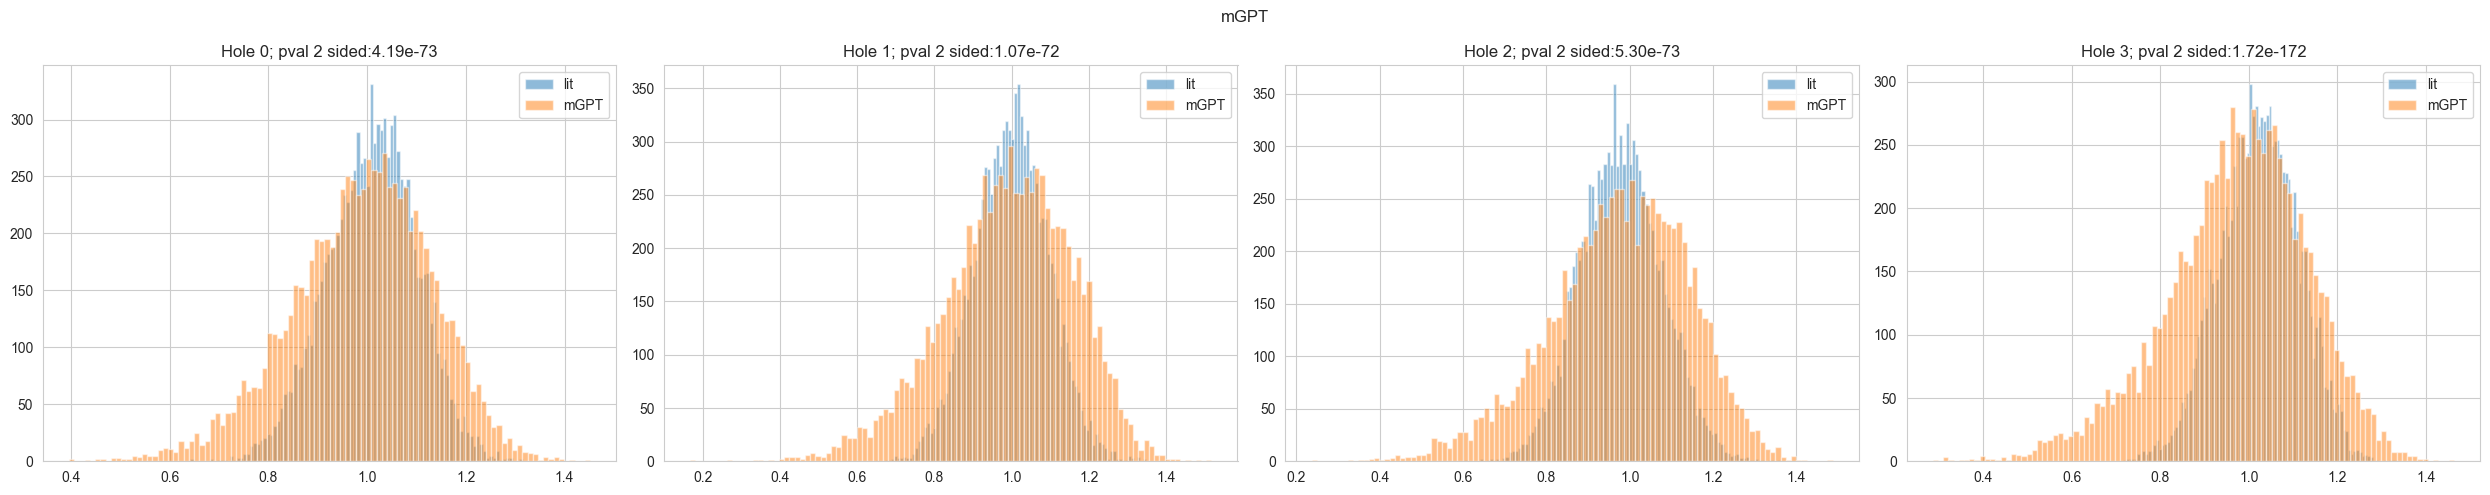

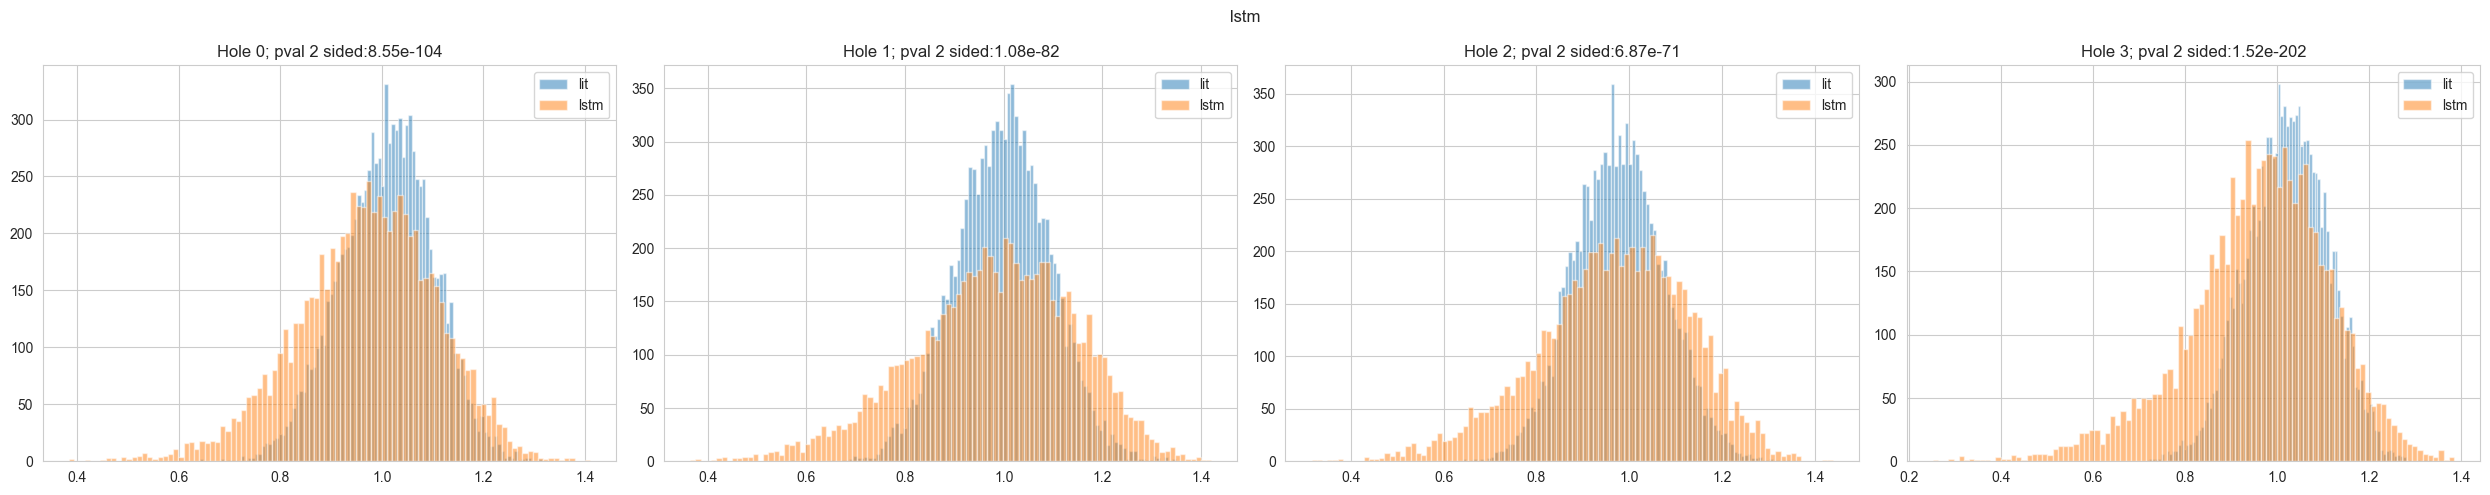

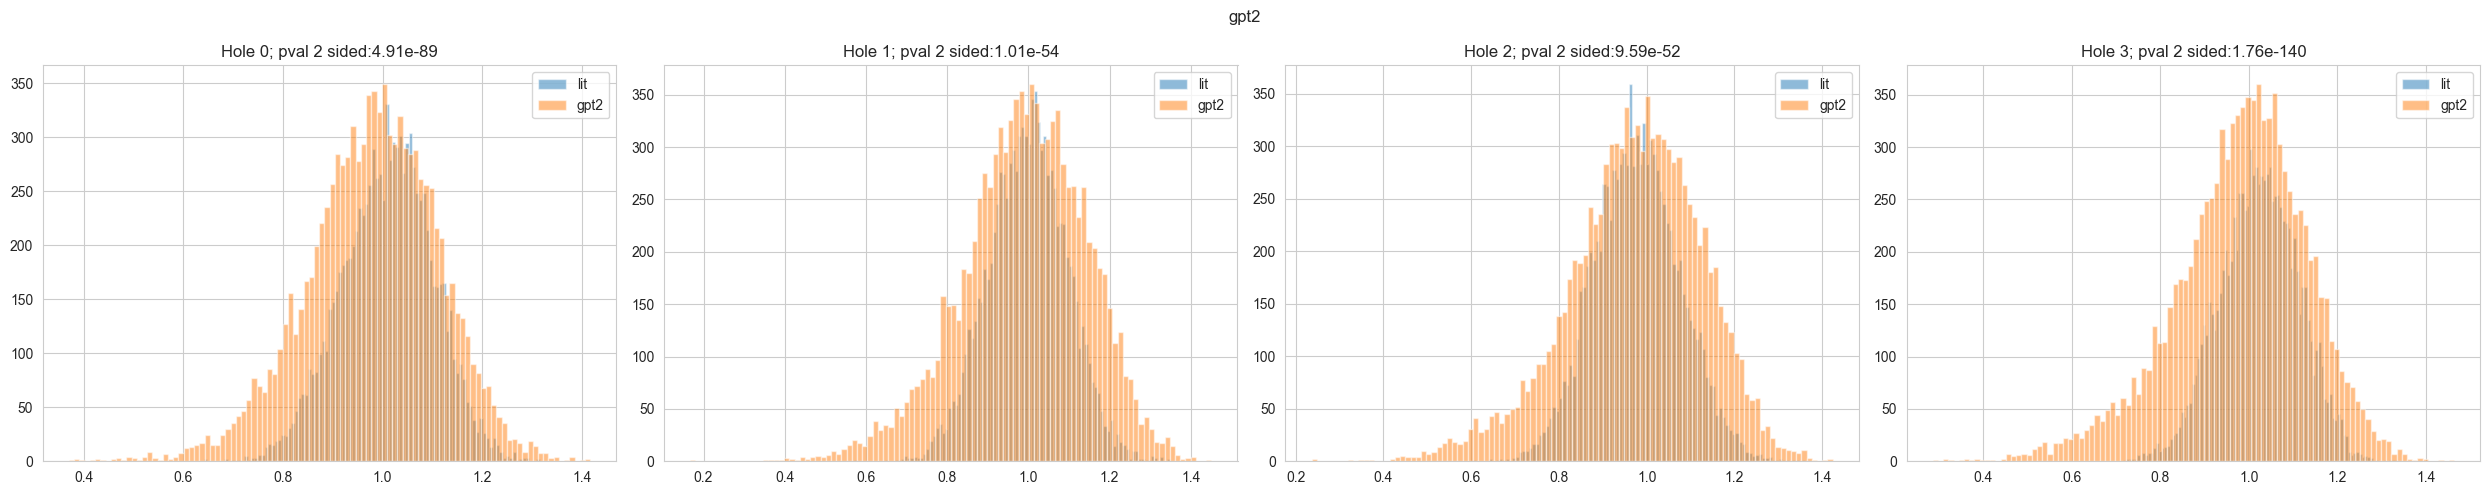

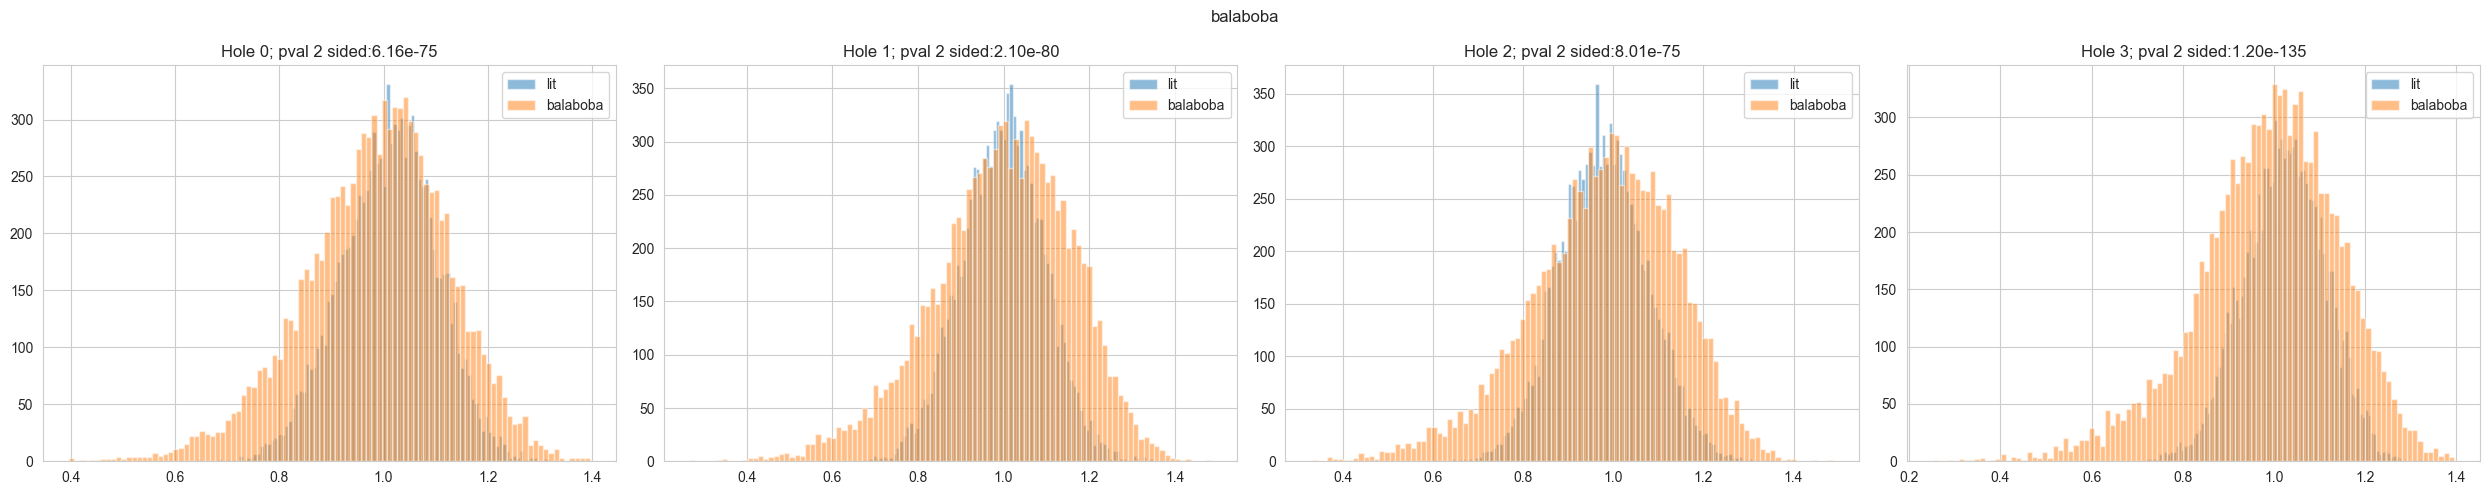

In [18]:
part = 'word'
for bot in bot_names:
    fig, axs = plt.subplots(1, 4, figsize=(25, 5))
    fig.suptitle(bot)
    for i, ax in enumerate(axs.reshape(-1)):
        ax.hist(lit_ch[part][:,i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:,i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:,i], bot_ch[part][bot][:,i]).pvalue
        ax.set_title(f"Hole {i}; pval 2 sided:{pval:.2e}")
        ax.legend()
    plt.tight_layout()
    plt.show()

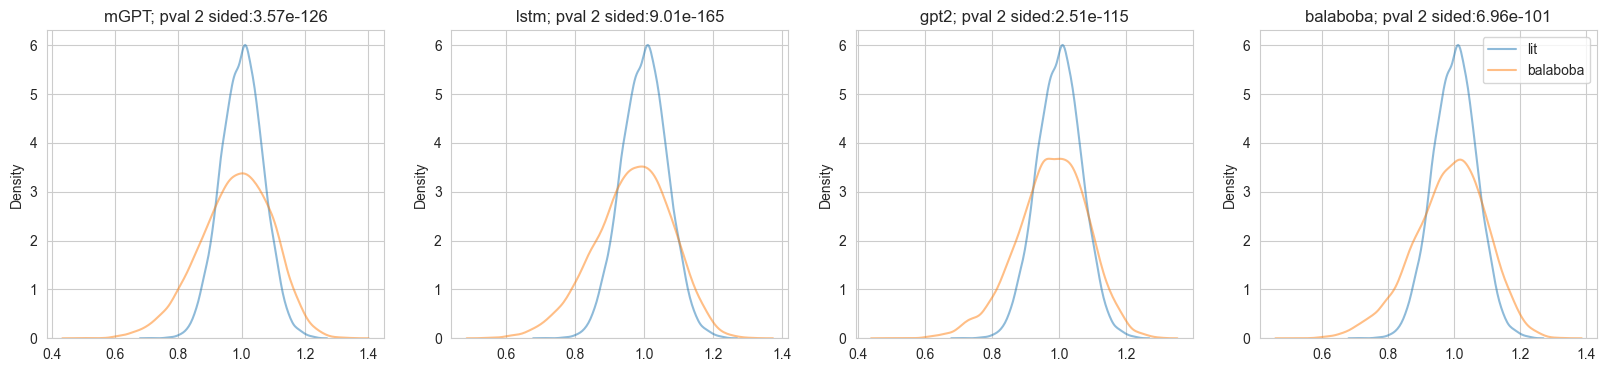

In [19]:
part = 'word'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,4], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,4], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,4], bot_ch[part][bot][:,4]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Min dist to holes

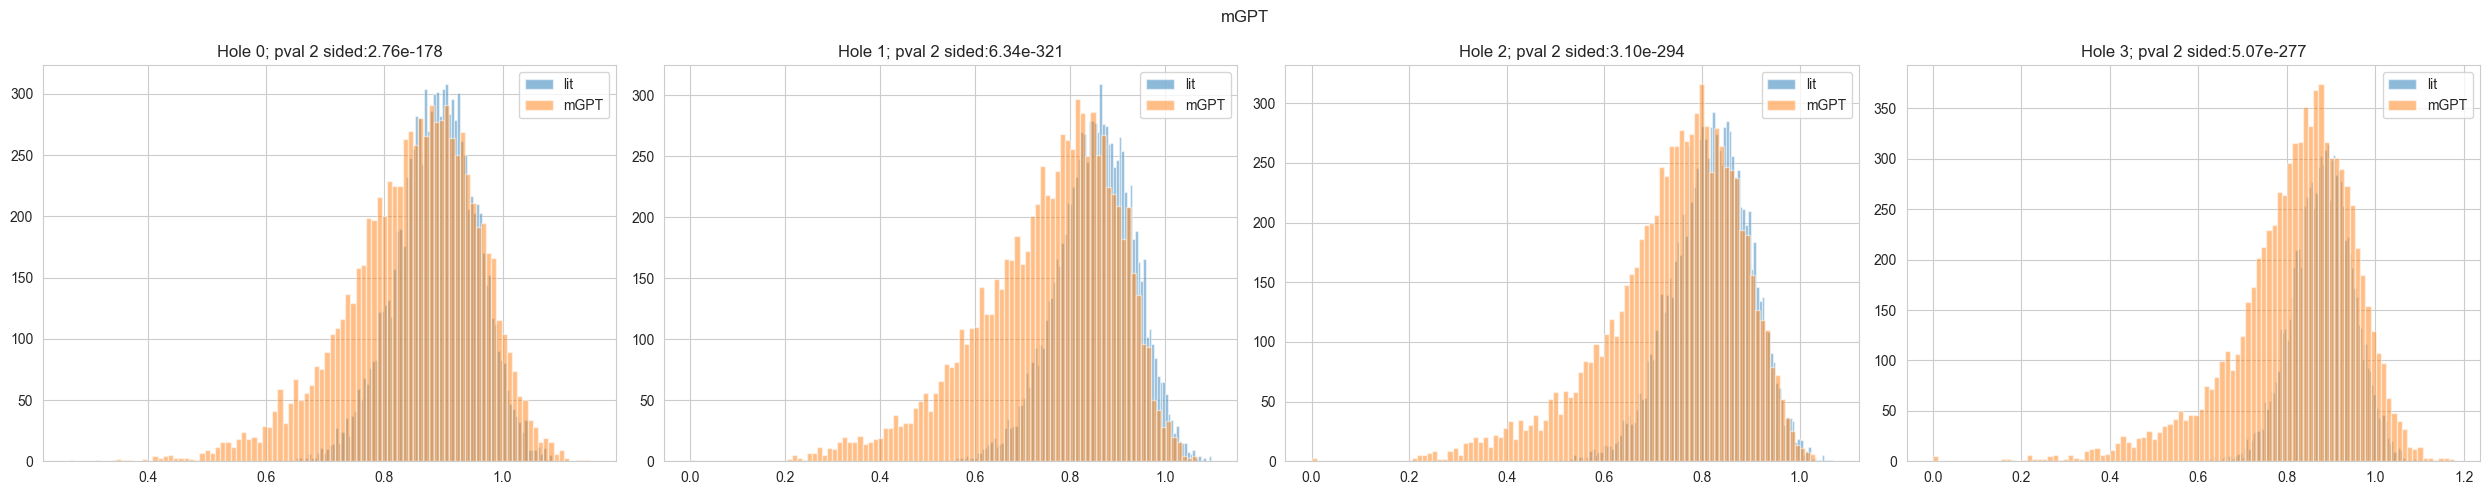

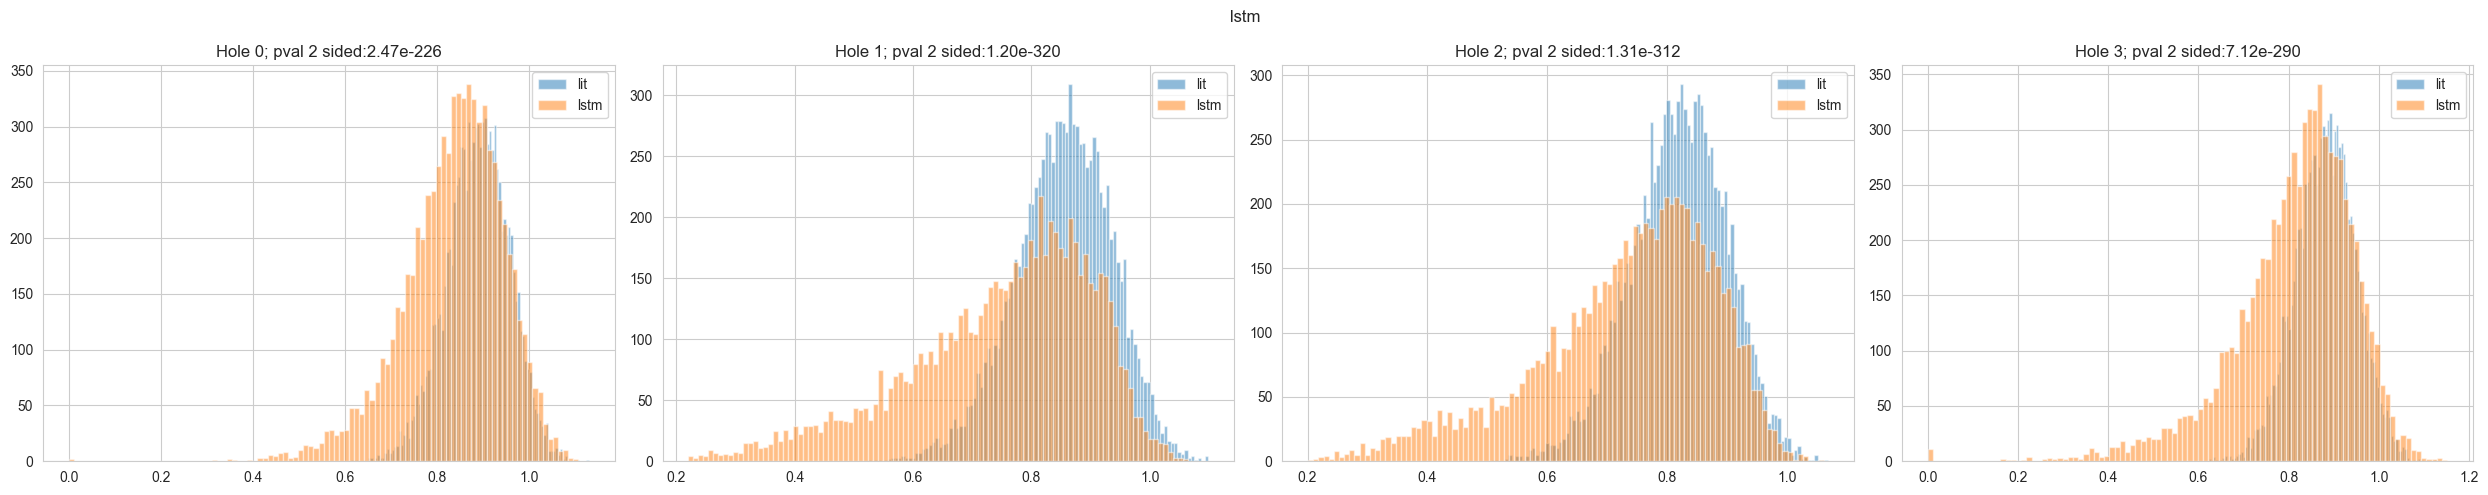

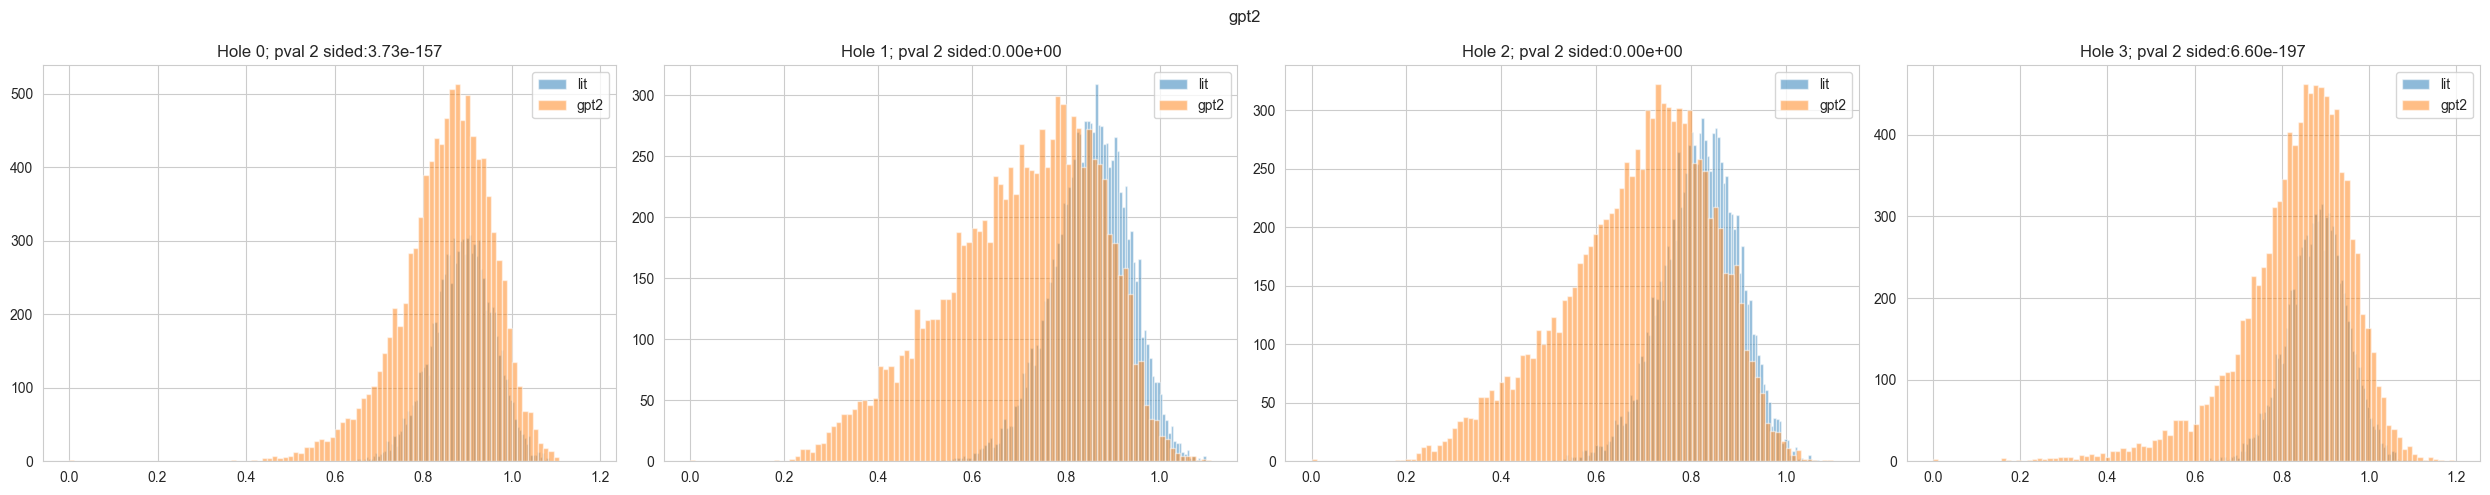

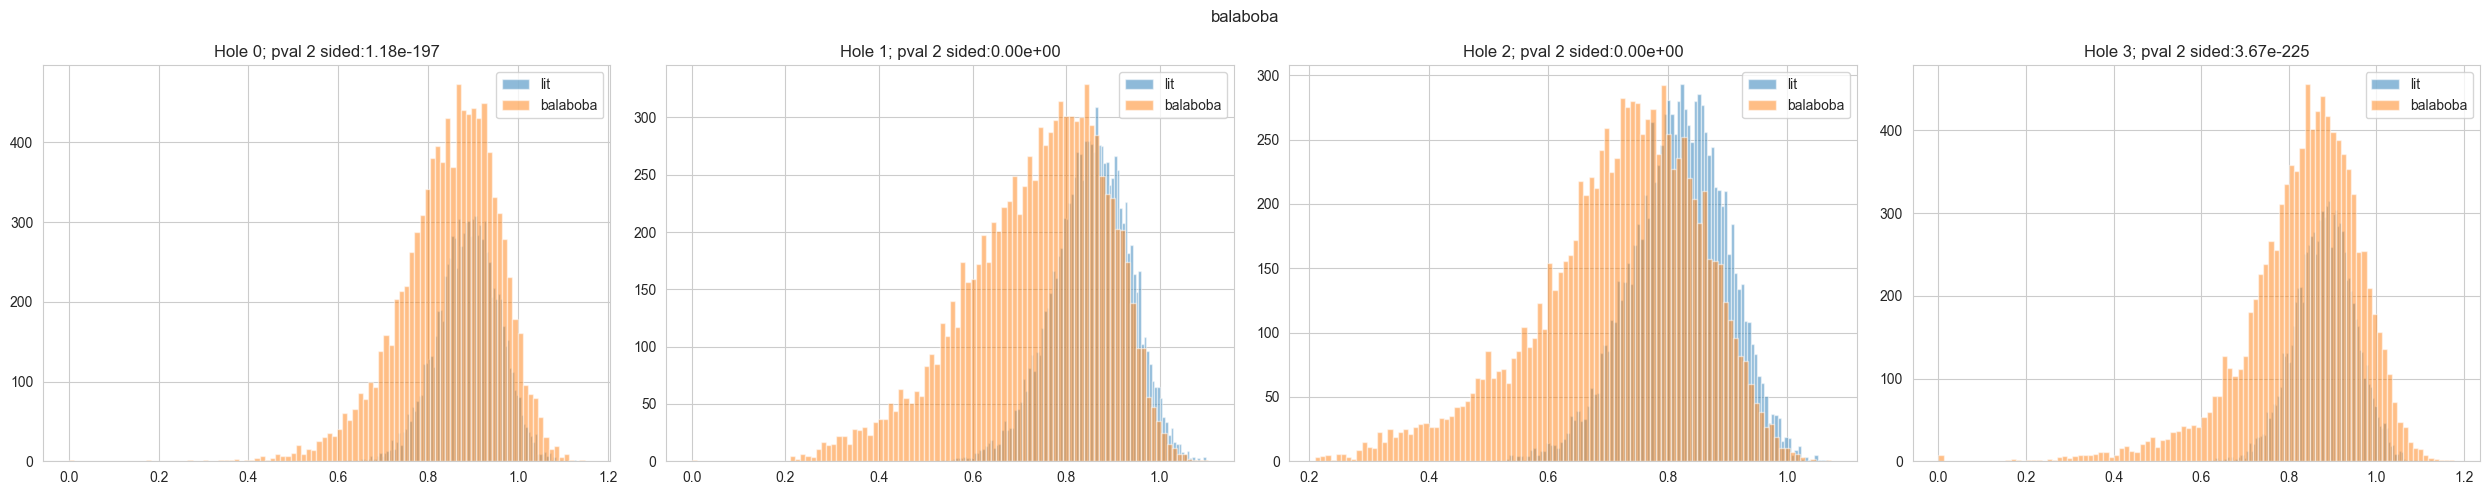

In [22]:
part = 'word'
for bot in bot_names:
    fig, axs = plt.subplots(1, 4, figsize=(25, 5))
    fig.suptitle(bot)
    for i, ax in enumerate(axs.reshape(-1)):
        ax.hist(lit_ch[part][:,5 + i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:, 5 + i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:, 5 + i], bot_ch[part][bot][:, 5 + i]).pvalue
        ax.set_title(f"Hole {i}; pval 2 sided:{pval:.2e}")
        ax.legend()
    plt.tight_layout()
    plt.show()

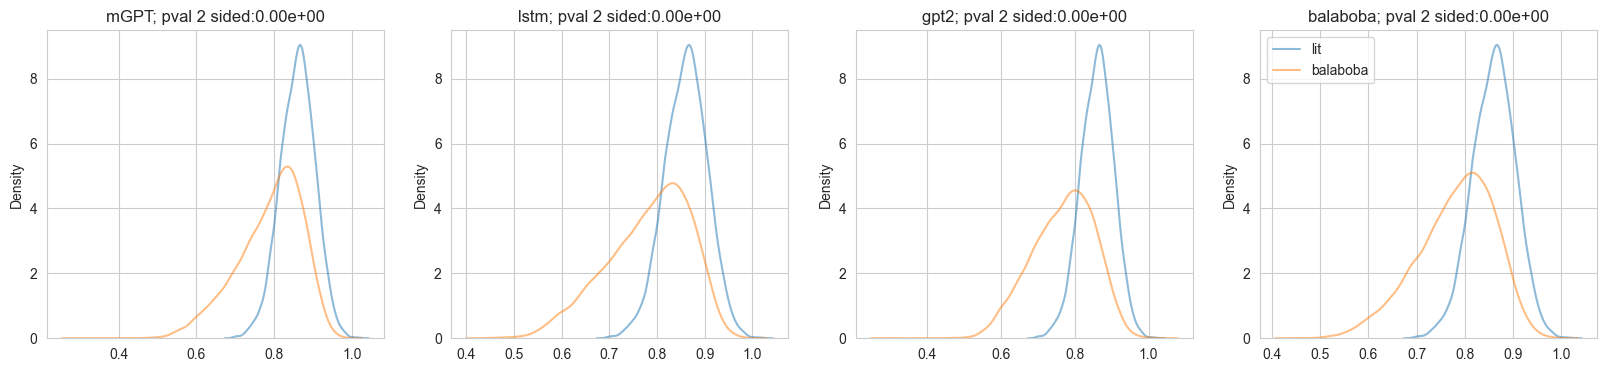

In [21]:
part = 'word'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,9], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,9], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,9], bot_ch[part][bot][:,9]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Max dist to holes

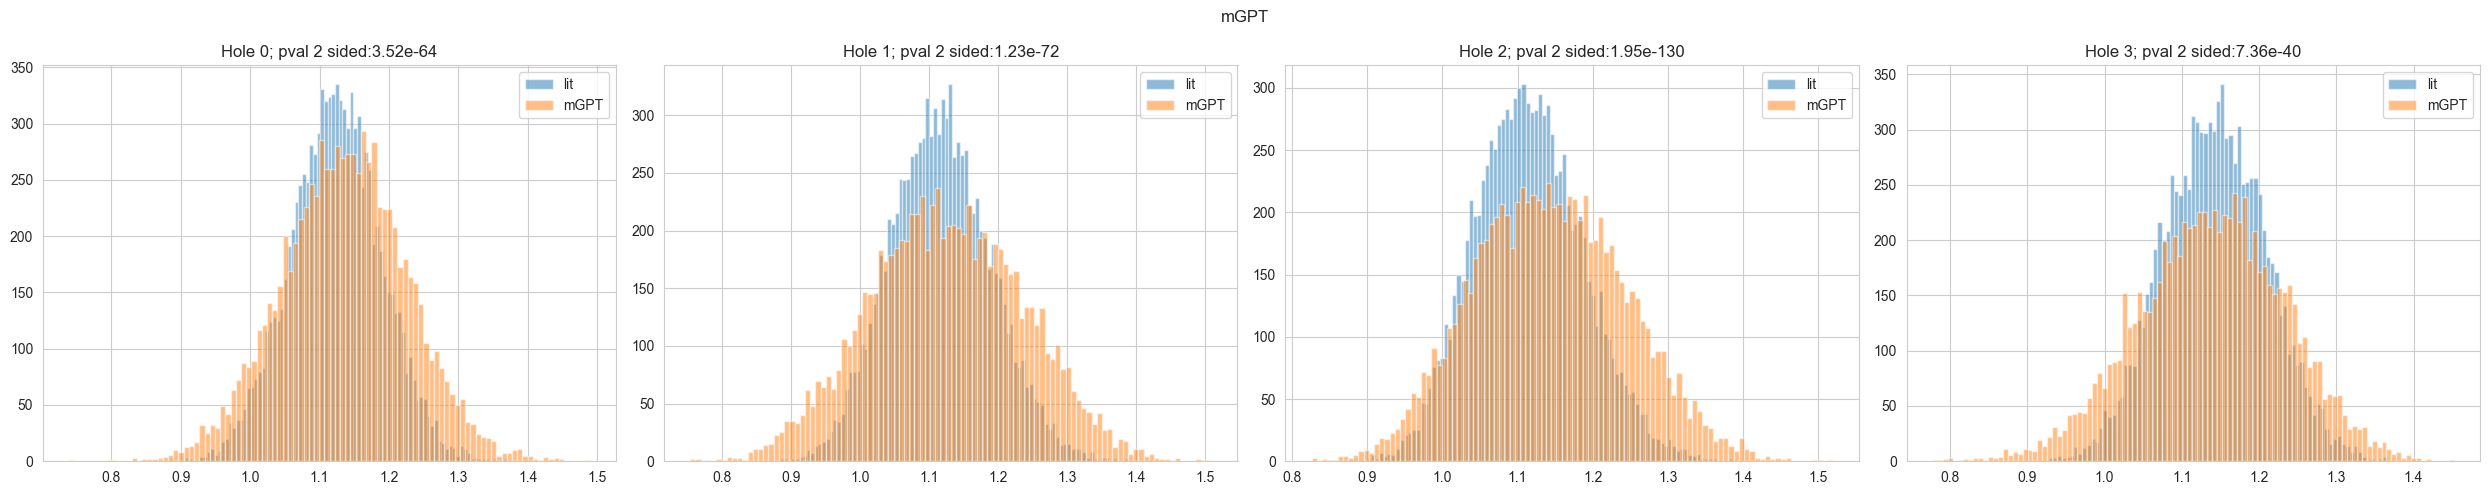

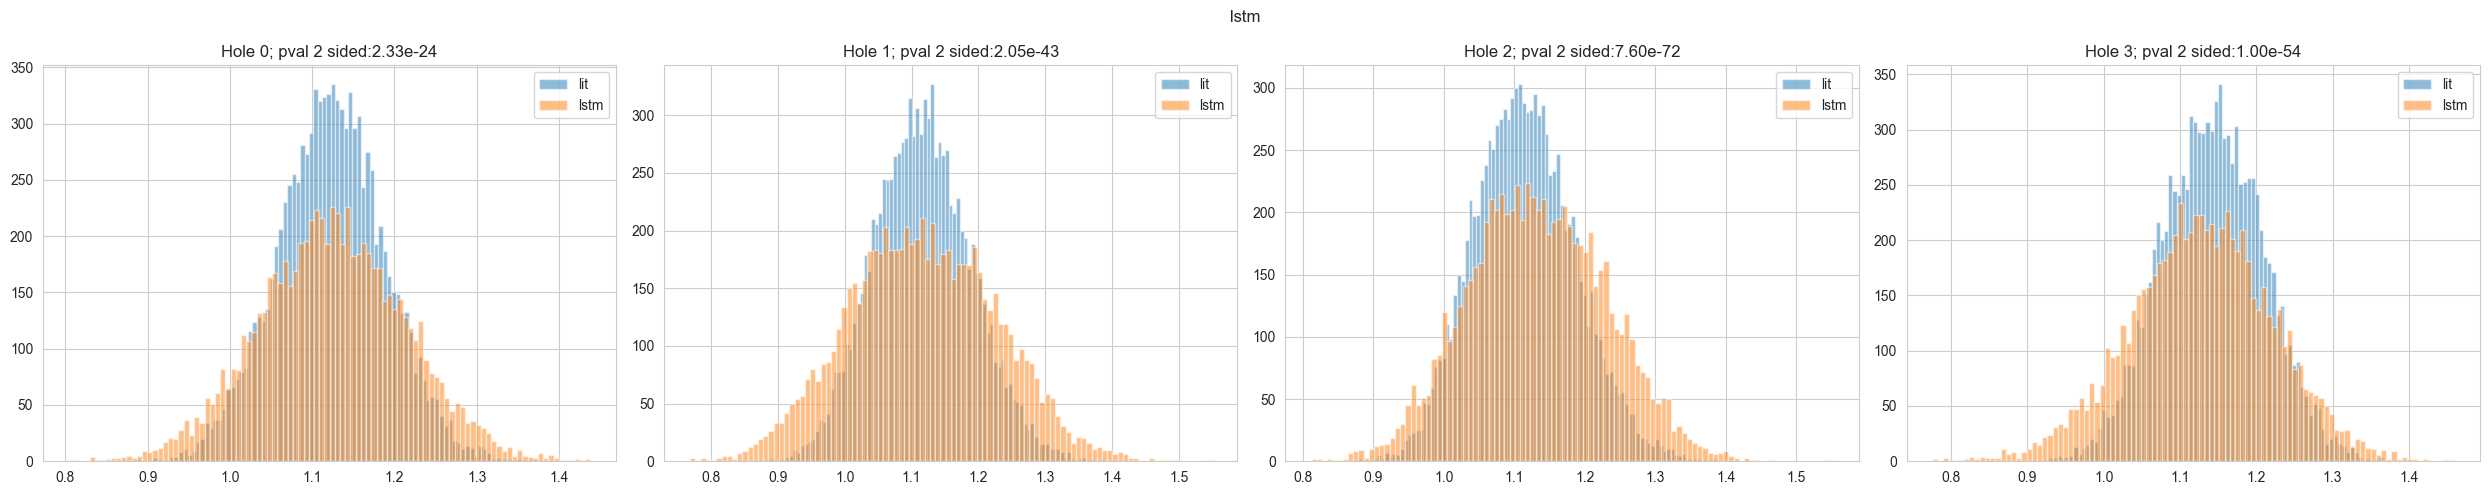

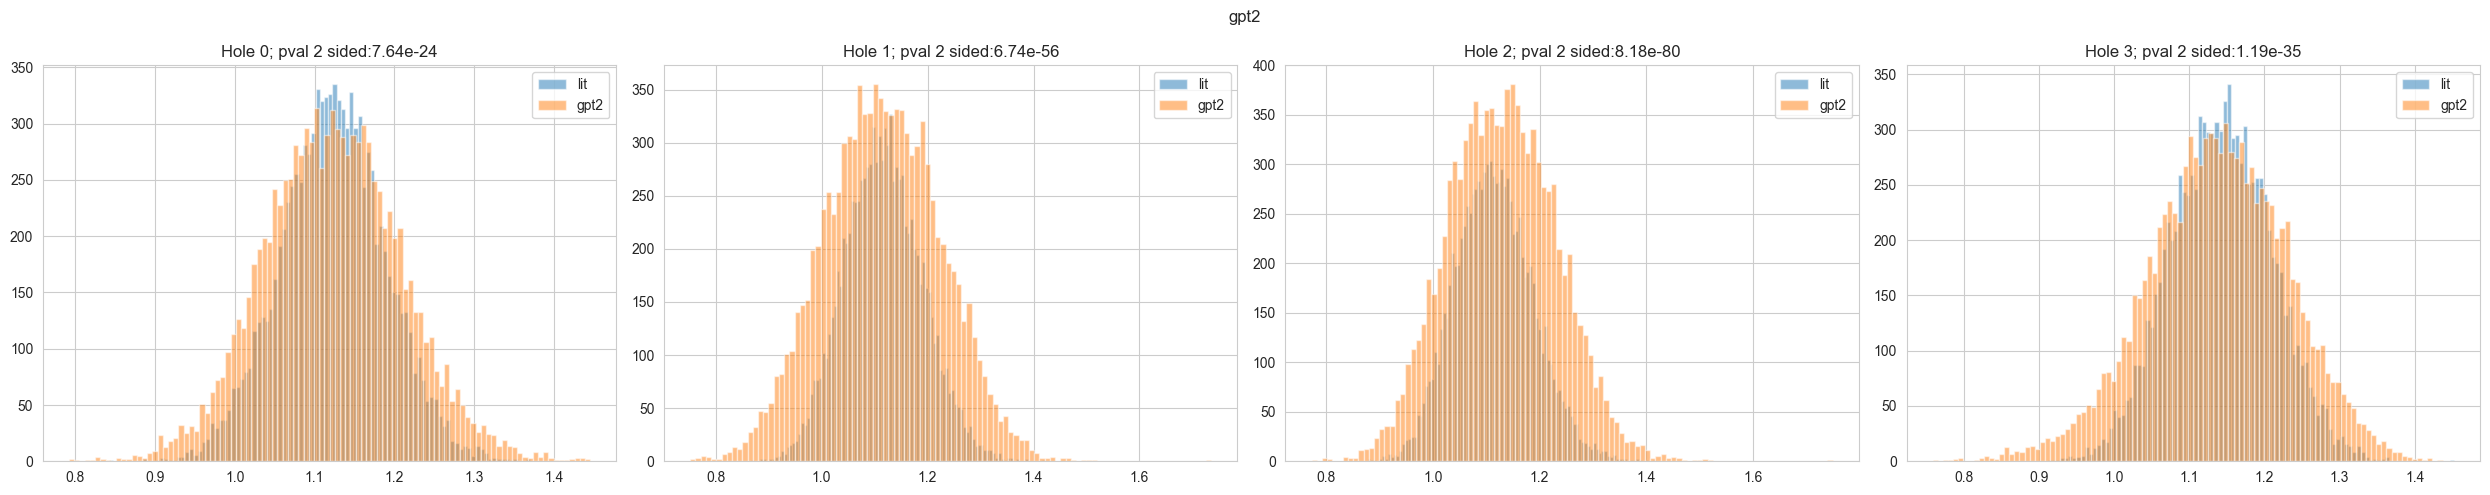

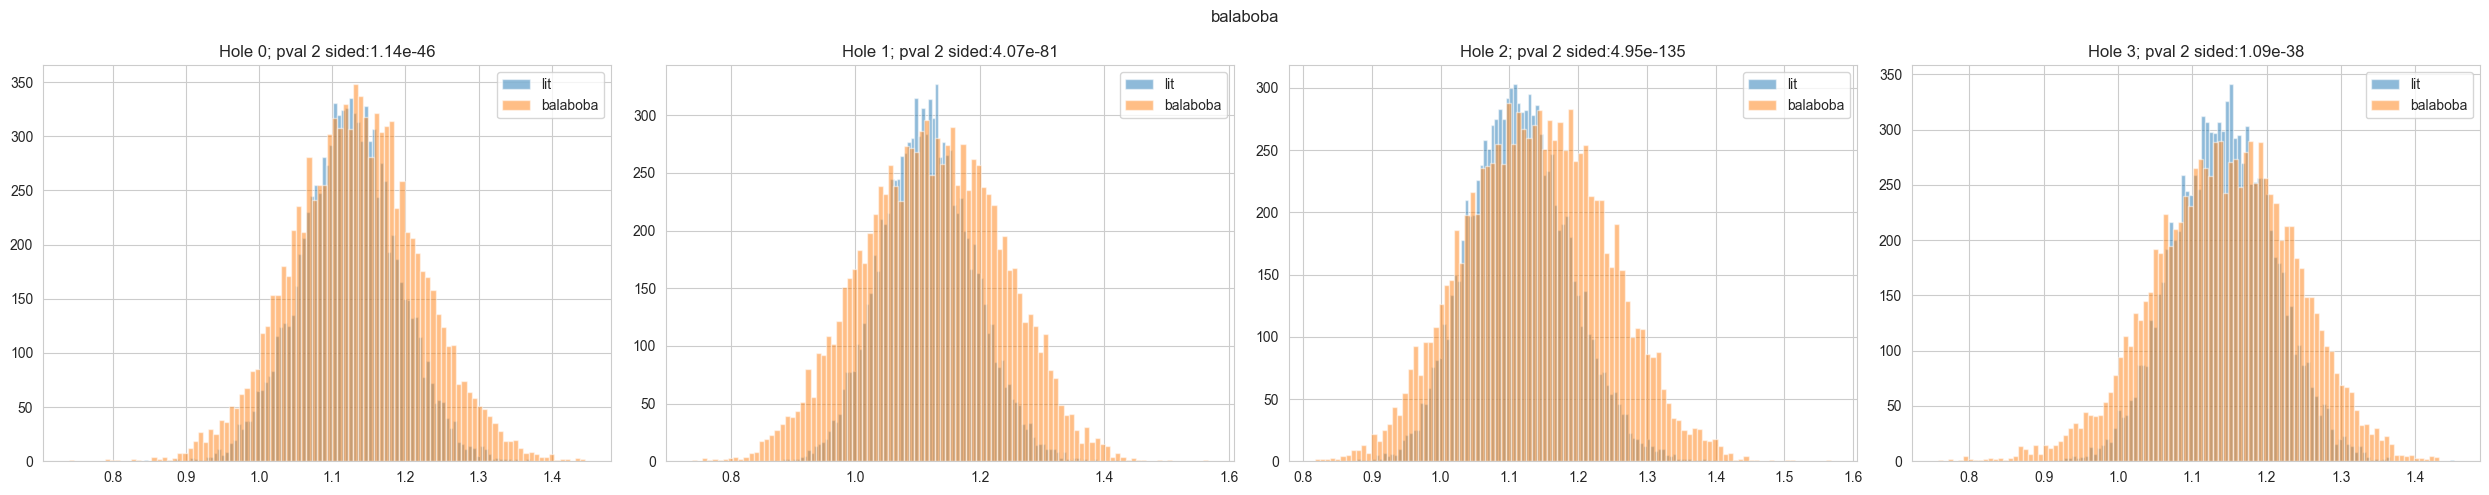

In [23]:
part = 'word'
for bot in bot_names:
    fig, axs = plt.subplots(1, 4, figsize=(25, 5))
    fig.suptitle(bot)
    for i, ax in enumerate(axs.reshape(-1)):
        ax.hist(lit_ch[part][:,10 + i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:, 10 + i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:, 10 + i], bot_ch[part][bot][:, 10 + i]).pvalue
        ax.set_title(f"Hole {i}; pval 2 sided:{pval:.2e}")
        ax.legend()
    plt.tight_layout()
    plt.show()

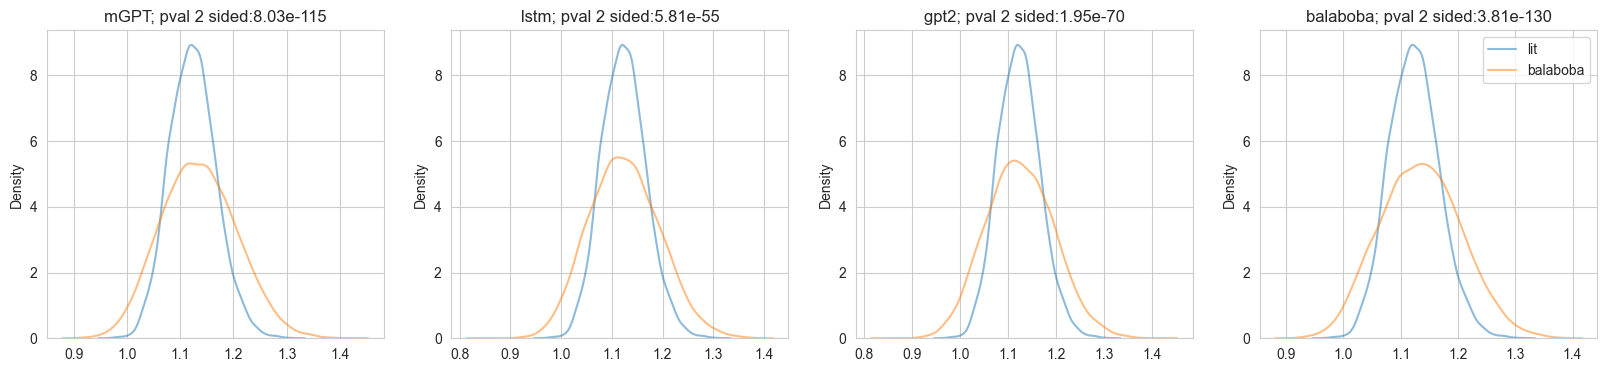

In [24]:
part = 'word'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,14], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,14], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,14], bot_ch[part][bot][:,14]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Closest holes

In [25]:
from collections import Counter
part = 'word'

print("LIT:", Counter(np.array(lit_ch[part][:, -1], dtype=int)).most_common())
for bot in bot_names:
    print(bot, Counter(np.array(bot_ch[part][bot][:, -1], dtype=int)).most_common())

LIT: [(3, 5141), (2, 2891), (1, 1968)]
mGPT [(2, 3467), (3, 3407), (1, 1496), (0, 3)]
lstm [(3, 3195), (2, 2734), (1, 1441), (0, 4)]
gpt2 [(3, 4757), (2, 3920), (1, 1320), (0, 3)]
balaboba [(3, 4535), (2, 3898), (1, 1567)]


In [41]:
part = 'word'
hole_names = list(hole_embeddings[part].keys())
print([(i, hn) for i, hn in enumerate(hole_names)])

[(0, '310$483'), (1, '310$489'), (2, '310$499'), (3, '7$488')]


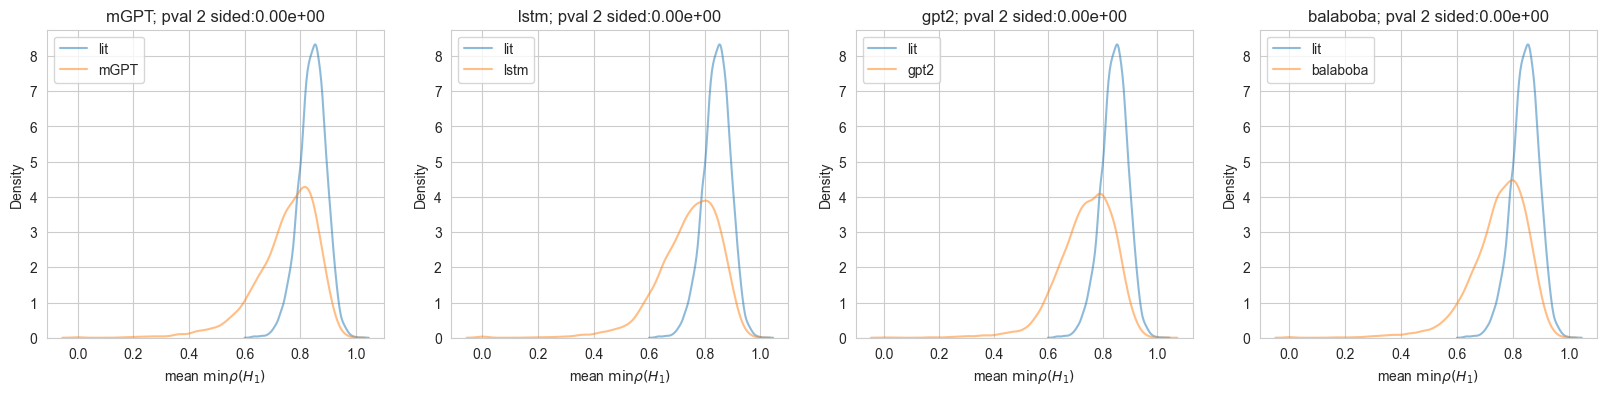

In [47]:
part = 'word'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_min_dist[part], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_min_dist[part][bot], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_min_dist[part], bot_min_dist[part][bot]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
    ax.legend()
    ax.set(xlabel=r'mean $\min\rho(H_1)$')
plt.show()

## Bigram

### Dist to centers

In [ ]:
for i in range(12):
    plt.hist(lit_ch['bigram'][:,i], label="lit", bins=100, alpha=.5);
    
    for bot in bot_names:
        plt.hist(bot_ch['bigram'][bot][:,i], label=bot, bins=100, alpha=.5);
    plt.legend()
    plt.show()

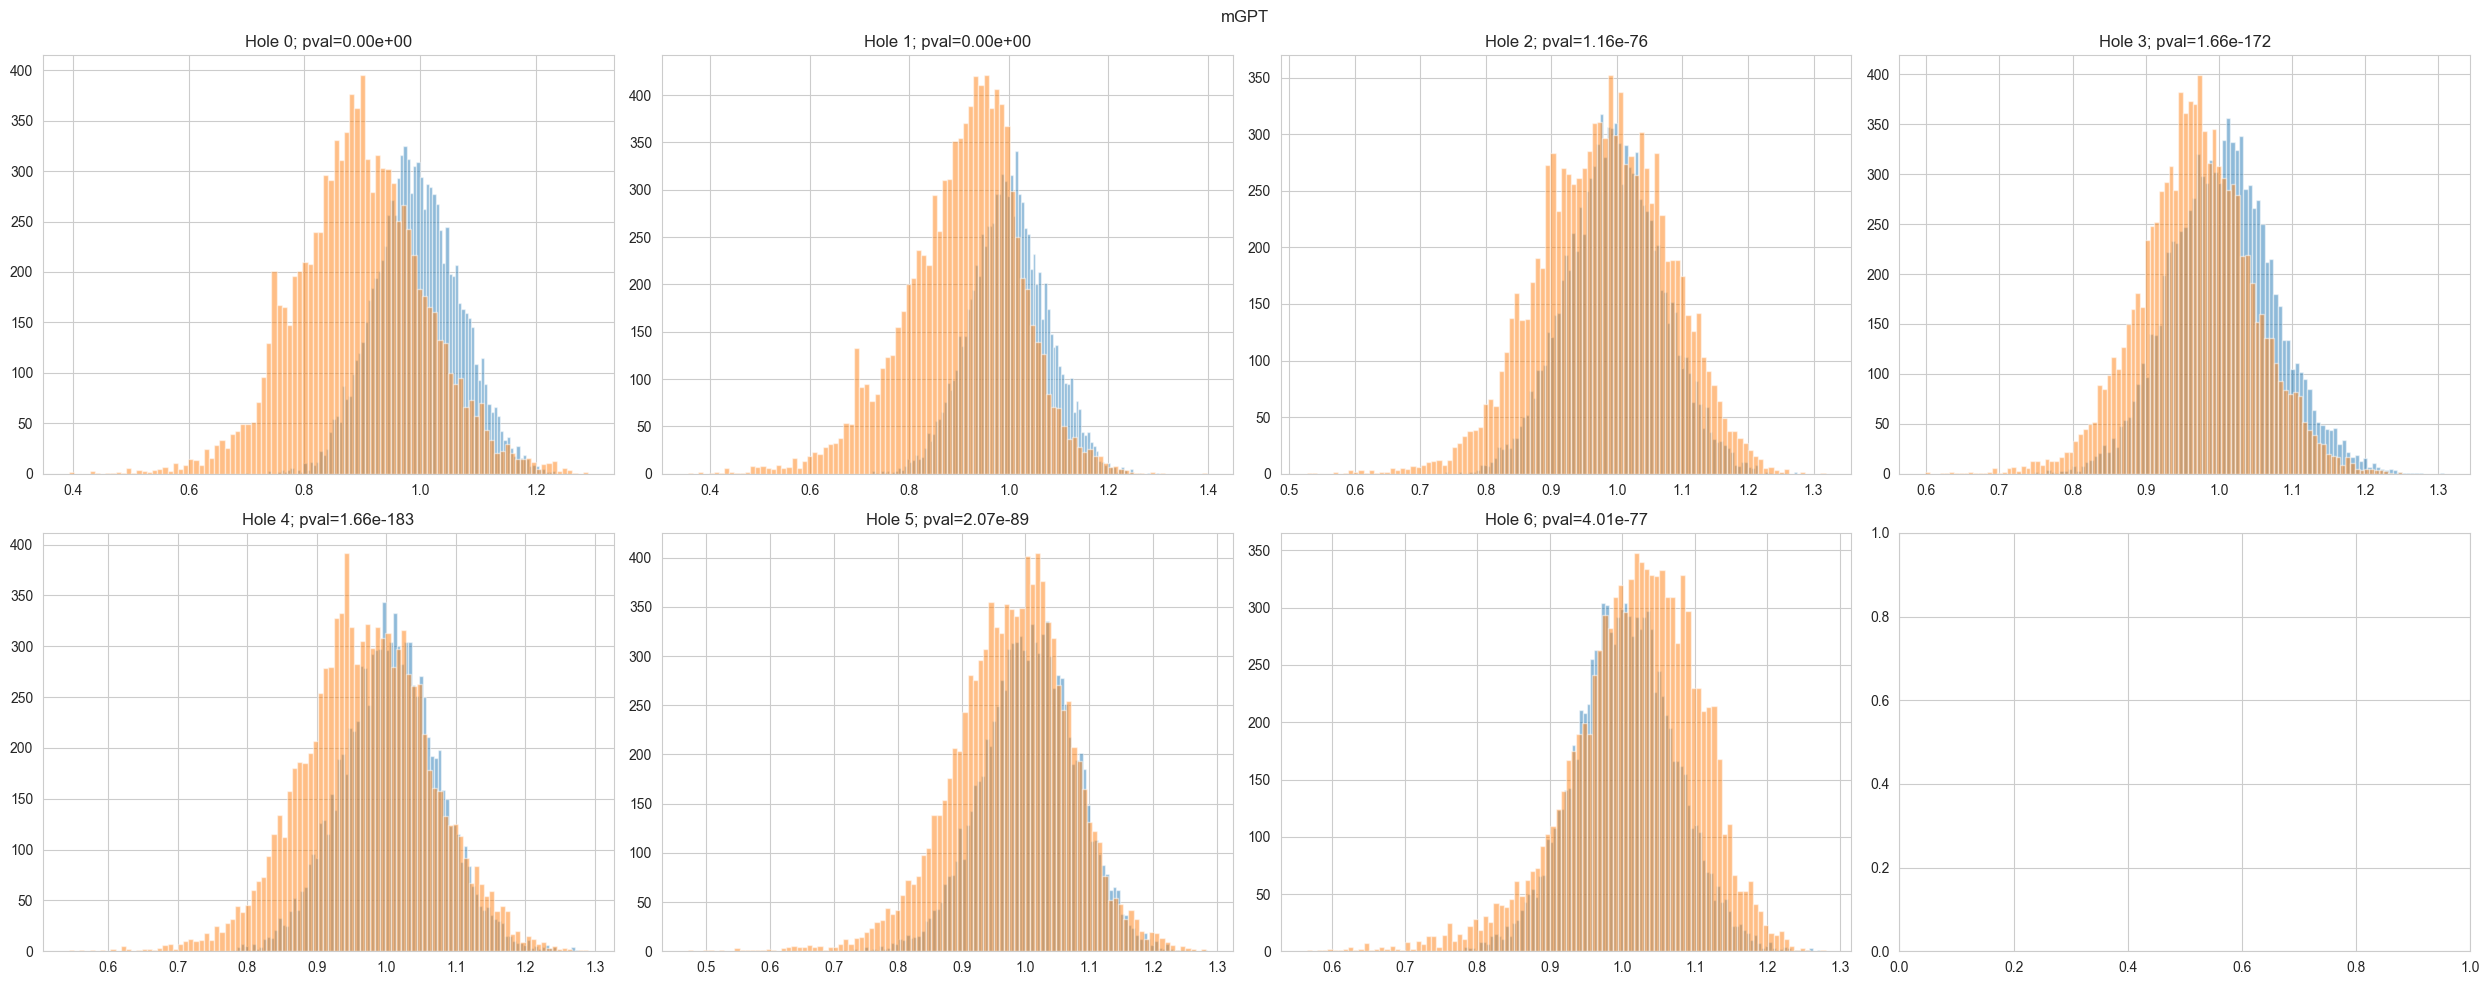

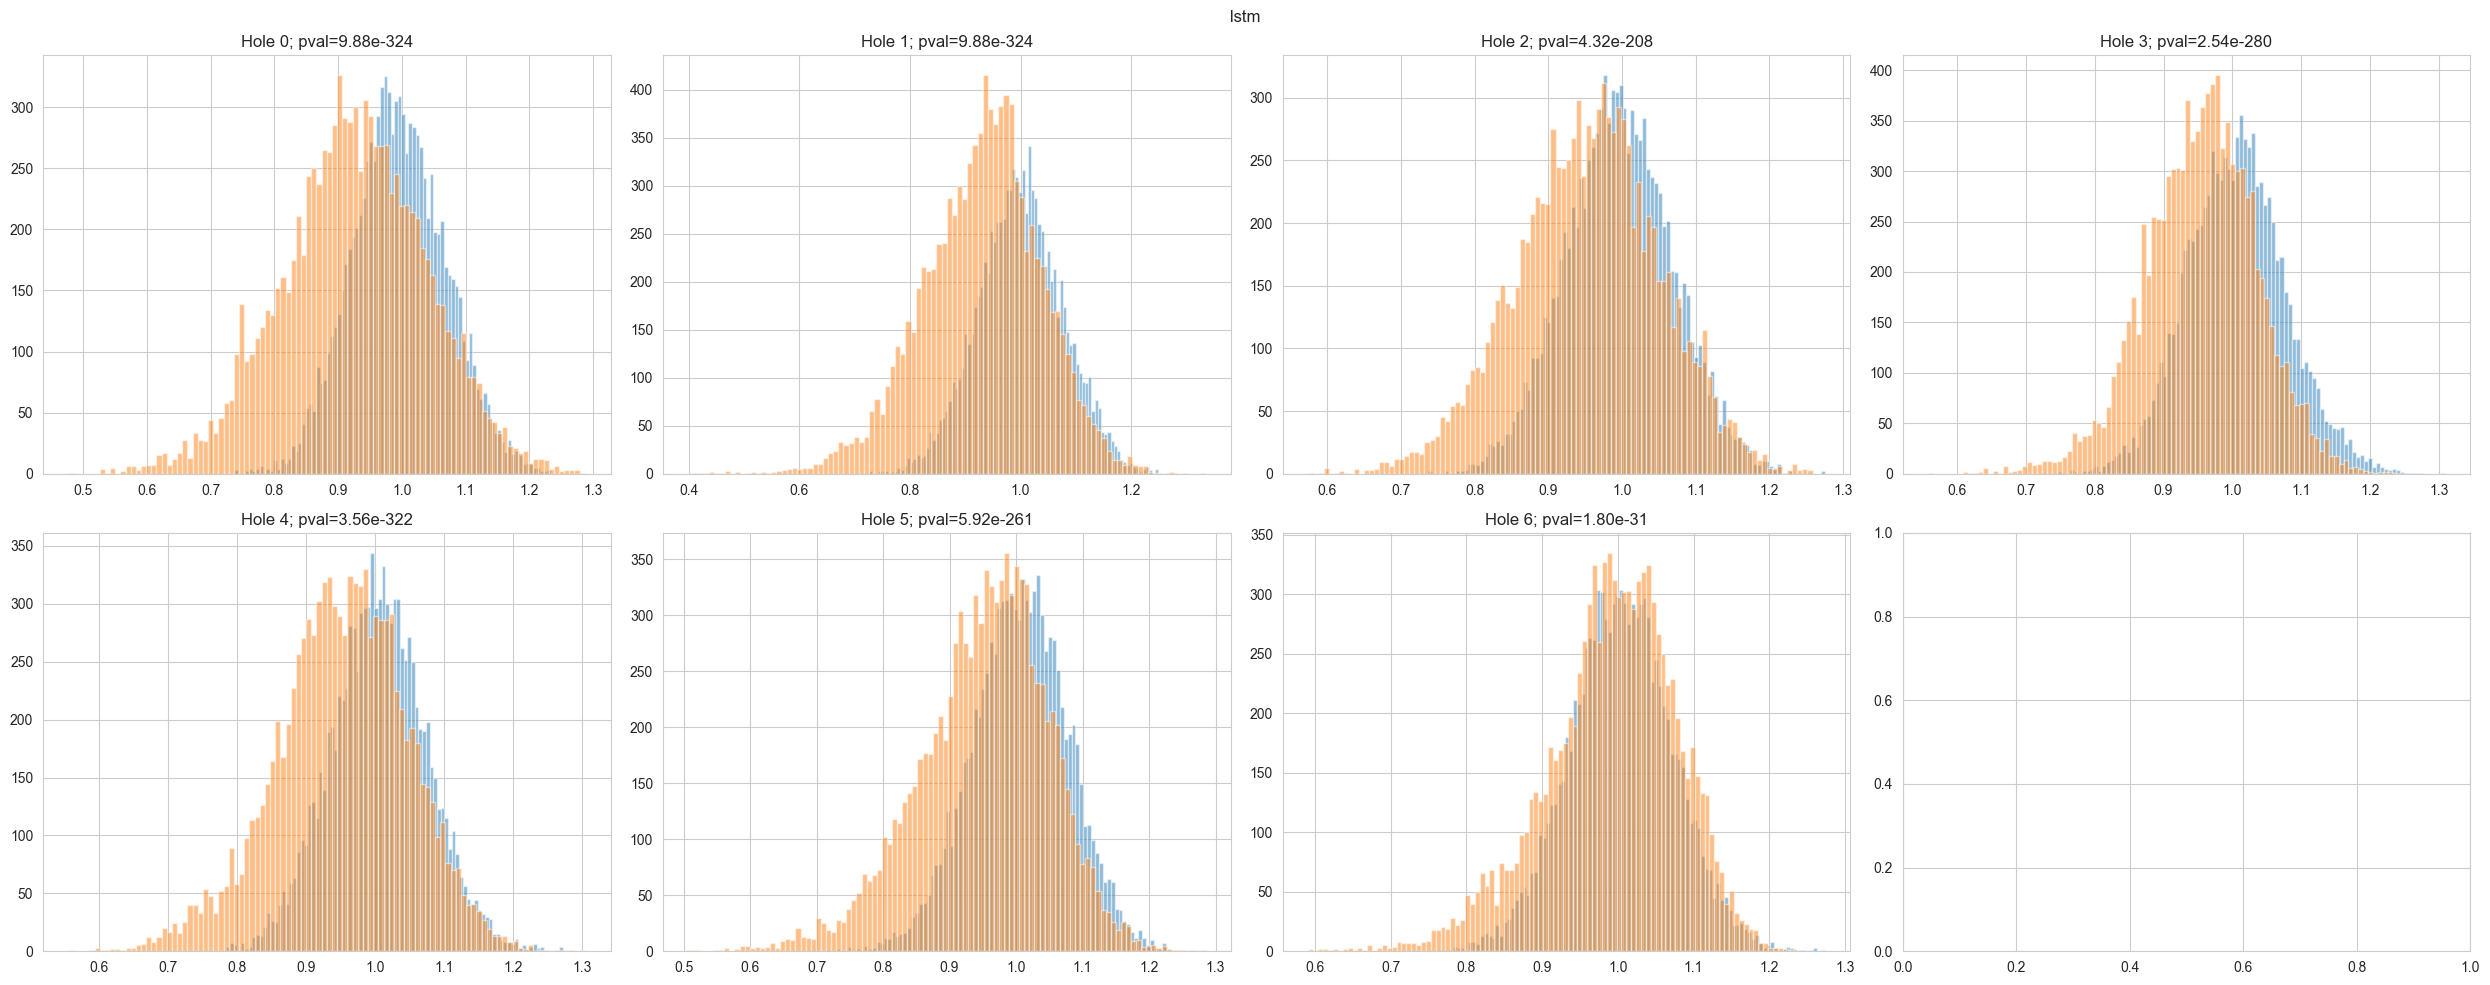

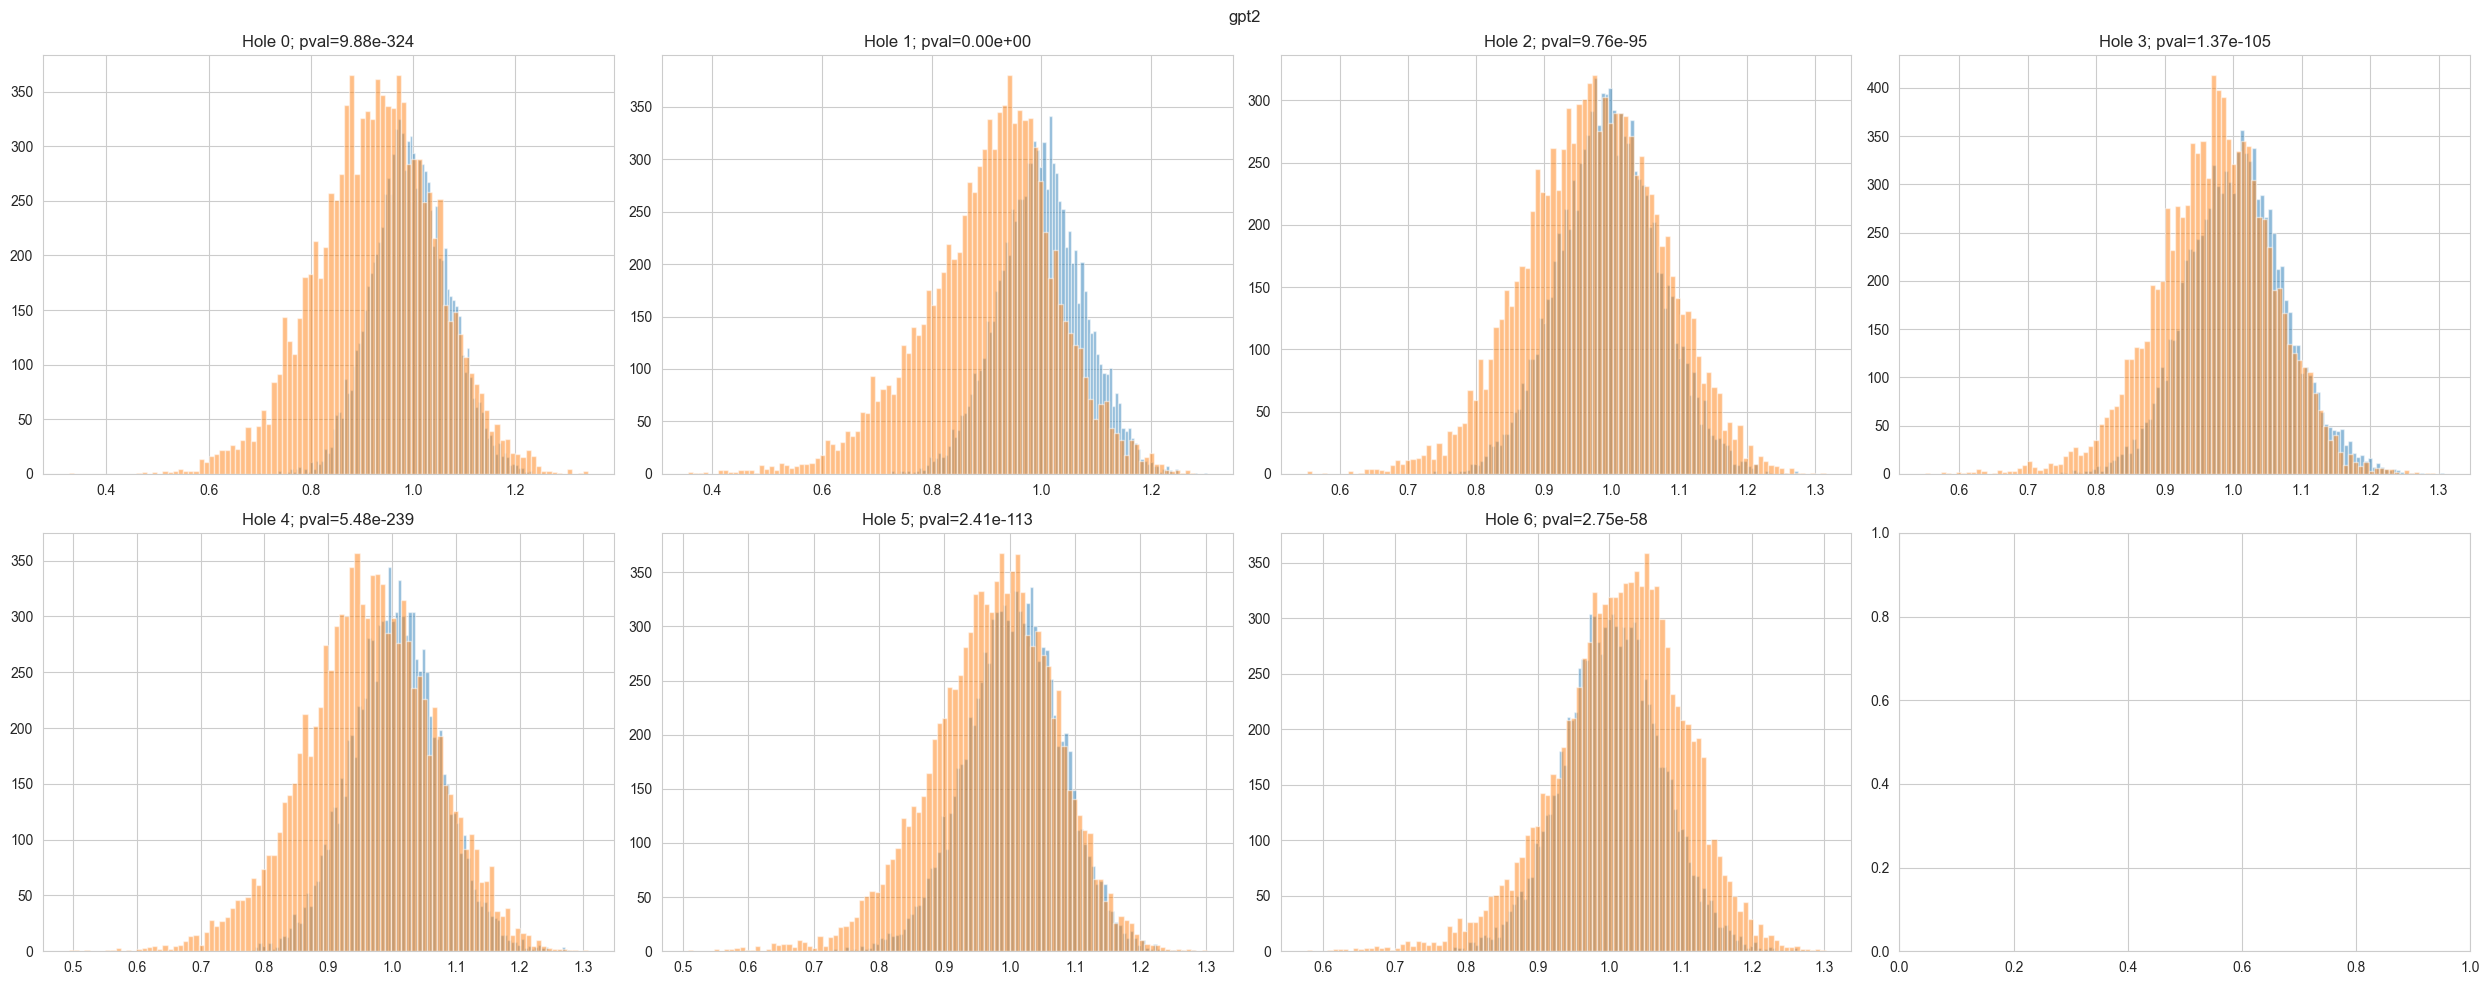

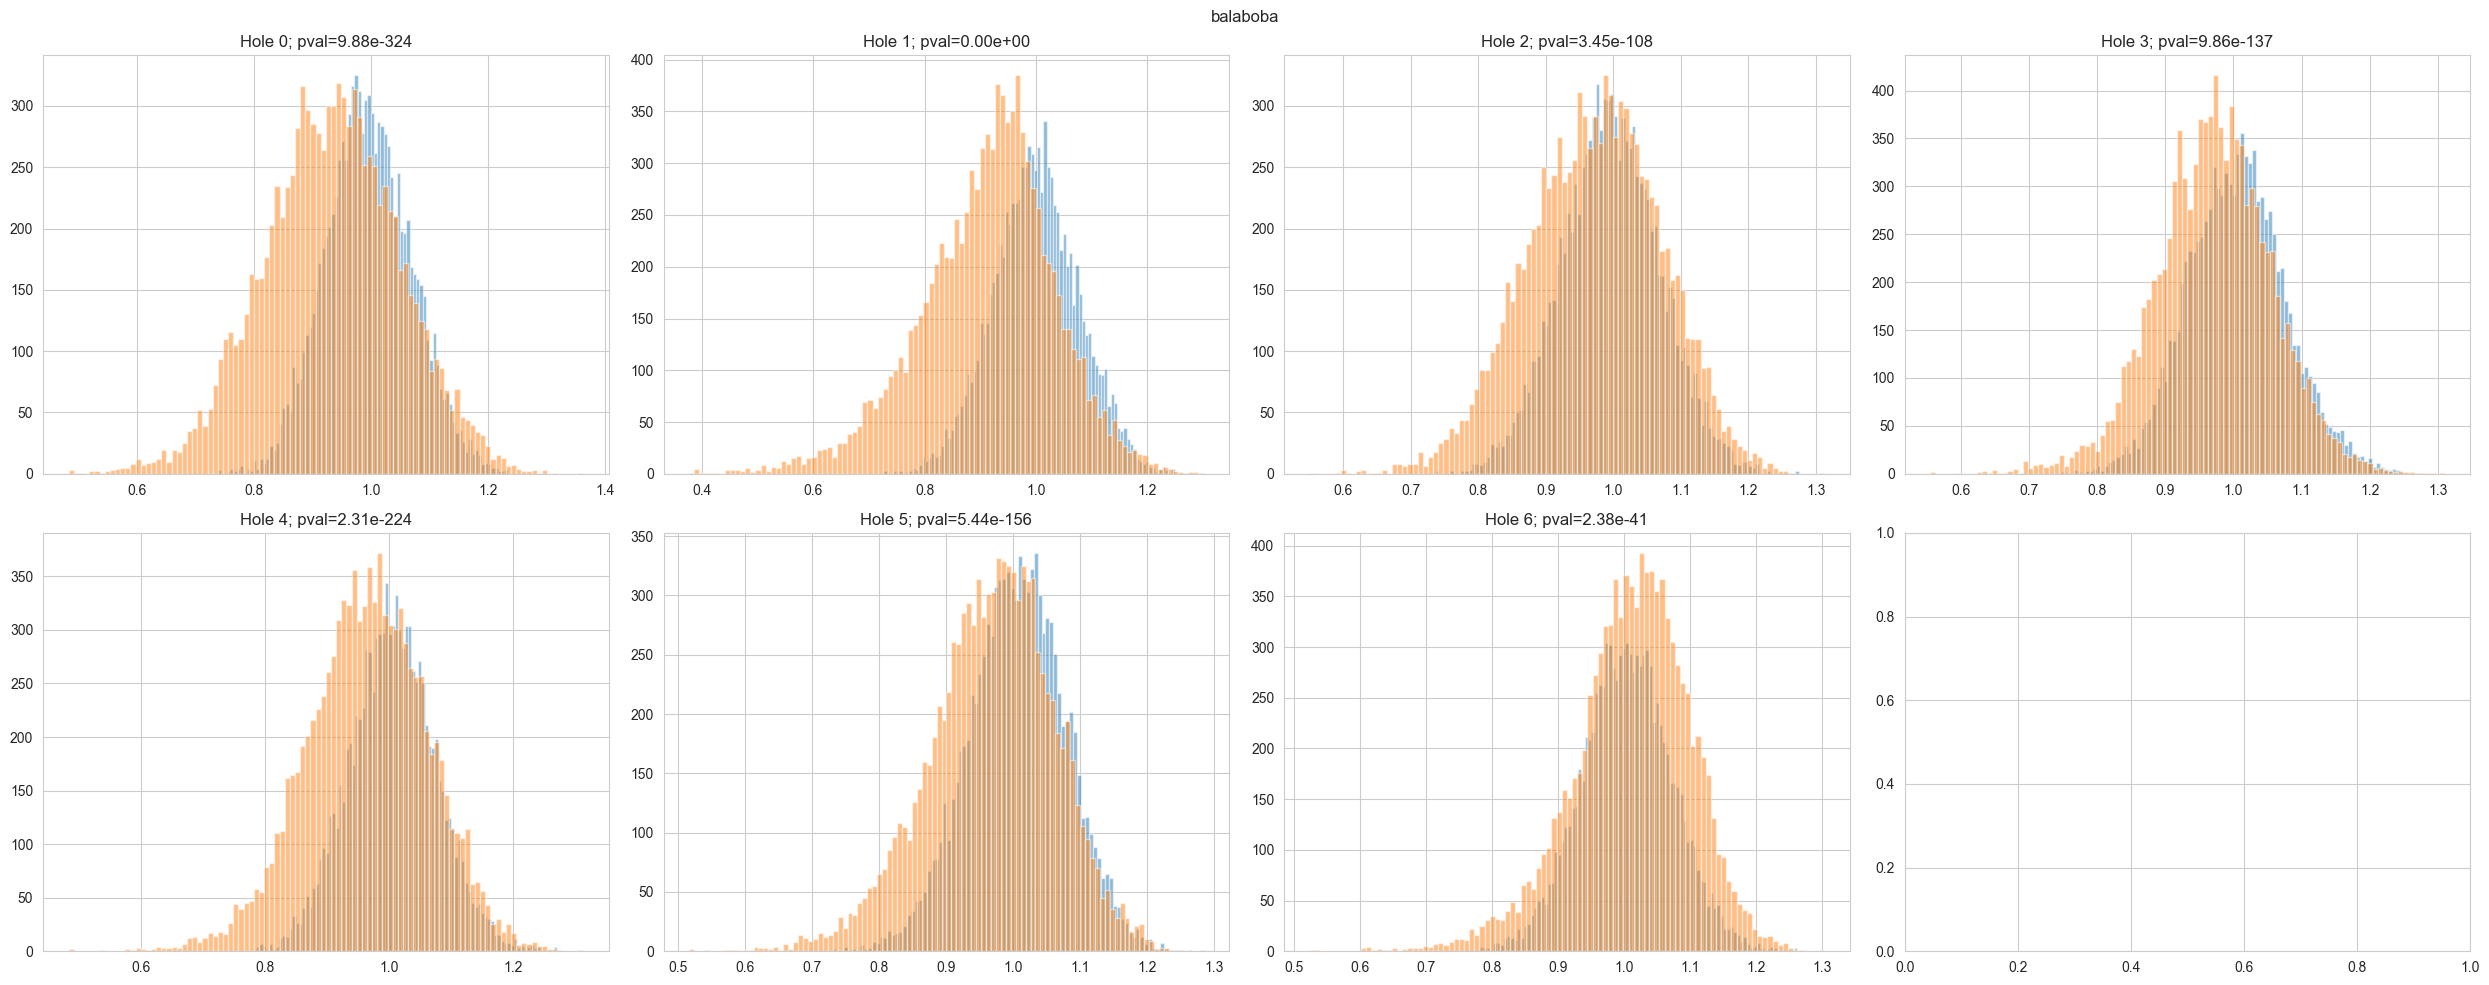

In [26]:
part = 'bigram'
for bot in bot_names:
    fig, axs = plt.subplots(2, 4, figsize=(25, 10))
    fig.suptitle(bot)
    for i, ax in enumerate(axs.reshape(-1)):
        if i >= 7: continue
        ax.hist(lit_ch[part][:,i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:,i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:,i], bot_ch[part][bot][:,i]).pvalue
        ax.set_title(f"Hole {i}; pval={pval:.2e}")
    plt.tight_layout()
    plt.show()

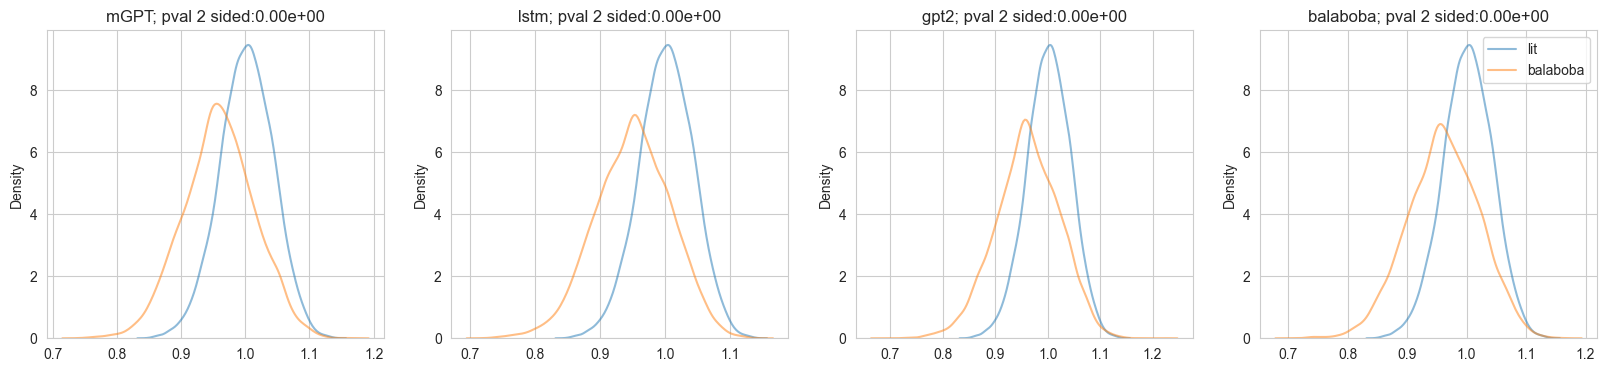

In [27]:
part = 'bigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,7], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,7], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,7], bot_ch[part][bot][:,7]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Min dist to holes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


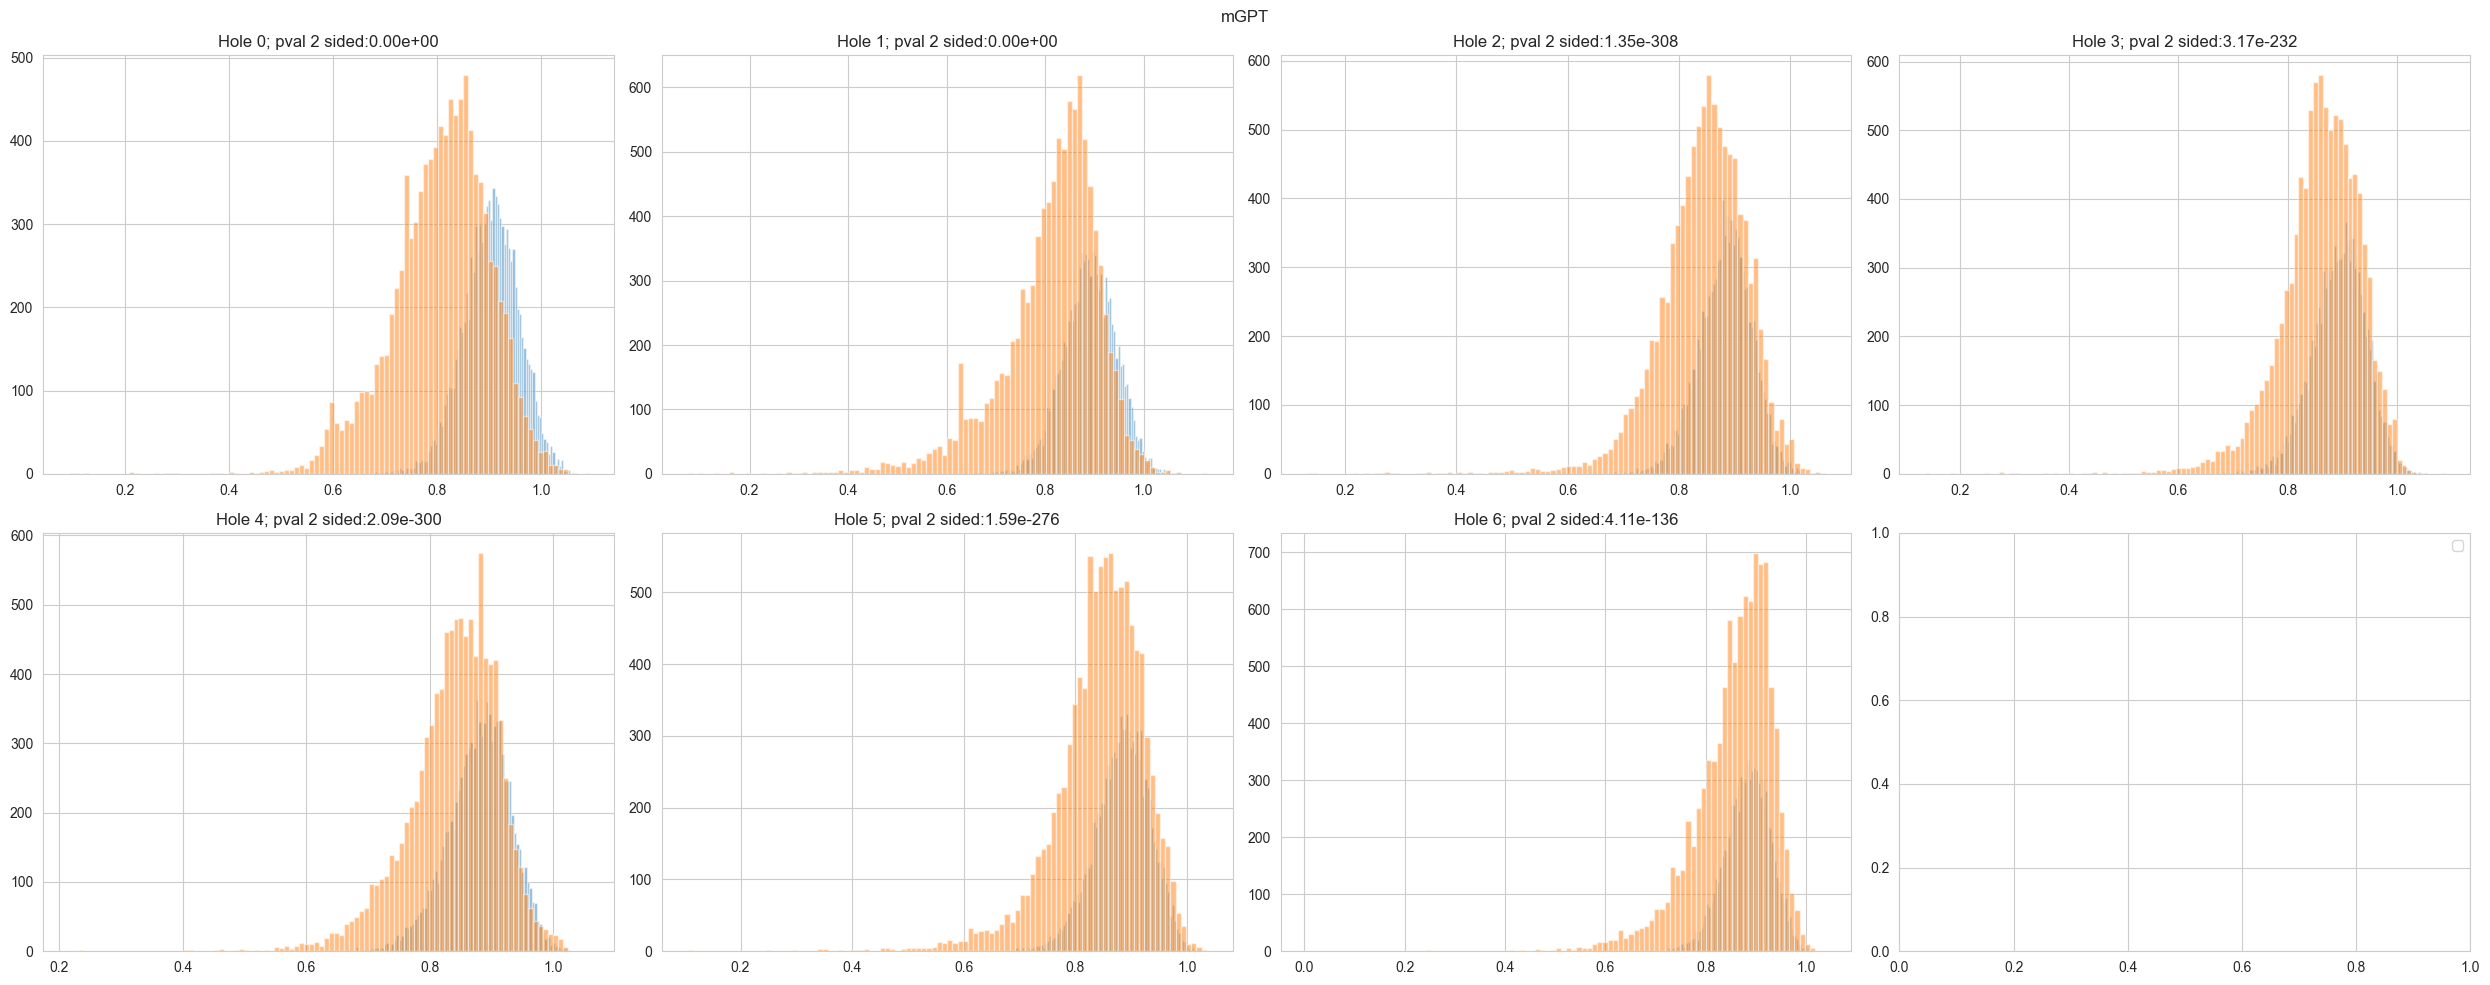

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


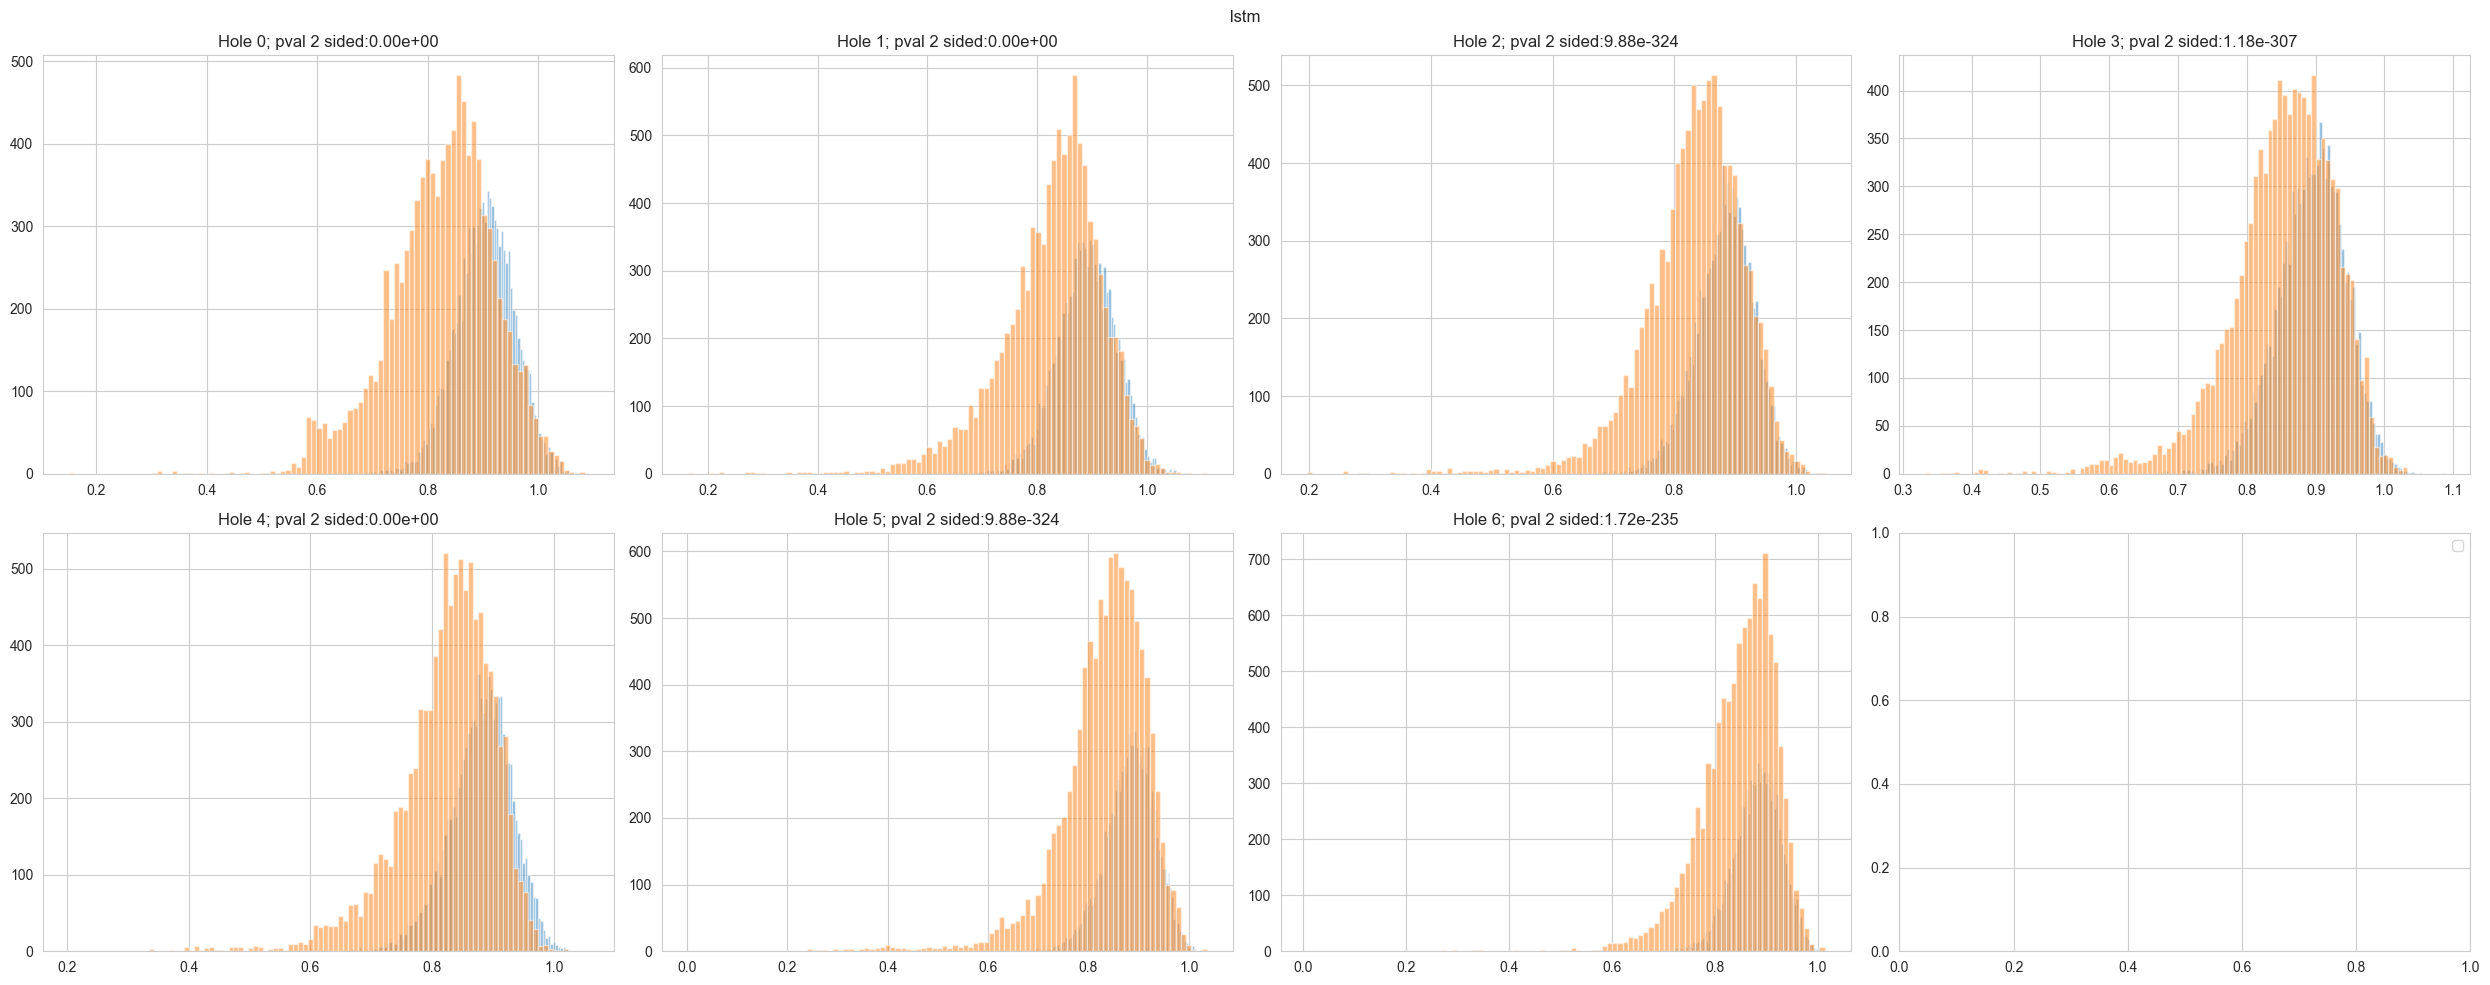

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


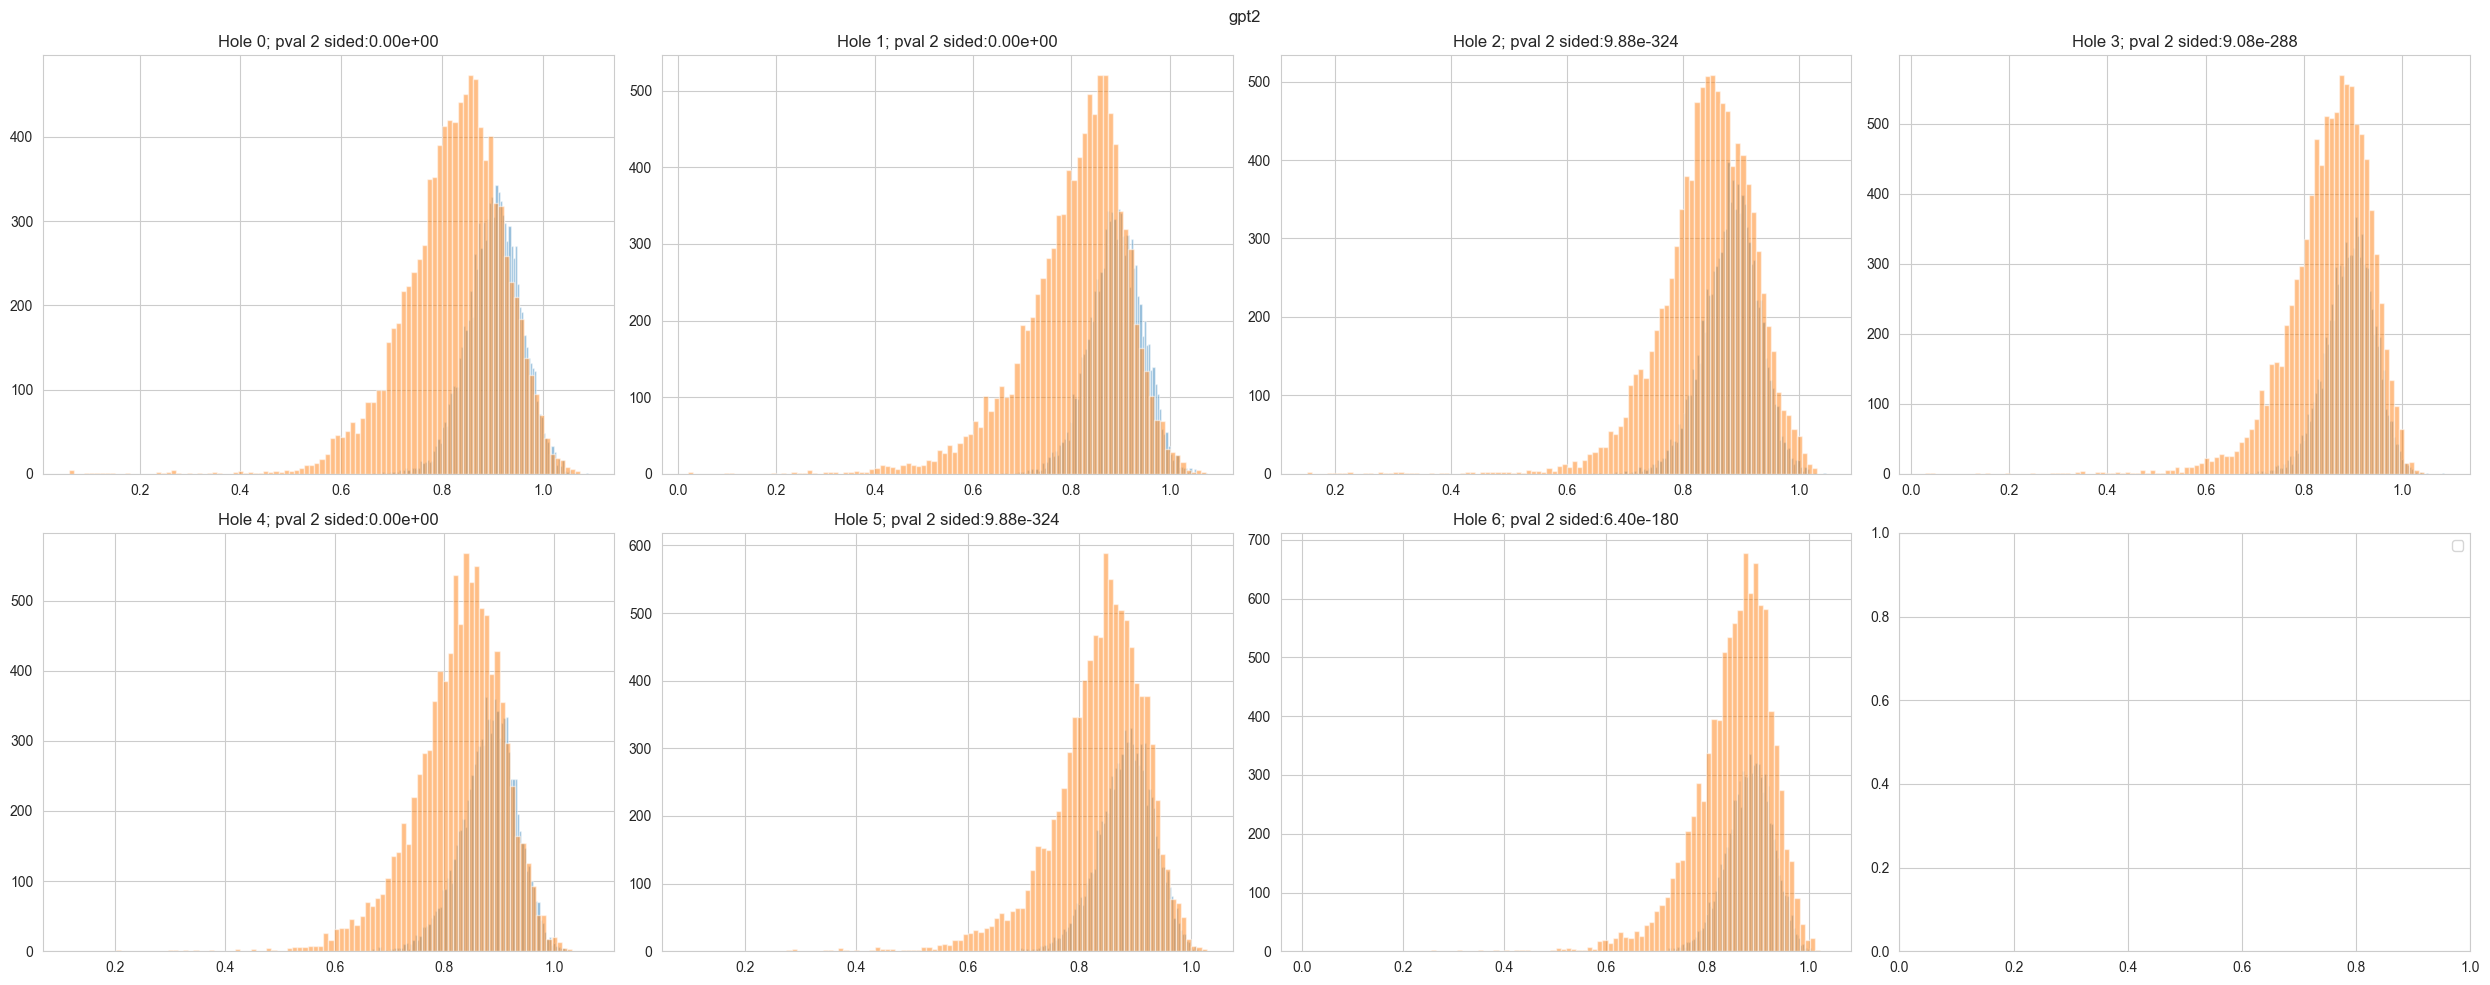

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


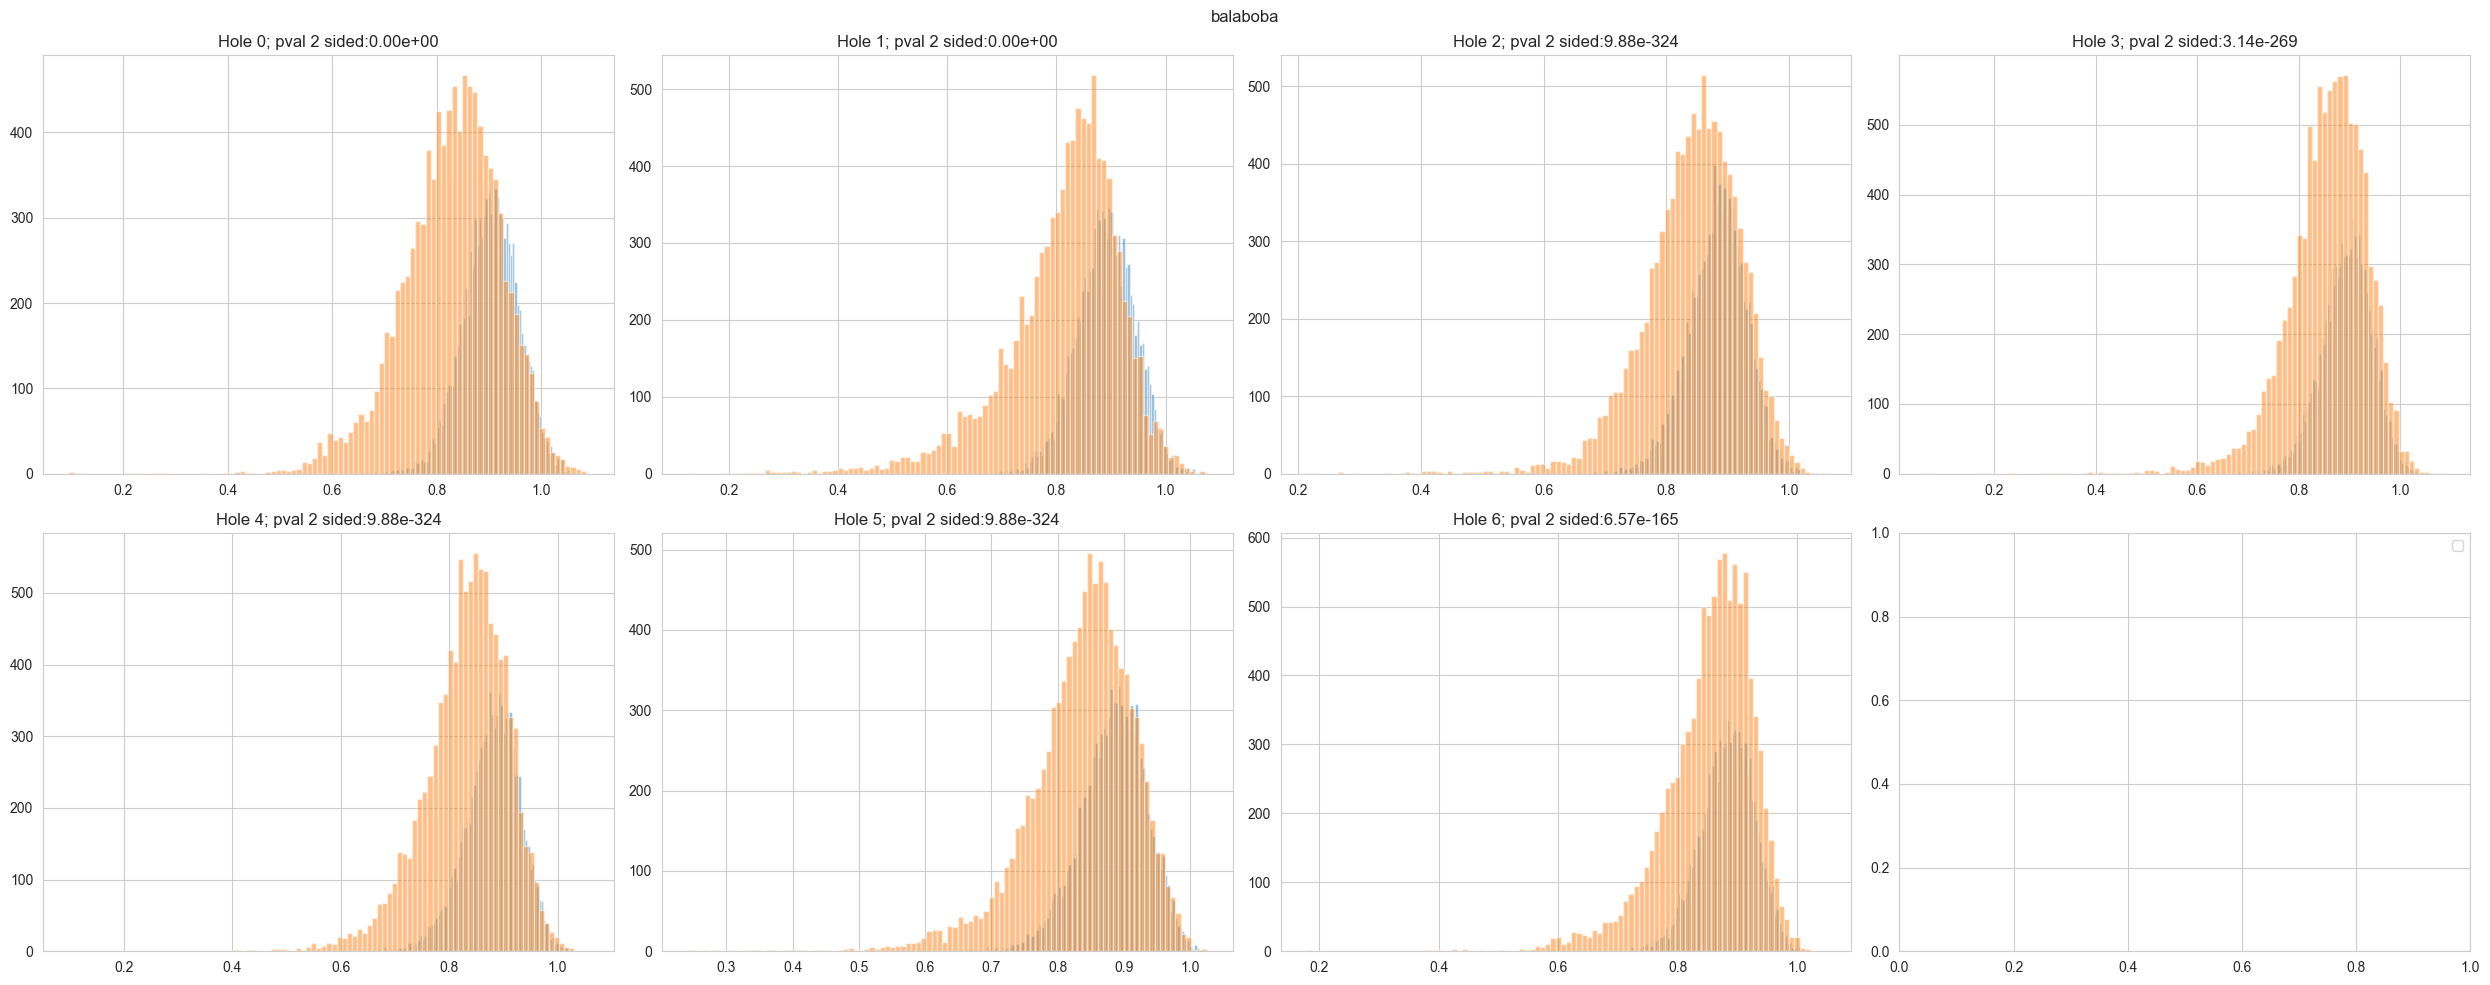

In [28]:
part = 'bigram'
for bot in bot_names:
    fig, axs = plt.subplots(2, 4, figsize=(25, 10))
    fig.suptitle(bot)
    for i, ax in enumerate(axs.reshape(-1)):
        if i >= 7: continue
        ax.hist(lit_ch[part][:,8 + i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:, 8 + i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:, 8 + i], bot_ch[part][bot][:, 8 + i]).pvalue
        ax.set_title(f"Hole {i}; pval 2 sided:{pval:.2e}")
    plt.tight_layout()
    plt.legend()
    plt.show()

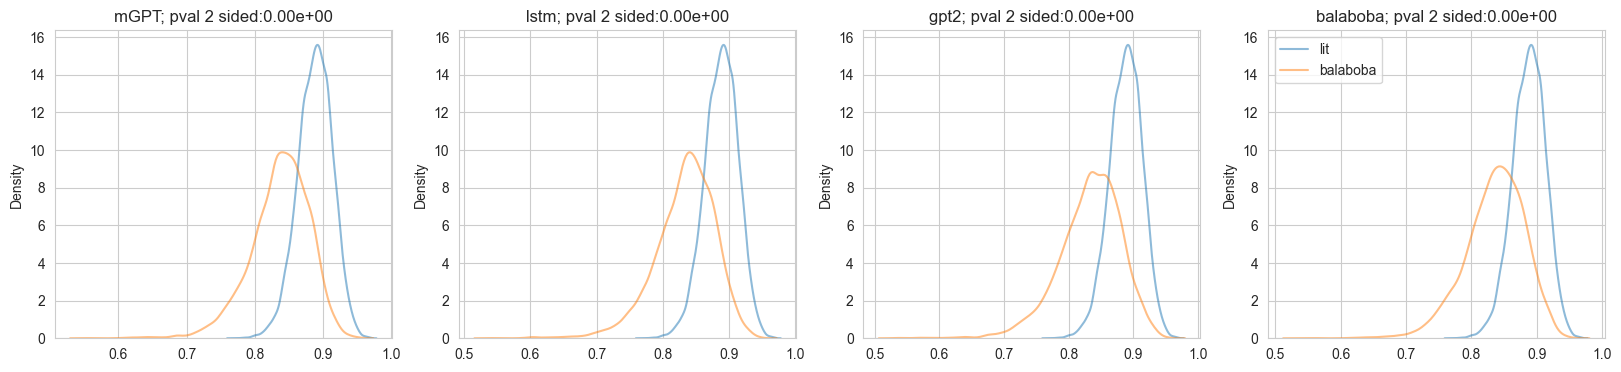

In [29]:
part = 'bigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,15], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,15], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,15], bot_ch[part][bot][:,15]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Max dist to holes

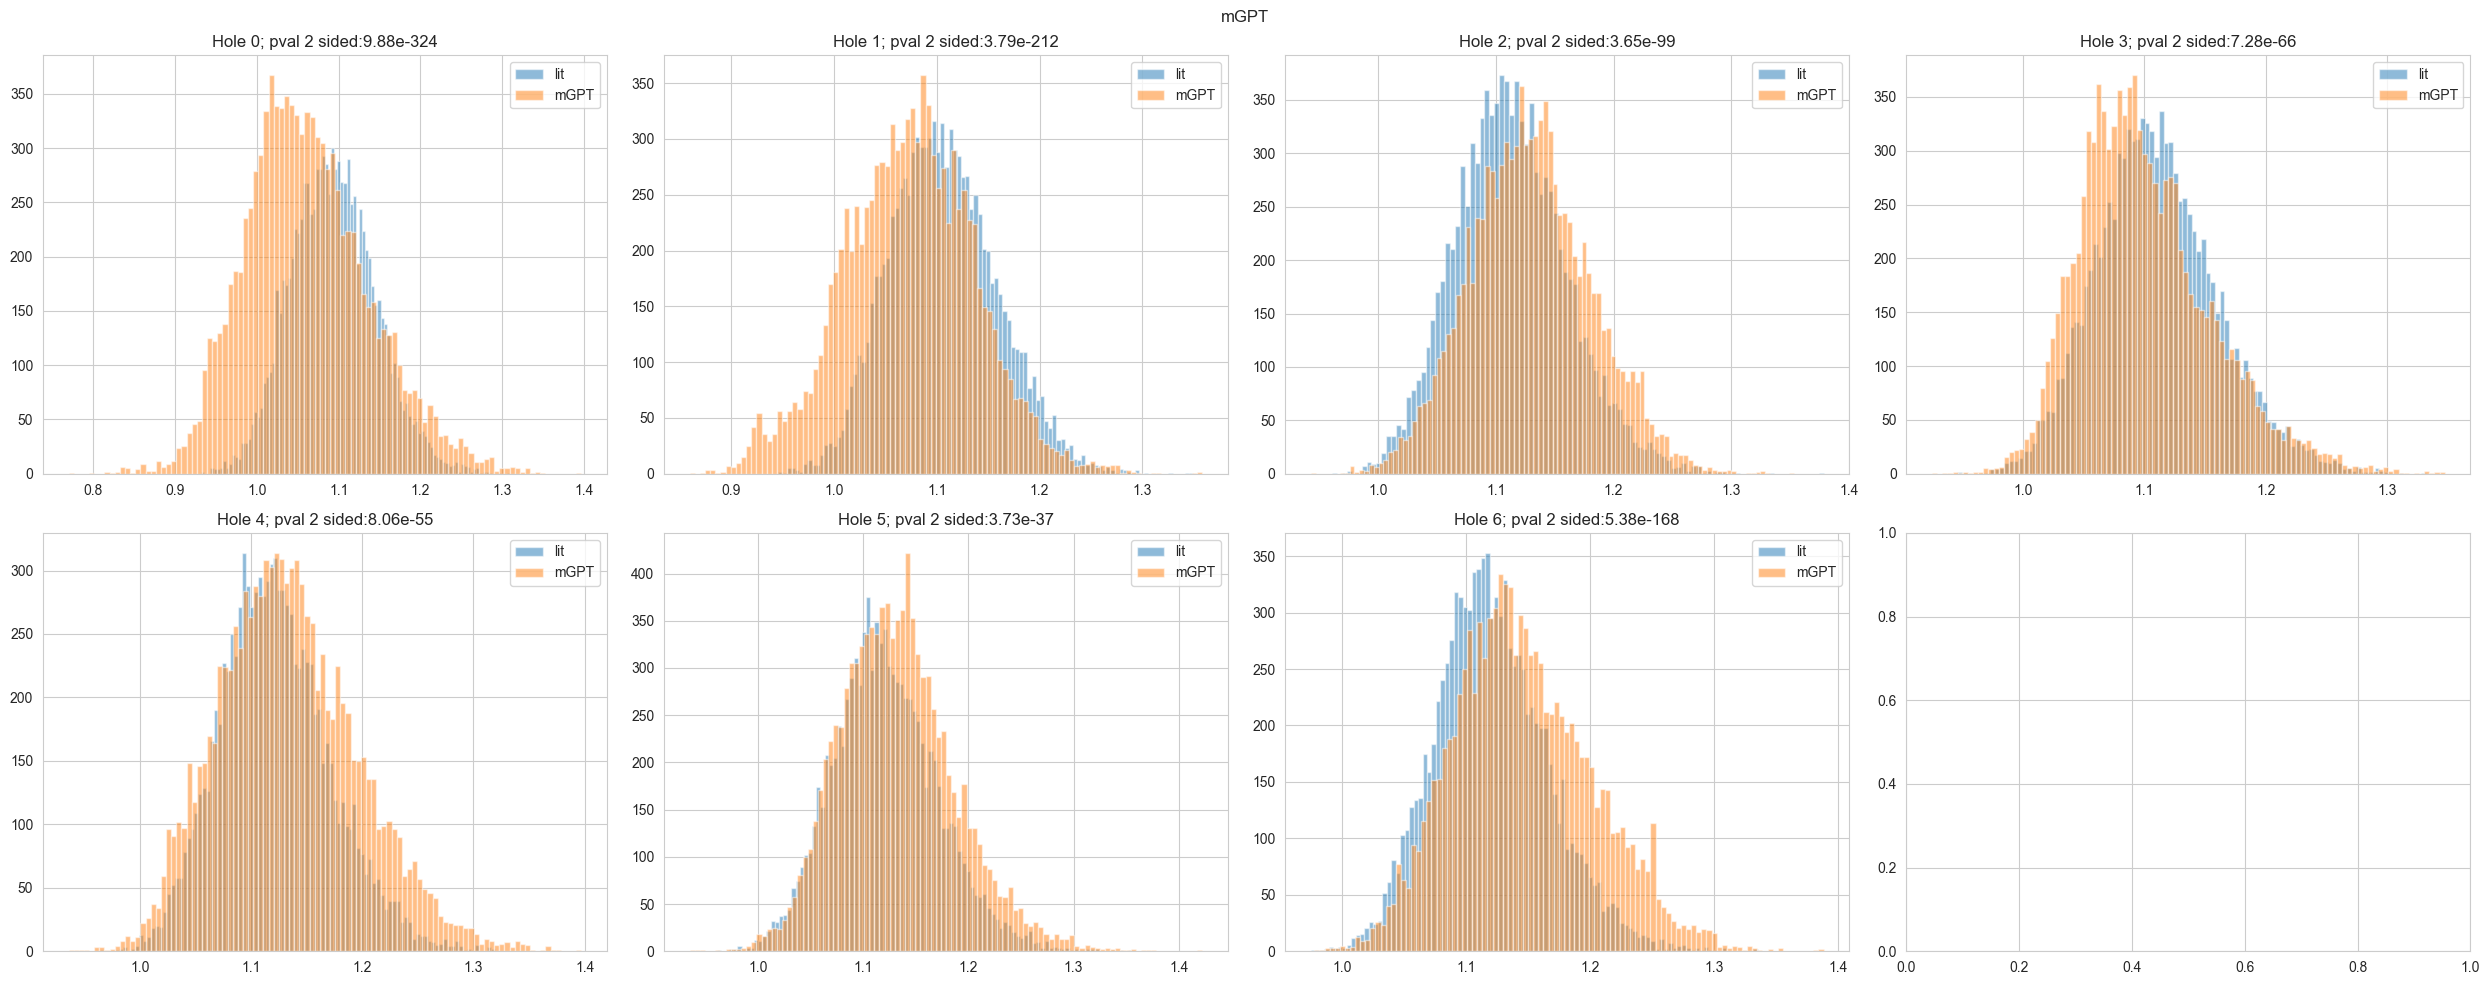

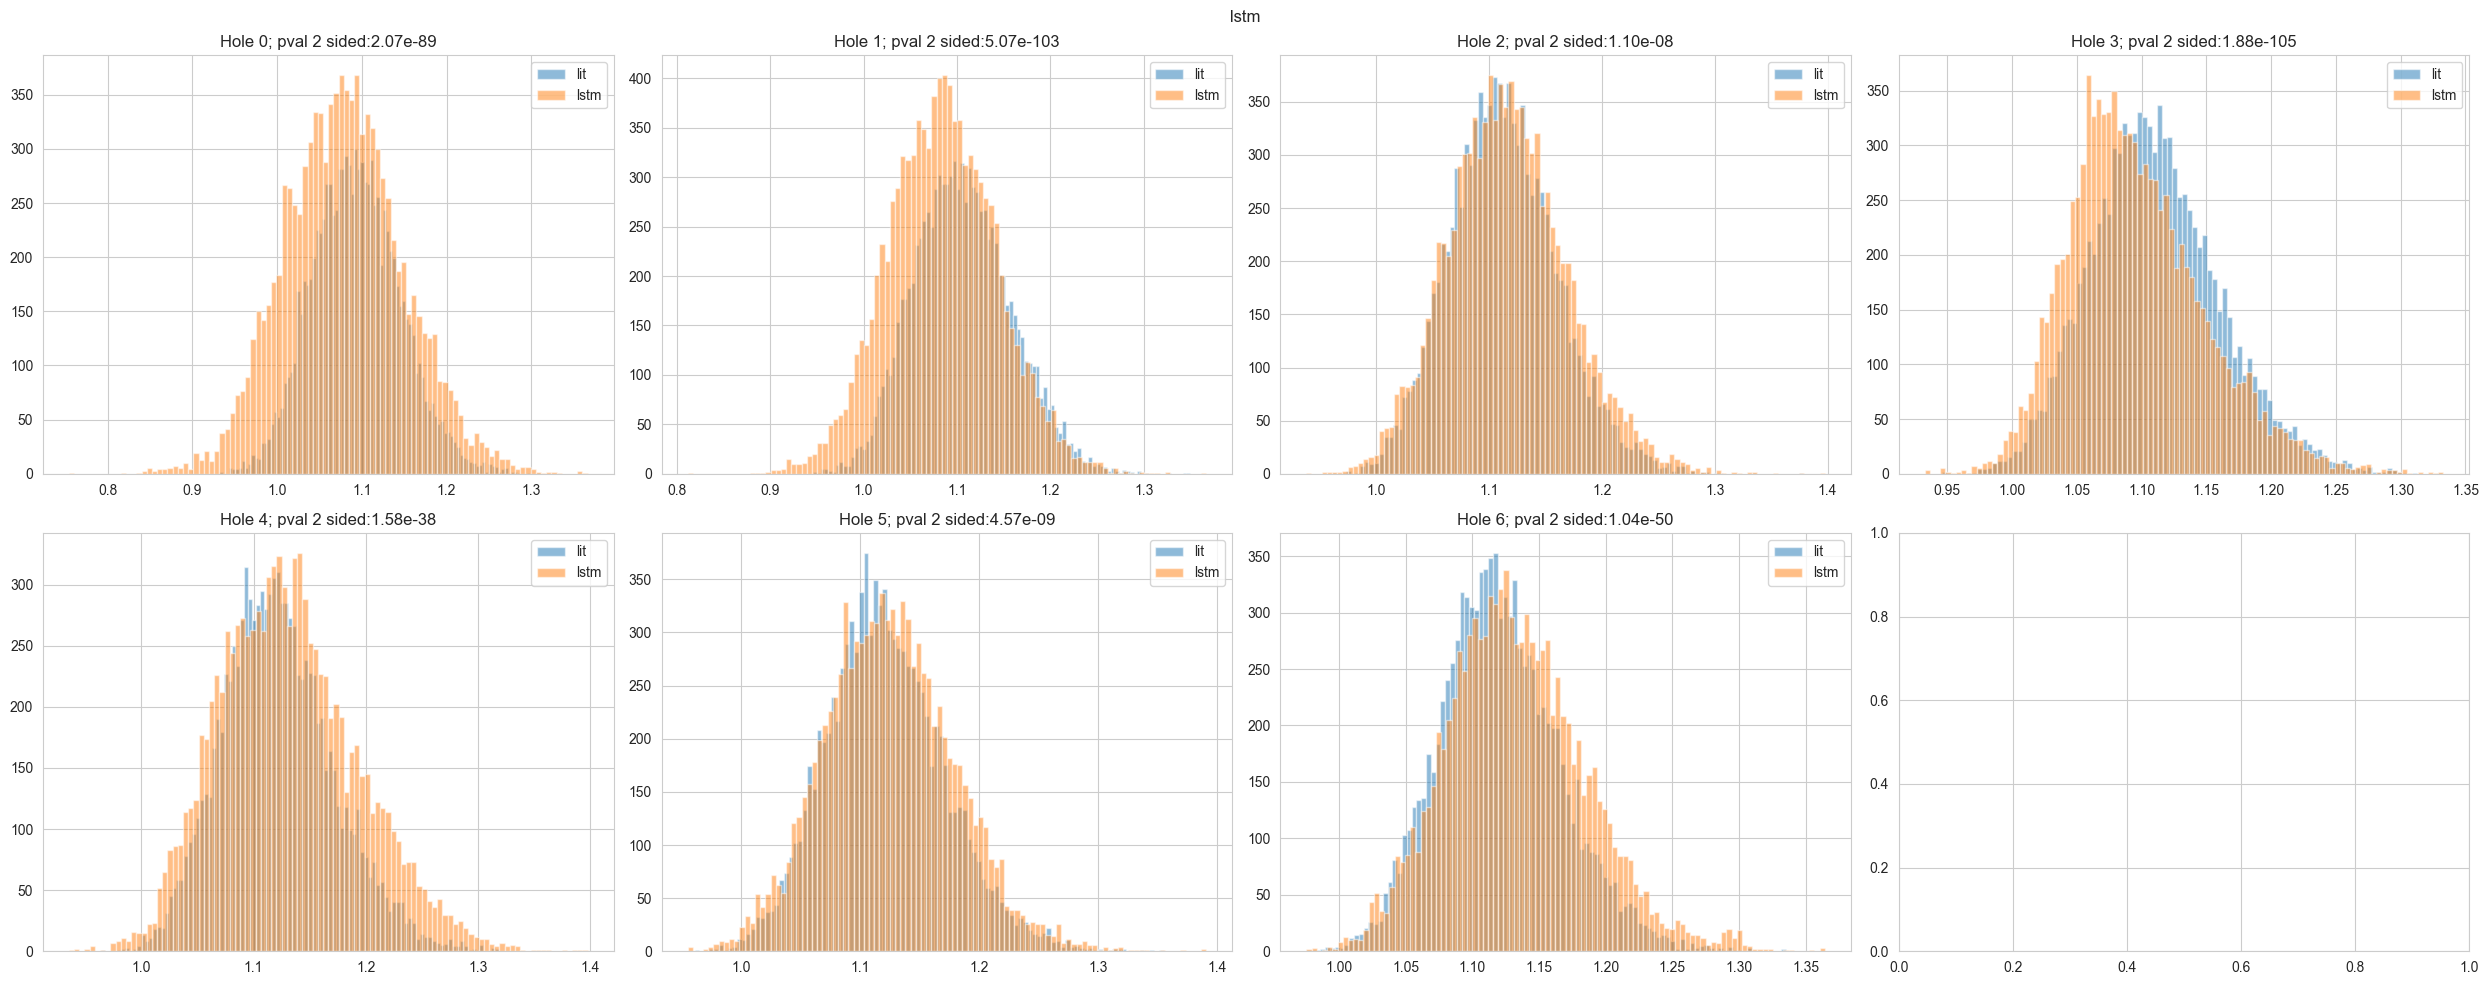

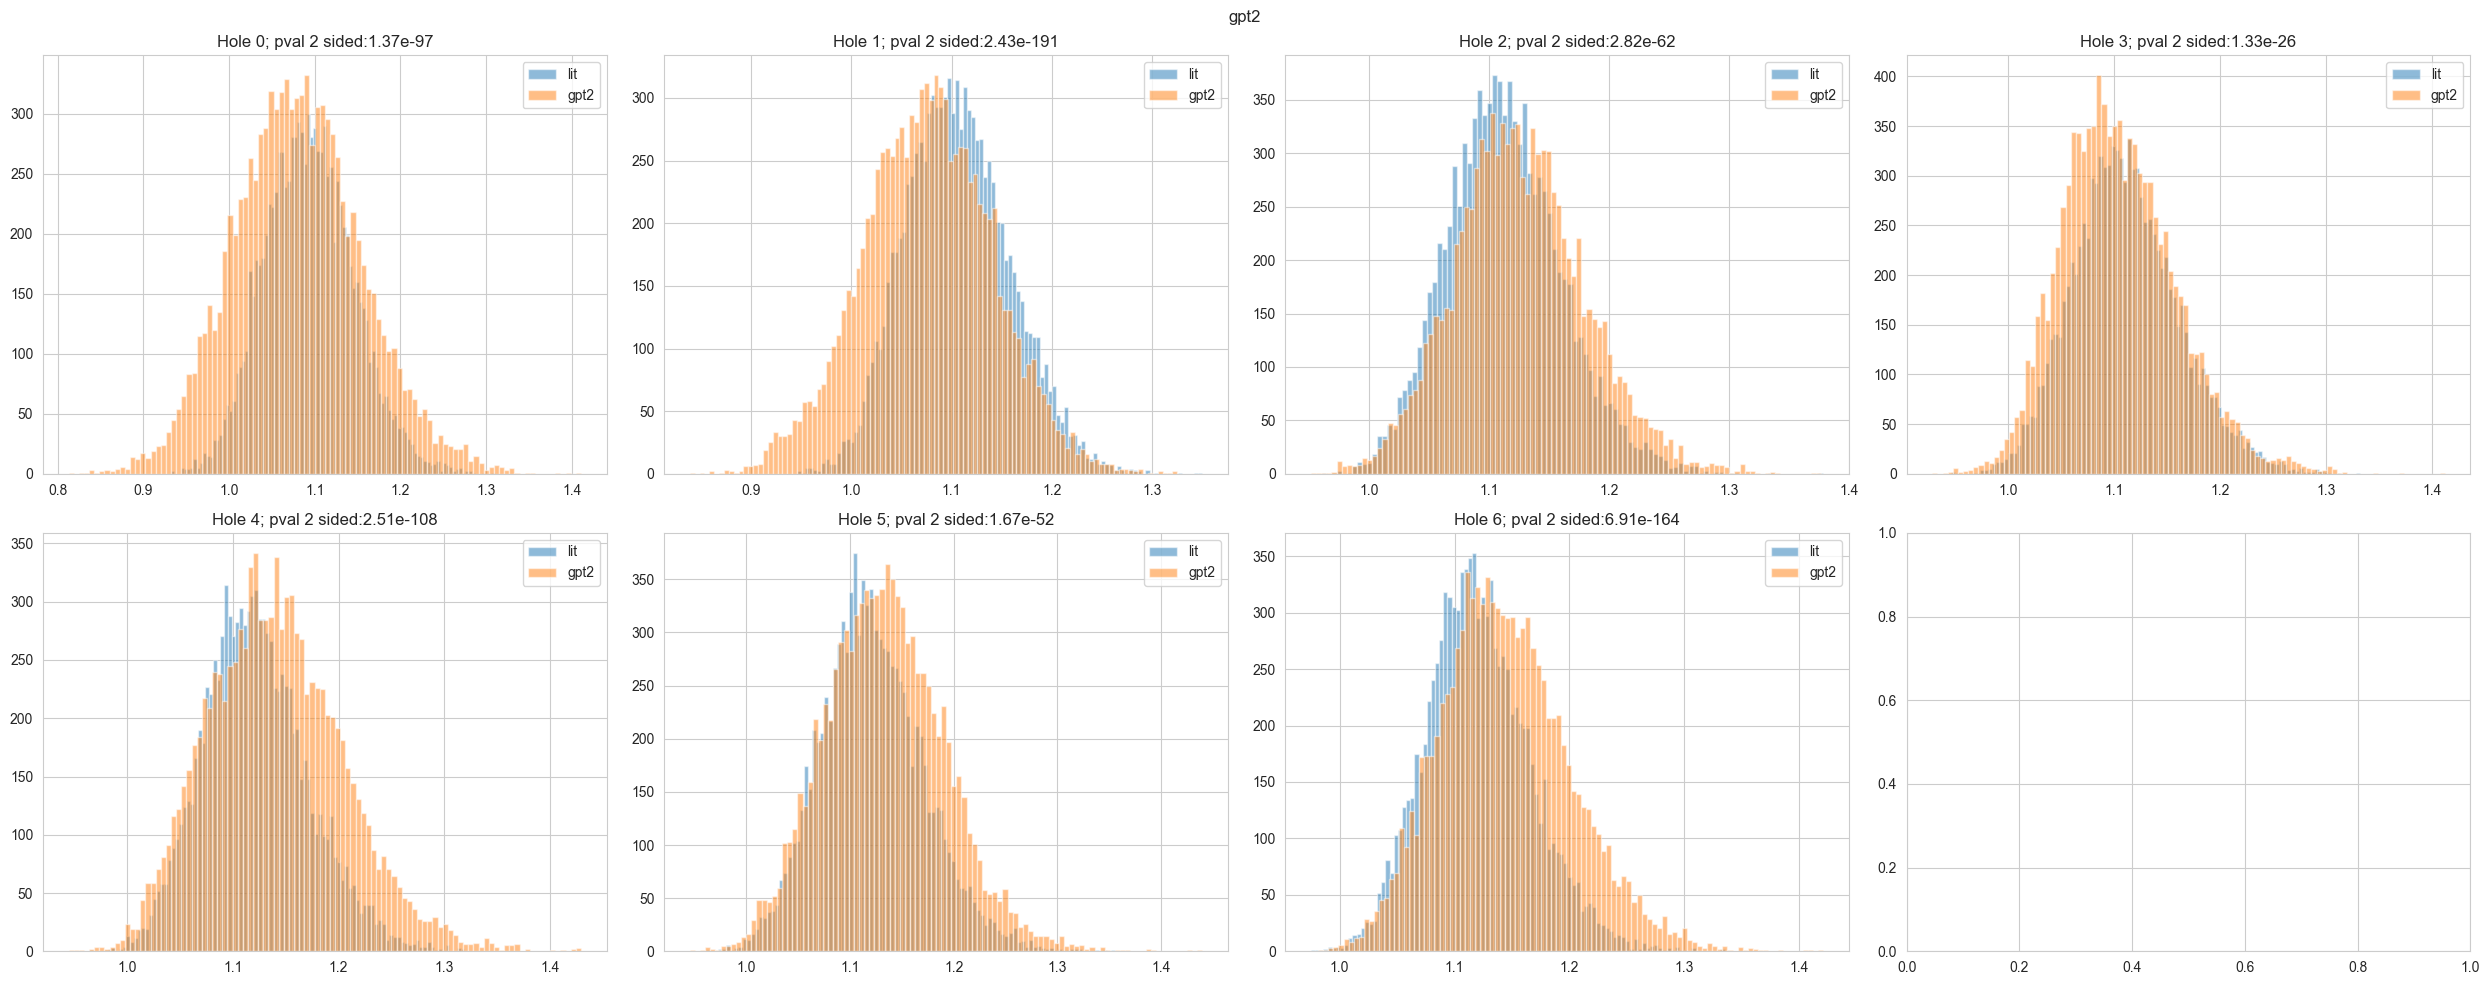

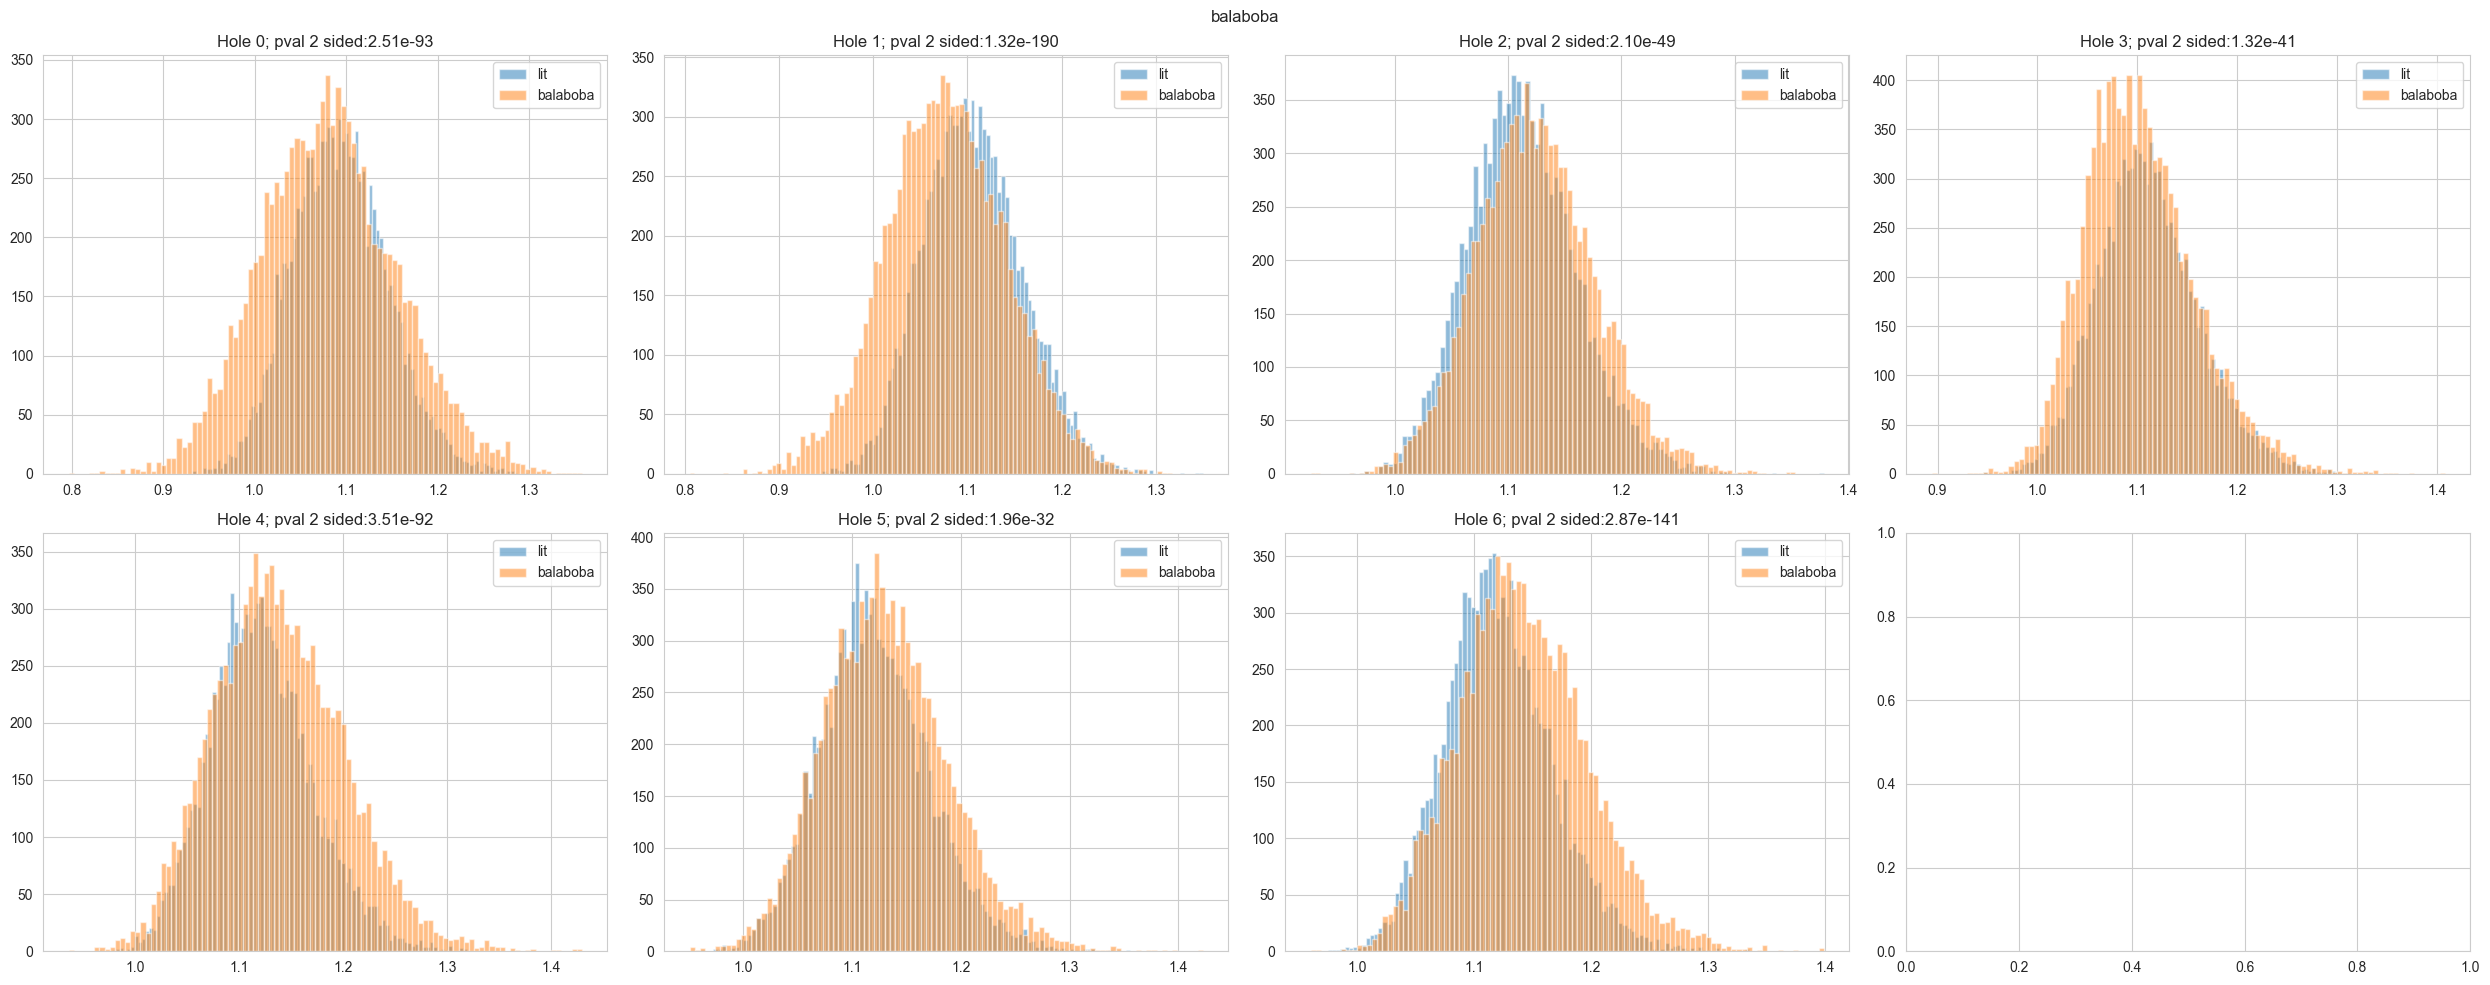

In [30]:
part = 'bigram'
for bot in bot_names:
    fig, axs = plt.subplots(2, 4, figsize=(25, 10))
    fig.suptitle(bot)
    for i, ax in enumerate(axs.reshape(-1)):
        if i >= 7: continue
        ax.hist(lit_ch[part][:,16 + i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:, 16 + i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:, 16 + i], bot_ch[part][bot][:, 16 + i]).pvalue
        ax.set_title(f"Hole {i}; pval 2 sided:{pval:.2e}")
        ax.legend()
    plt.tight_layout()
    plt.show()

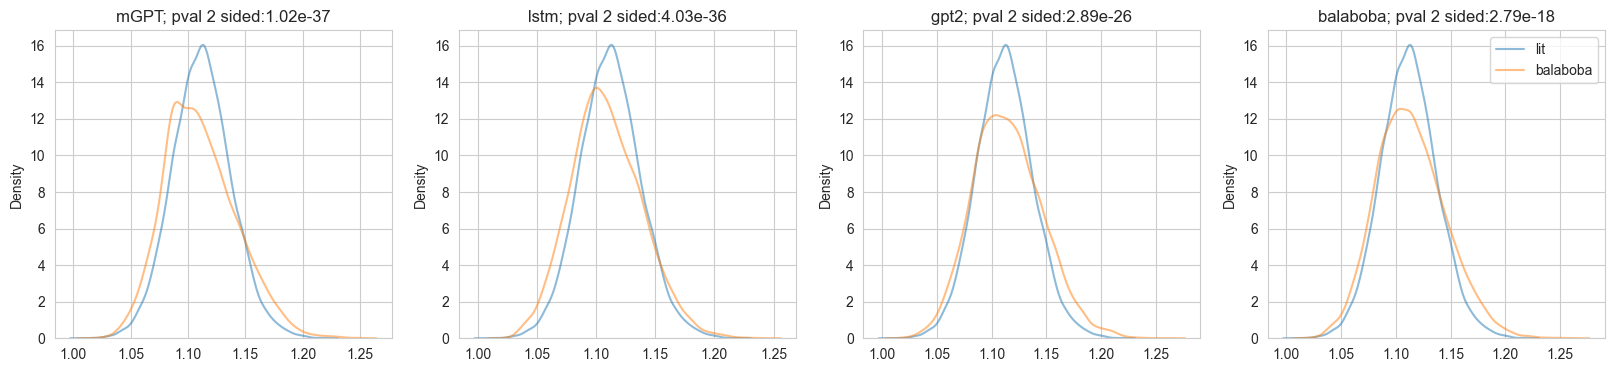

In [31]:
part = 'bigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,23], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,23], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,23], bot_ch[part][bot][:,23]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Closest holes

In [32]:
from collections import Counter
part = 'bigram'

print("LIT:", Counter(np.array(lit_ch[part][:, -1], dtype=int)).most_common())
for bot in bot_names:
    print(bot, Counter(np.array(bot_ch[part][bot][:, -1], dtype=int)).most_common())

LIT: [(2, 1981), (3, 1878), (6, 1834), (5, 1615), (1, 1401), (4, 1291)]
mGPT [(1, 3216), (2, 2770), (3, 1407), (6, 1024), (5, 919), (4, 664)]
lstm [(1, 2700), (2, 2140), (3, 1680), (6, 1302), (5, 1161), (4, 1017)]
gpt2 [(2, 2843), (1, 2515), (3, 1366), (5, 1195), (6, 1177), (4, 904)]
balaboba [(2, 2765), (1, 2399), (3, 1513), (6, 1275), (5, 1161), (4, 887)]


In [42]:
part = 'bigram'
hole_names = list(hole_embeddings[part].keys())
print([(i, hn) for i, hn in enumerate(hole_names)])

[(0, '100$465'), (1, '101$486'), (2, '123$454'), (3, '123$472'), (4, '123$473'), (5, '123$497'), (6, '123$499')]


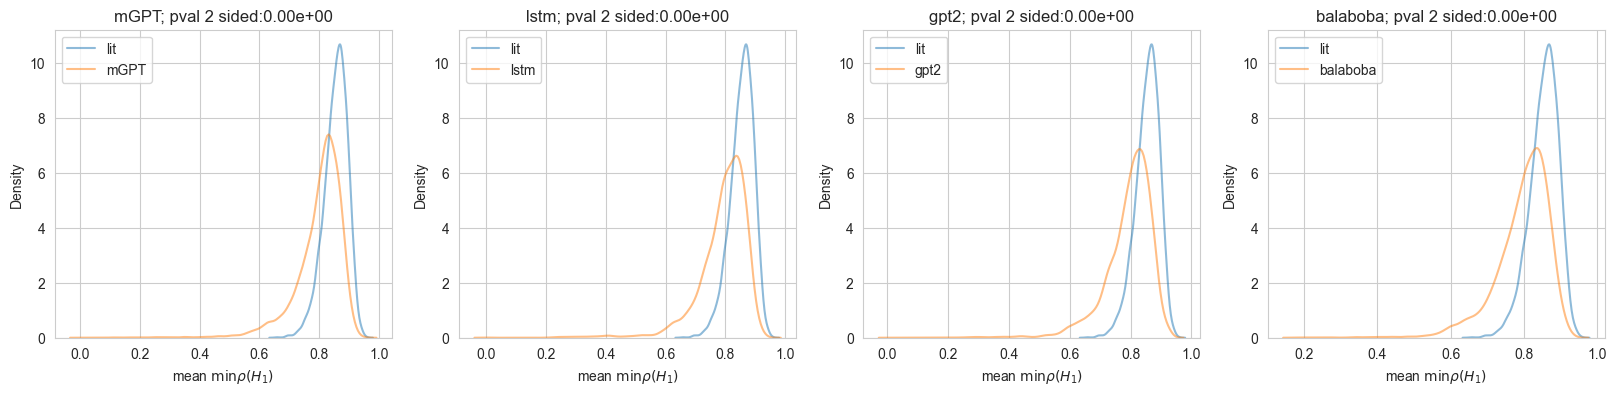

In [48]:
part = 'bigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_min_dist[part], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_min_dist[part][bot], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_min_dist[part], bot_min_dist[part][bot]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
    ax.legend()
    ax.set(xlabel=r'mean $\min\rho(H_1)$')
plt.show()

## Trigrams

### Dist to centers

In [ ]:
for i in range(12):    
    for bot in bot_names:
        plt.hist(bot_ch['trigram'][bot][:,i], label=bot, bins=100, alpha=.5);
    plt.hist(lit_ch['trigram'][:,i], label="lit", bins=100, alpha=.7);
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


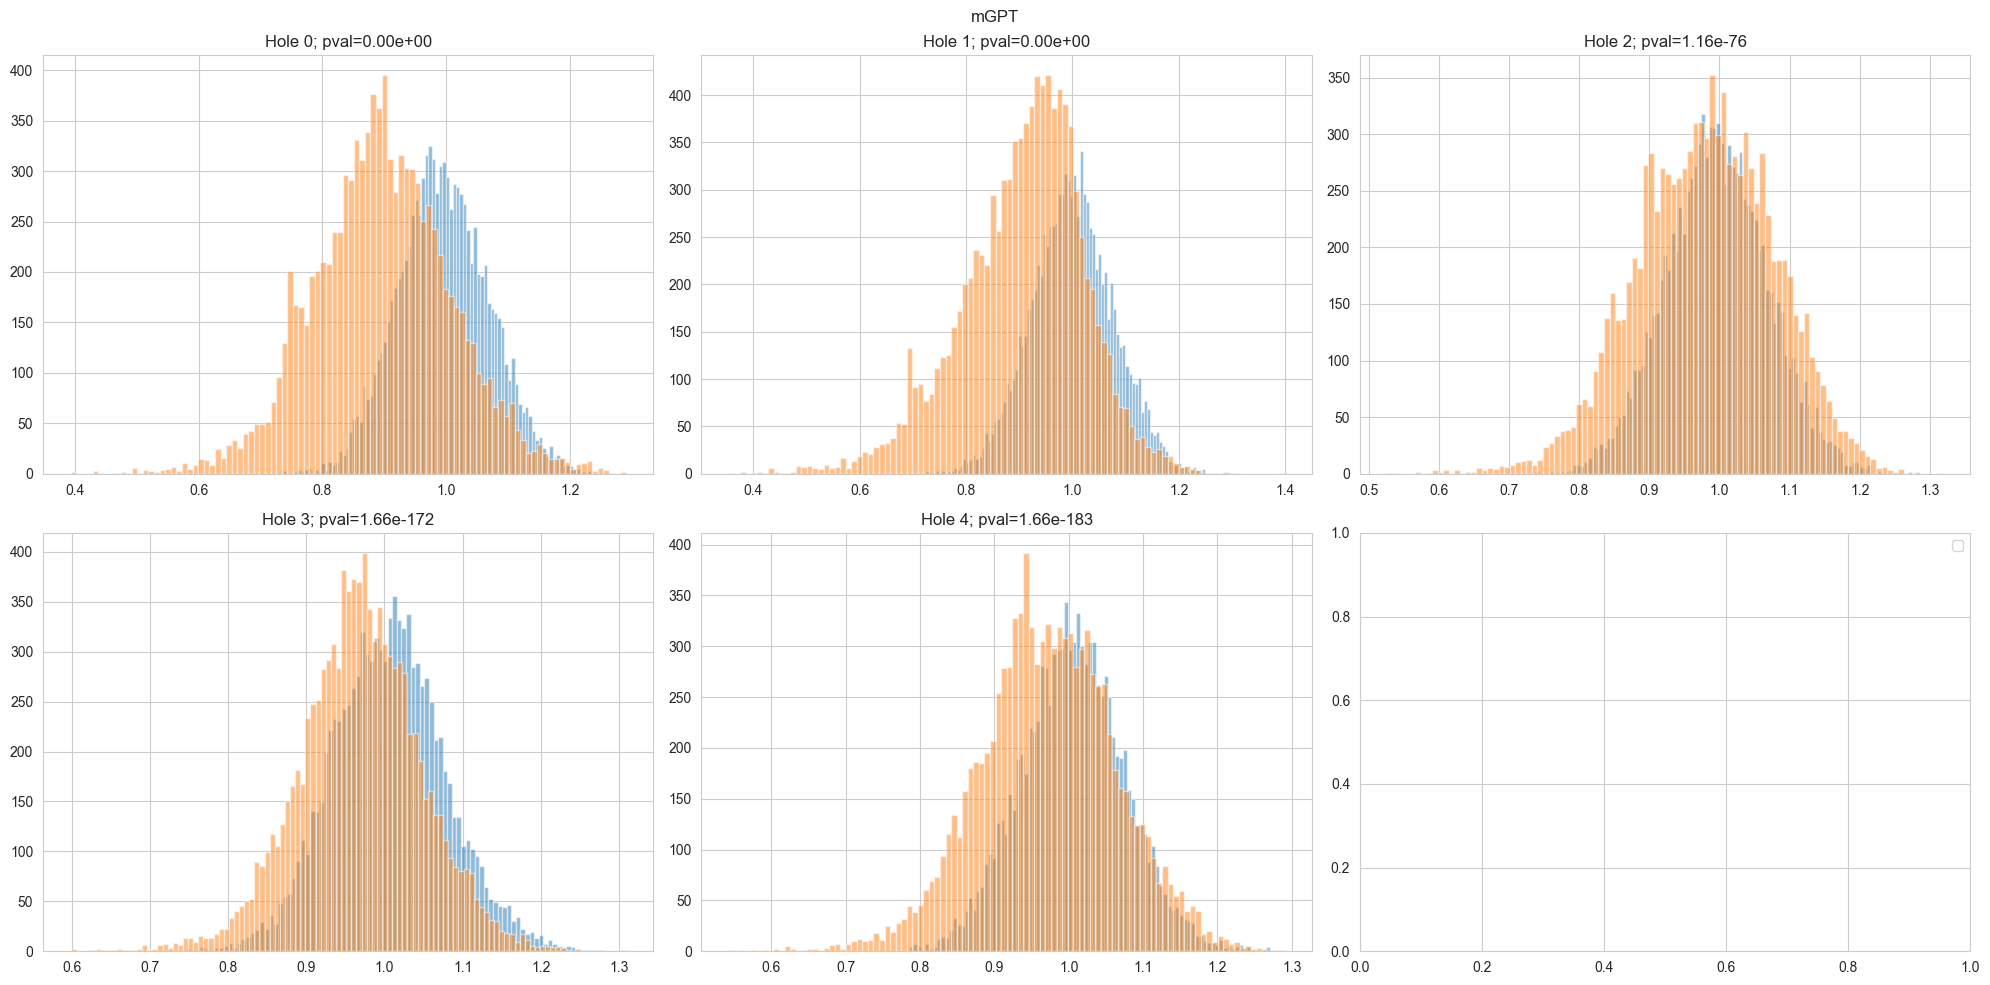

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


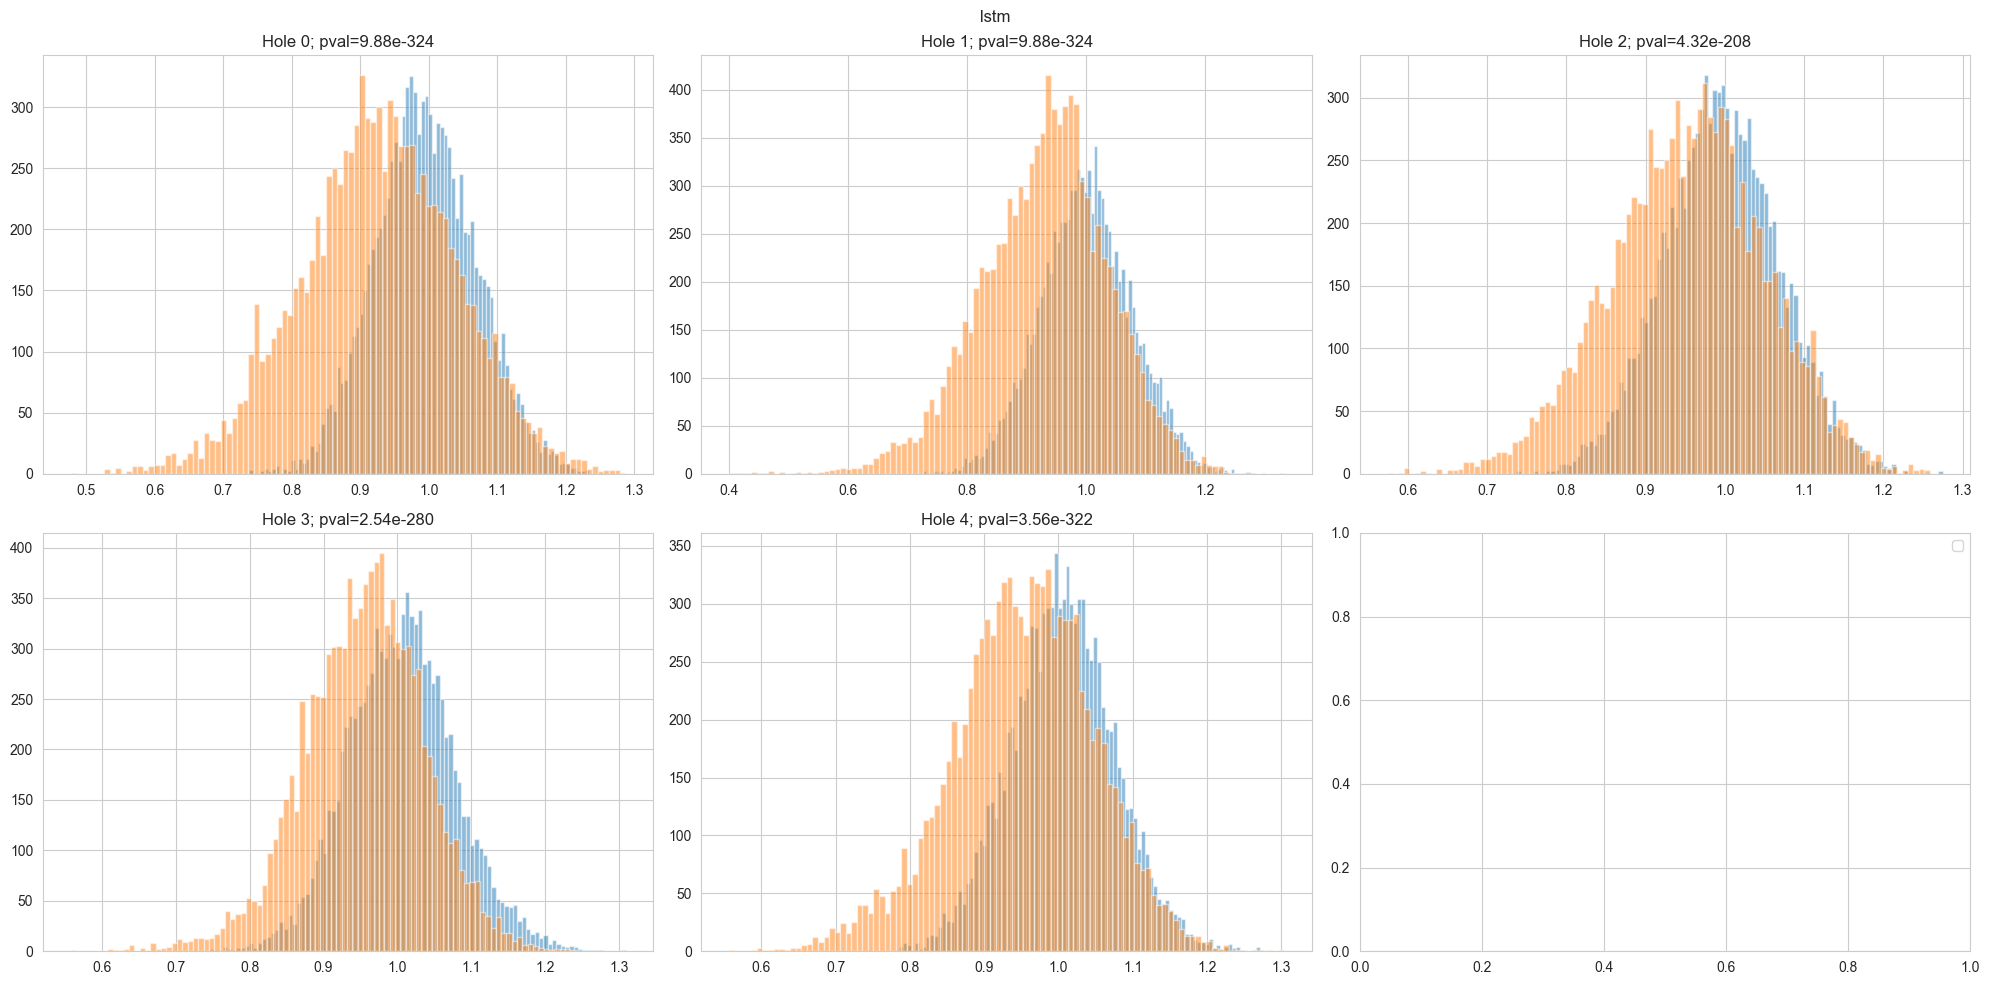

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


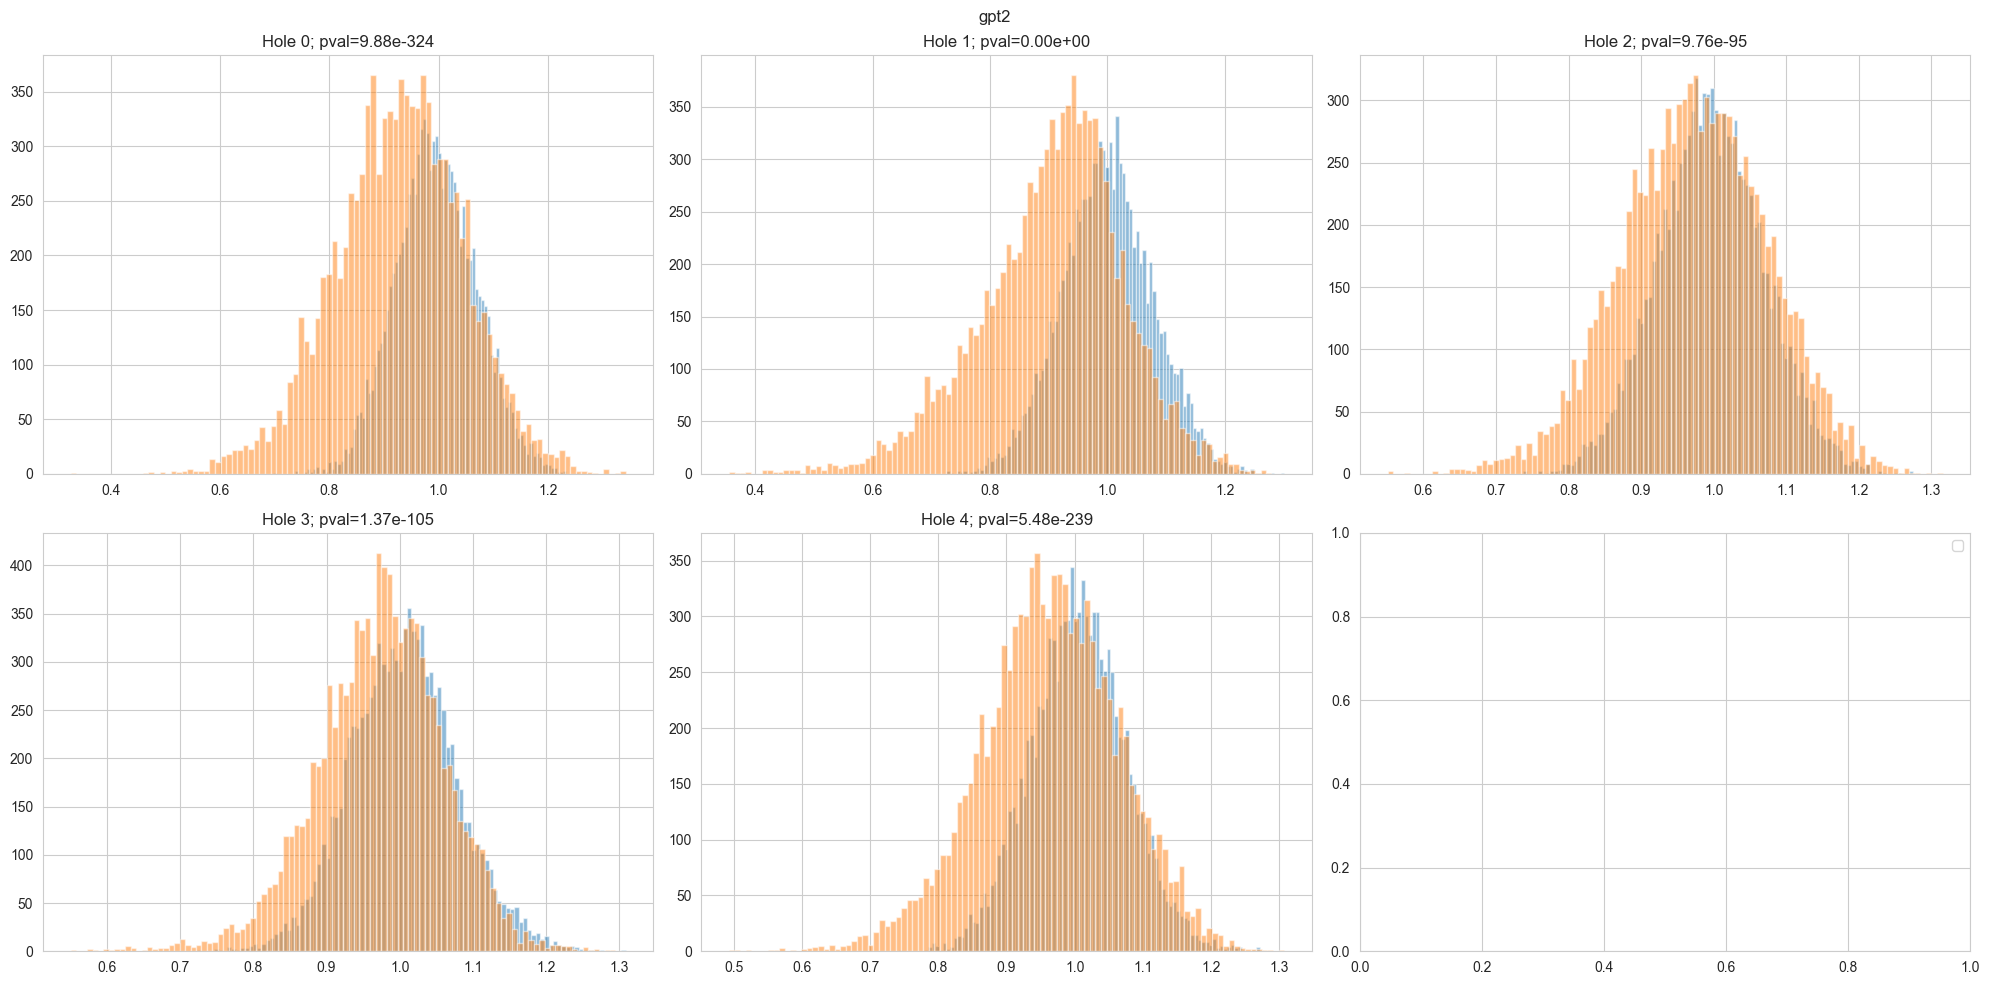

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


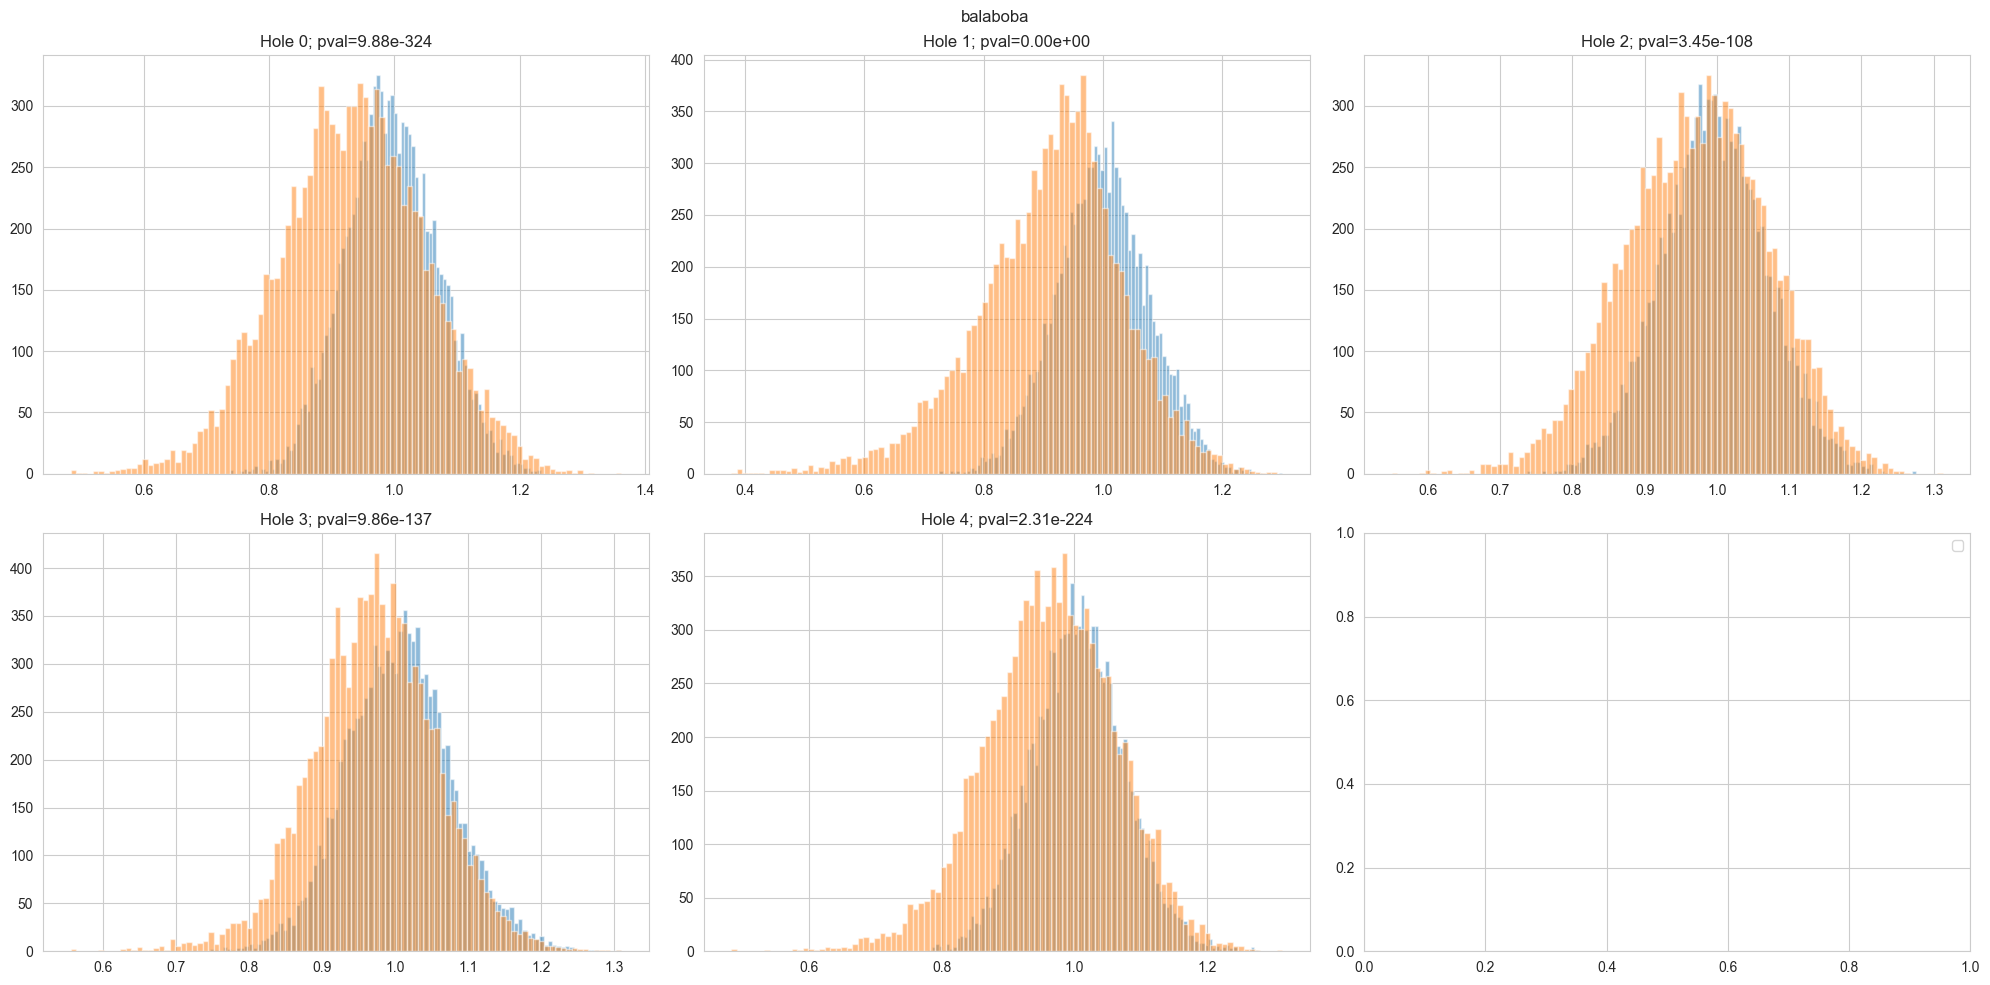

In [34]:
for bot in bot_names:
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(bot)
    for i, ax in zip(range(5), axs.reshape(-1)):
        ax.hist(lit_ch[part][:,i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:,i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:,i], bot_ch[part][bot][:,i]).pvalue
        ax.set_title(f"Hole {i}; pval={pval:.2e}")
    plt.legend();
    plt.tight_layout()
    plt.show()

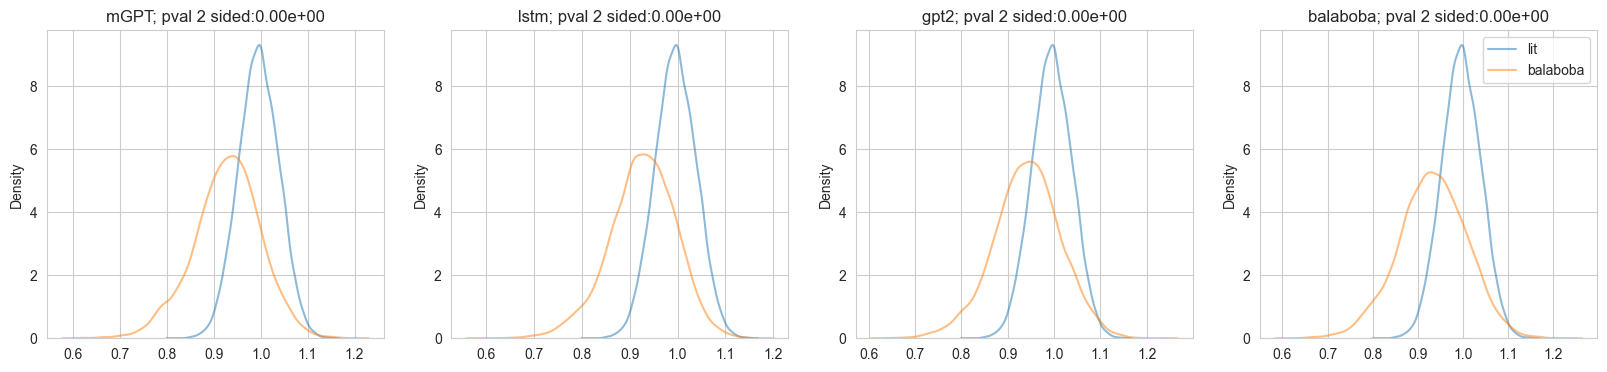

In [35]:
part = 'trigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,5], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,5], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,5], bot_ch[part][bot][:,5]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Min dist to holes

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


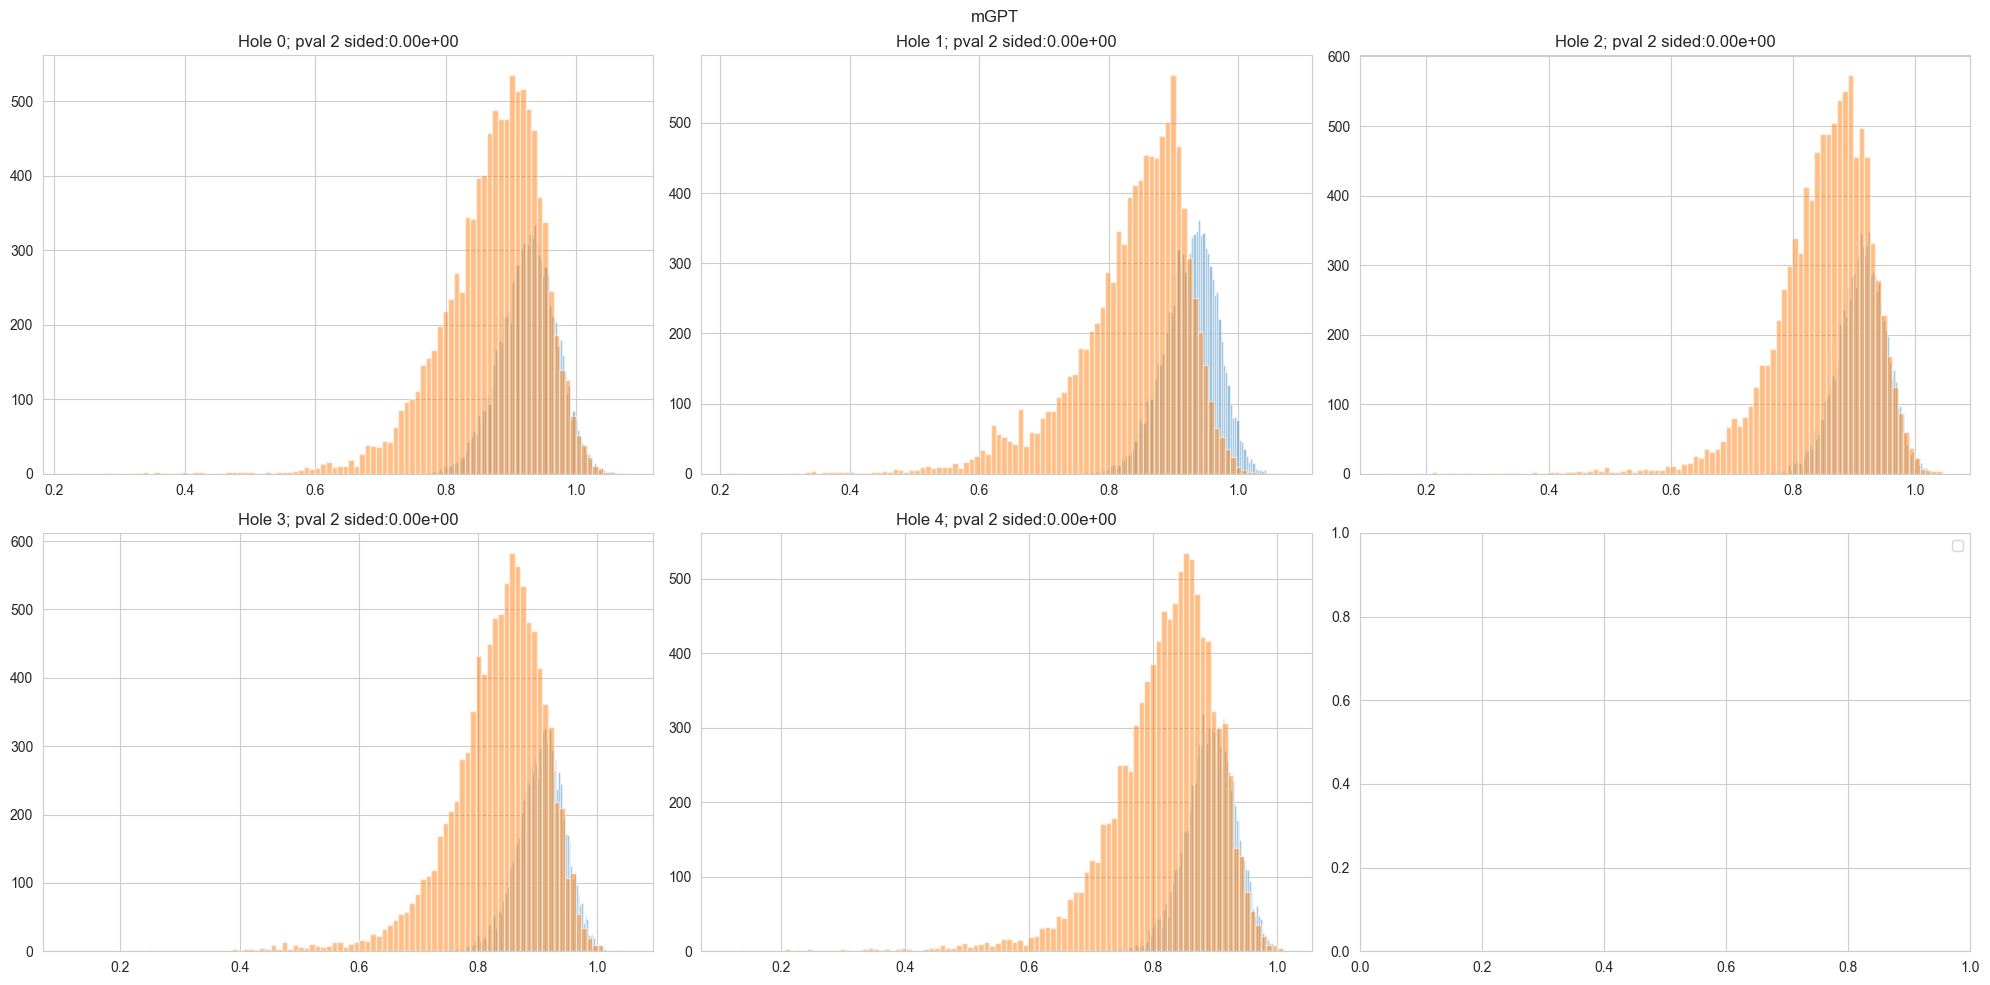

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


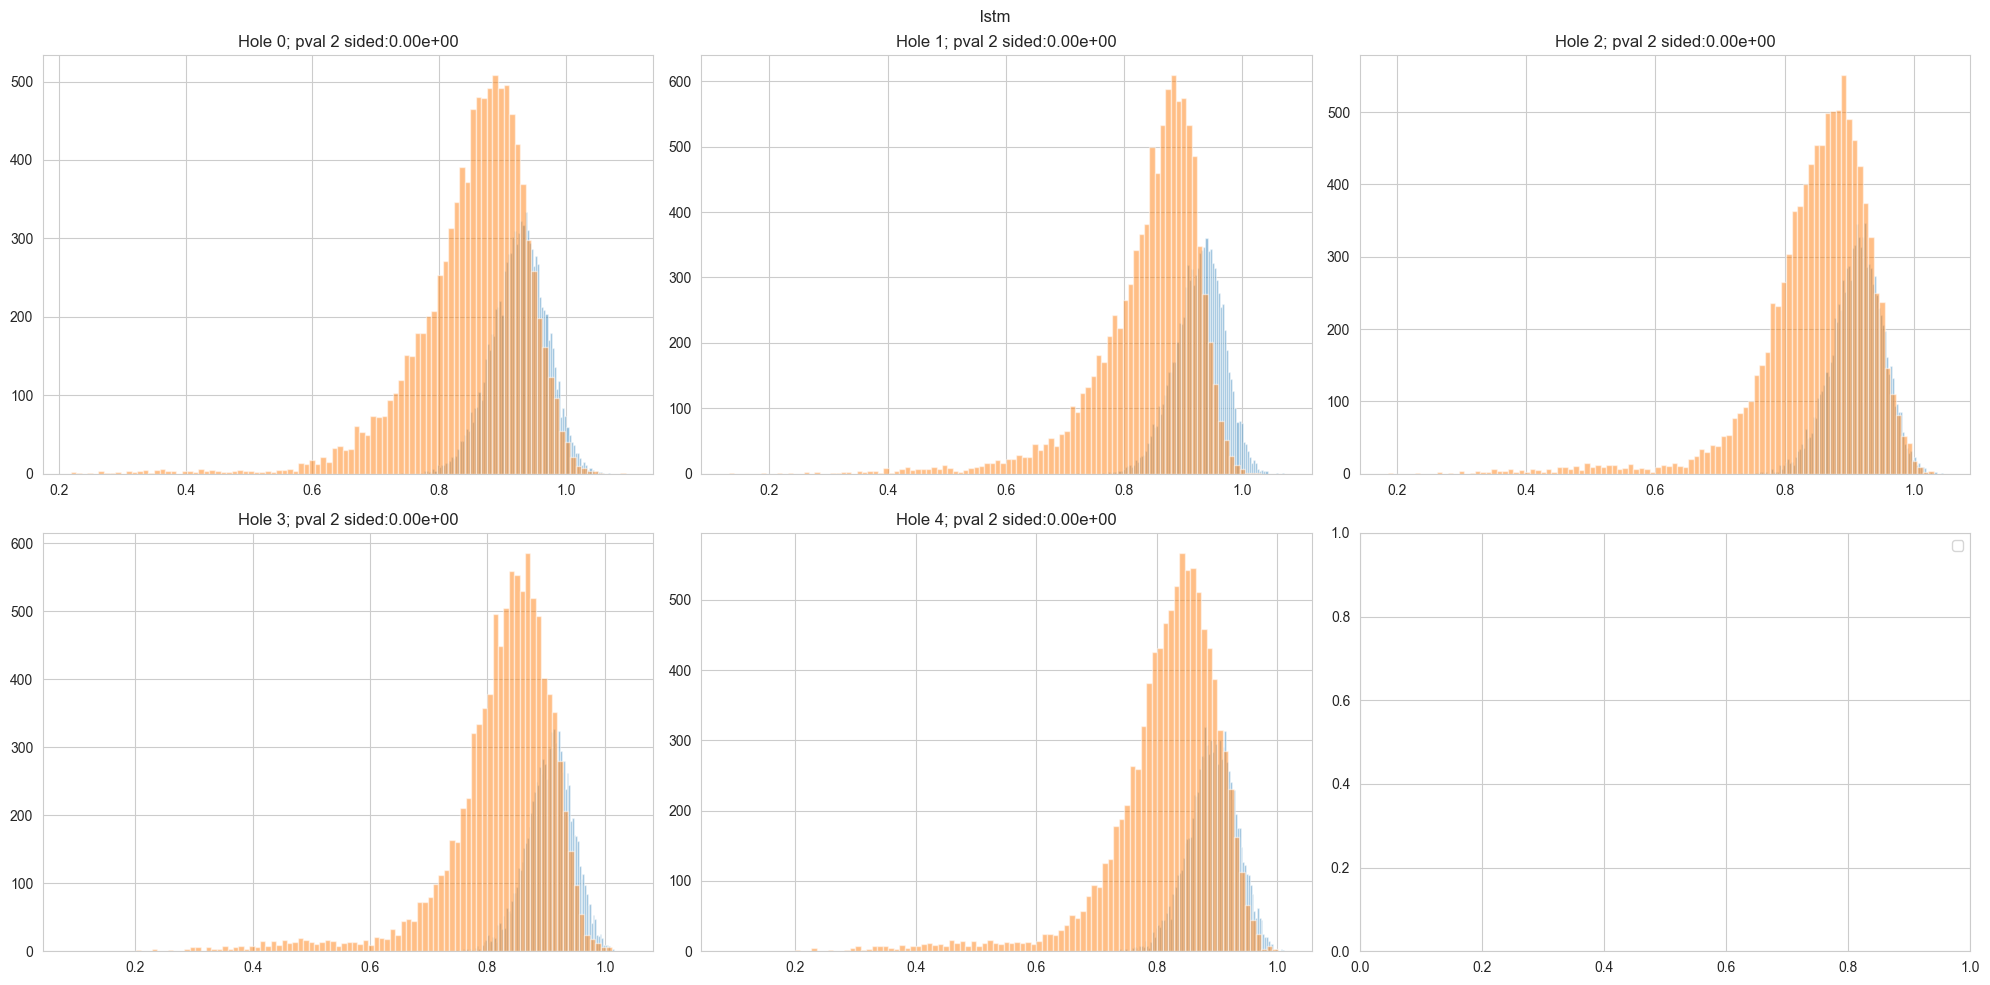

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


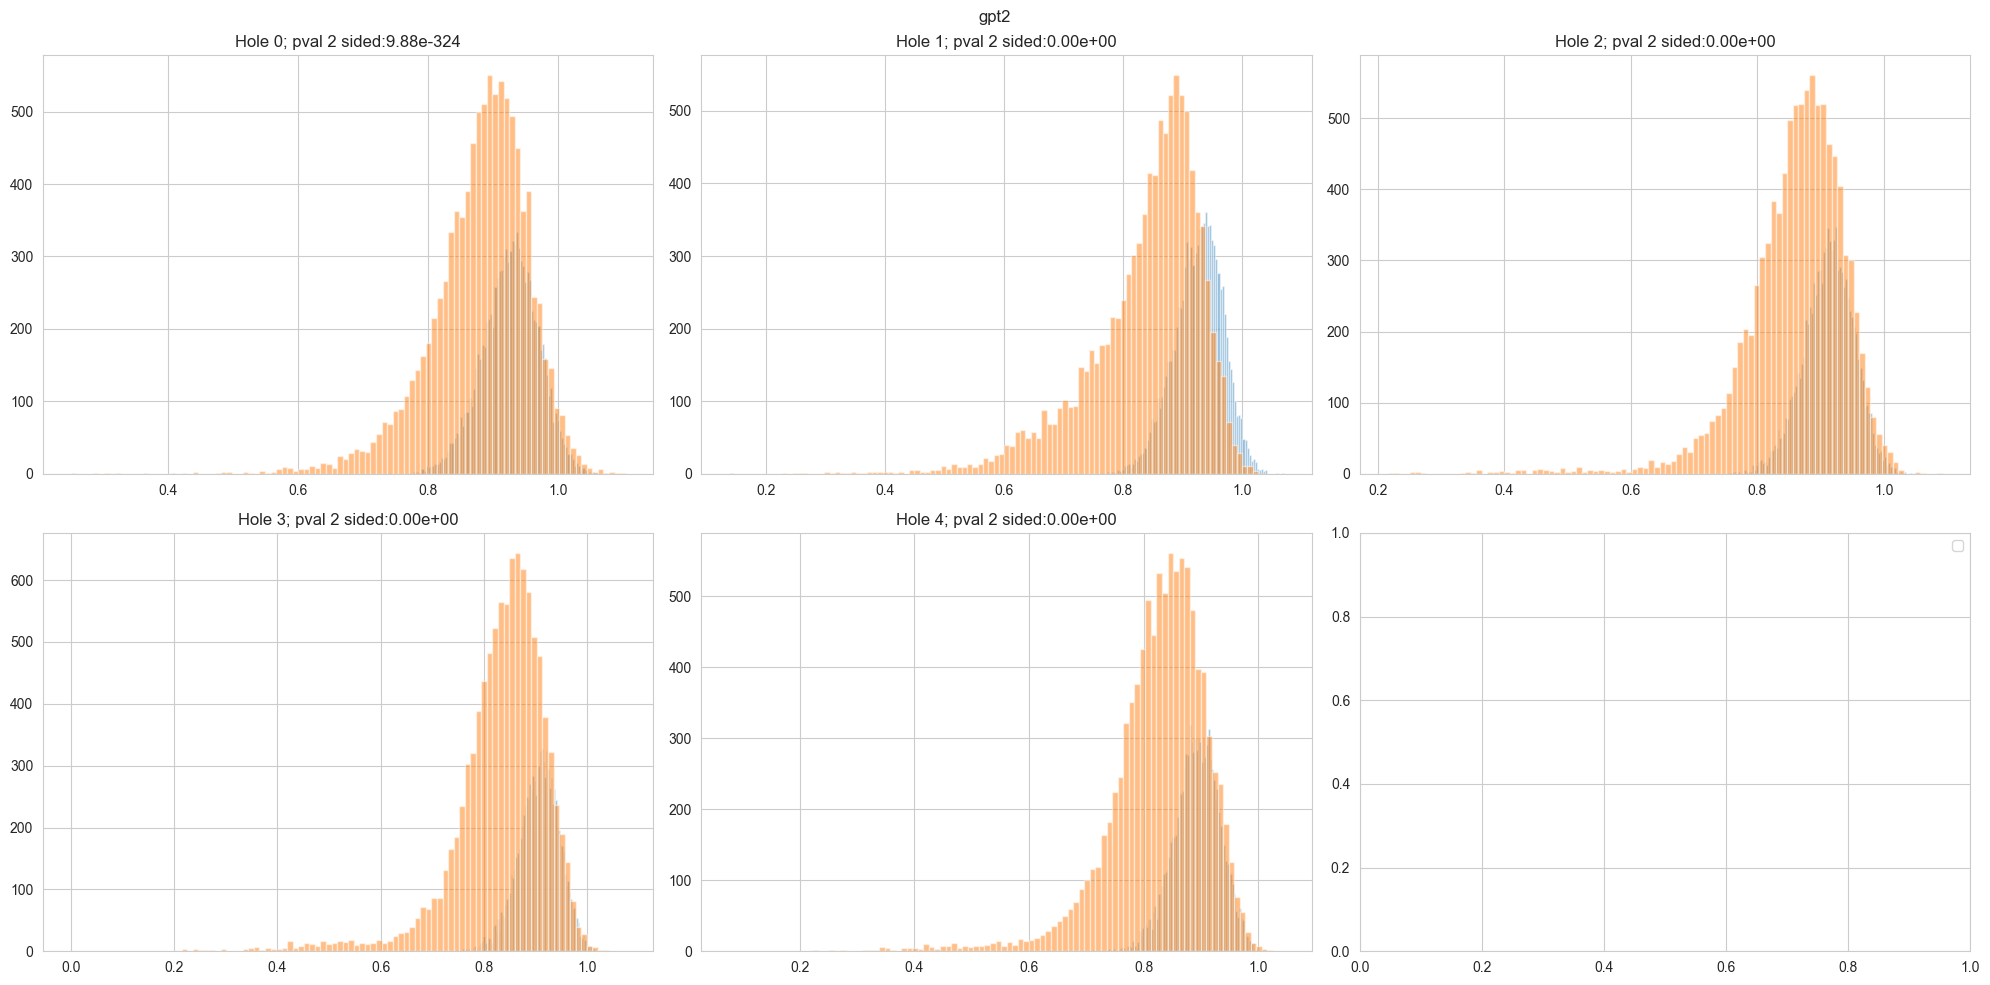

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


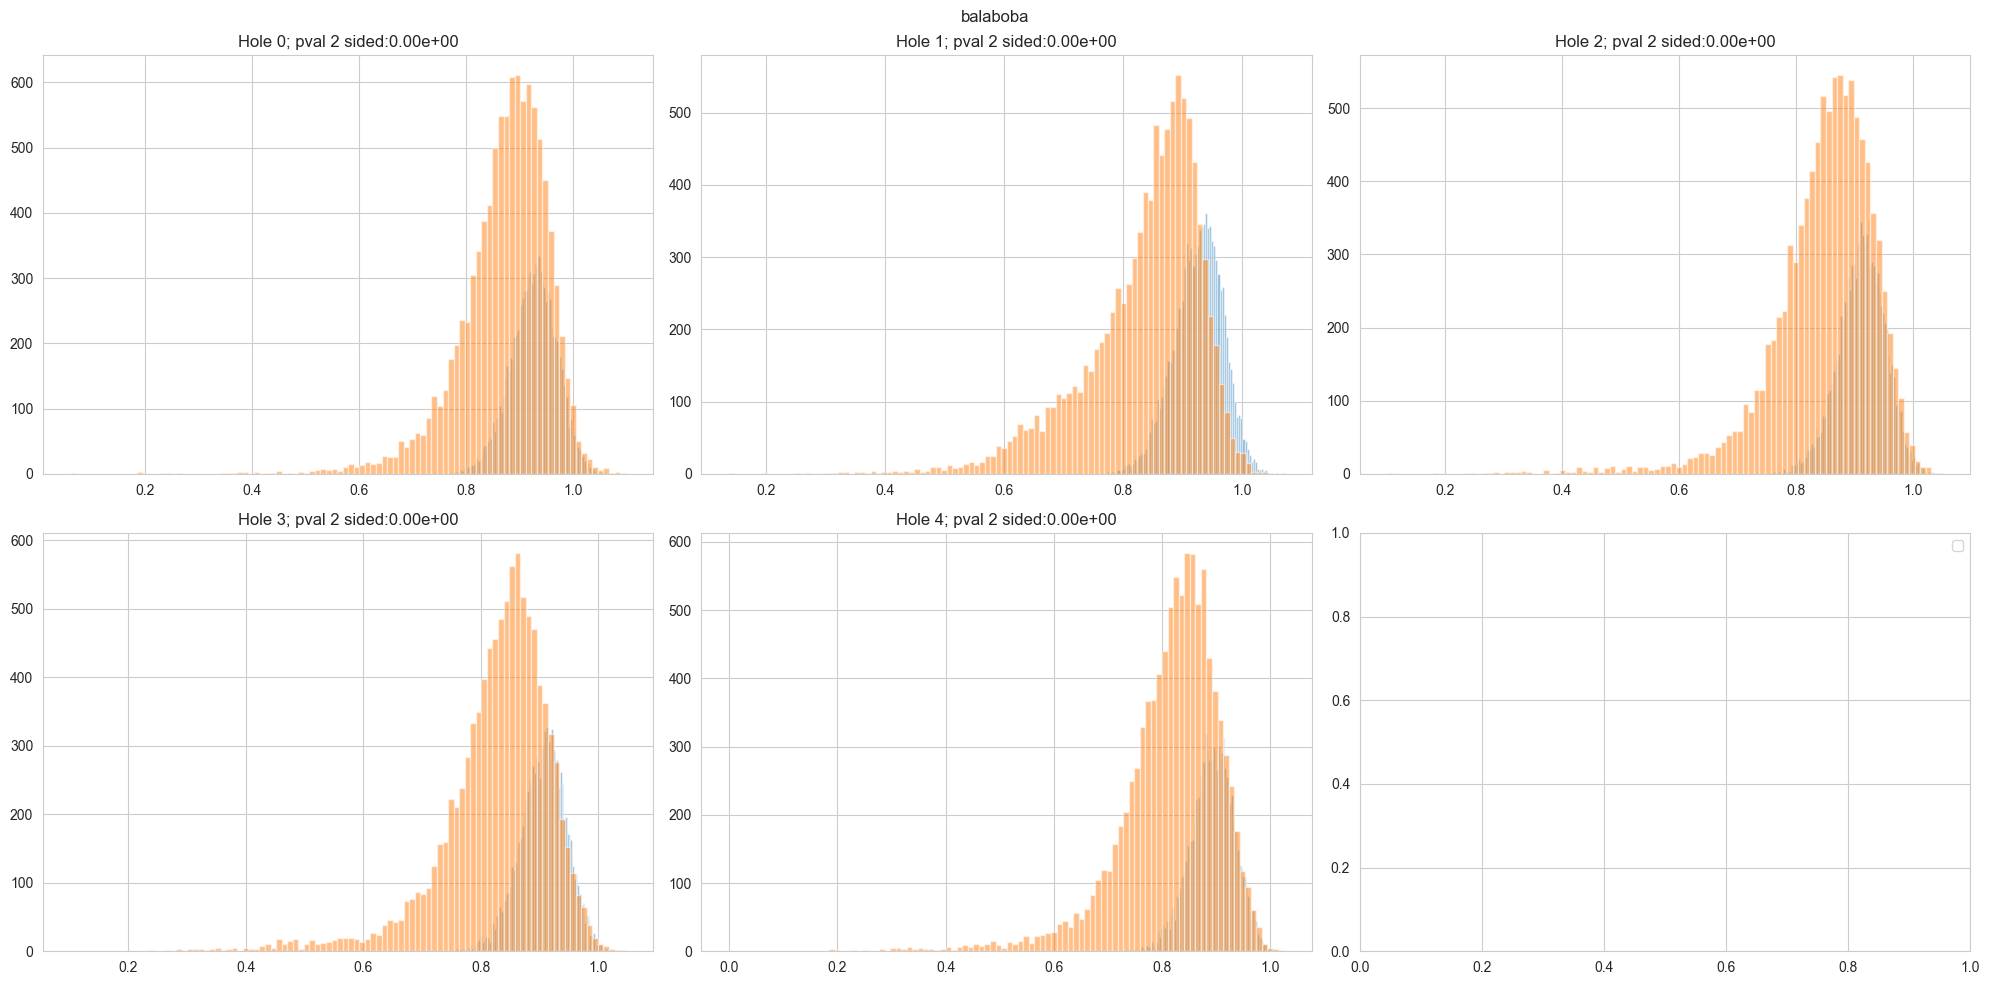

In [36]:
part = 'trigram'
for bot in bot_names:
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(bot)
    for i, ax in zip(range(5), axs.reshape(-1)):
        ax.hist(lit_ch[part][:,6 + i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:, 6 + i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:, 6 + i], bot_ch[part][bot][:, 6 + i]).pvalue
        ax.set_title(f"Hole {i}; pval 2 sided:{pval:.2e}")
    plt.tight_layout()
    plt.legend()
    plt.show()

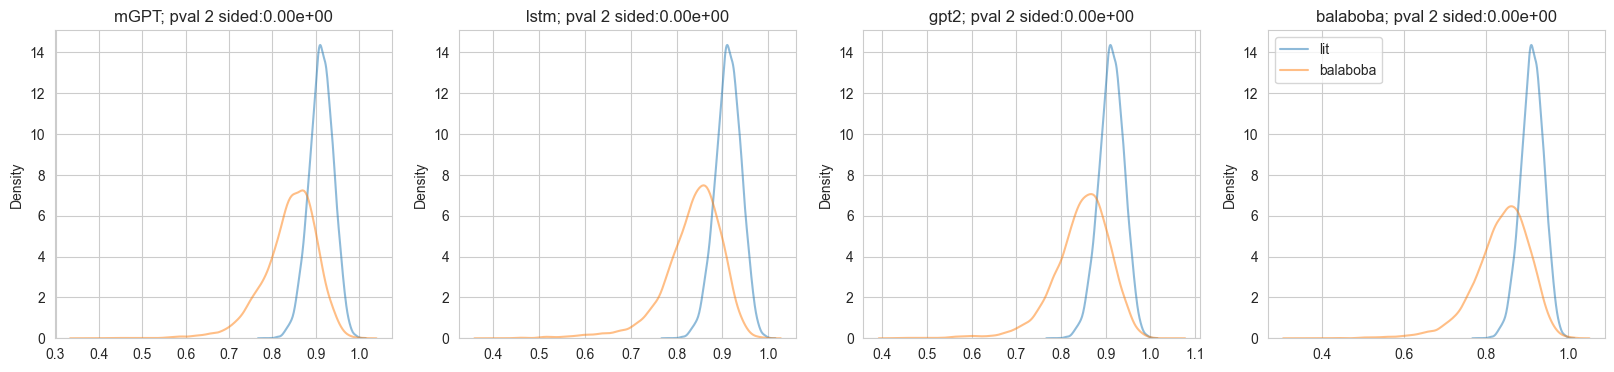

In [37]:
part = 'trigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,11], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,11], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,11], bot_ch[part][bot][:,11]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Max dist to holes

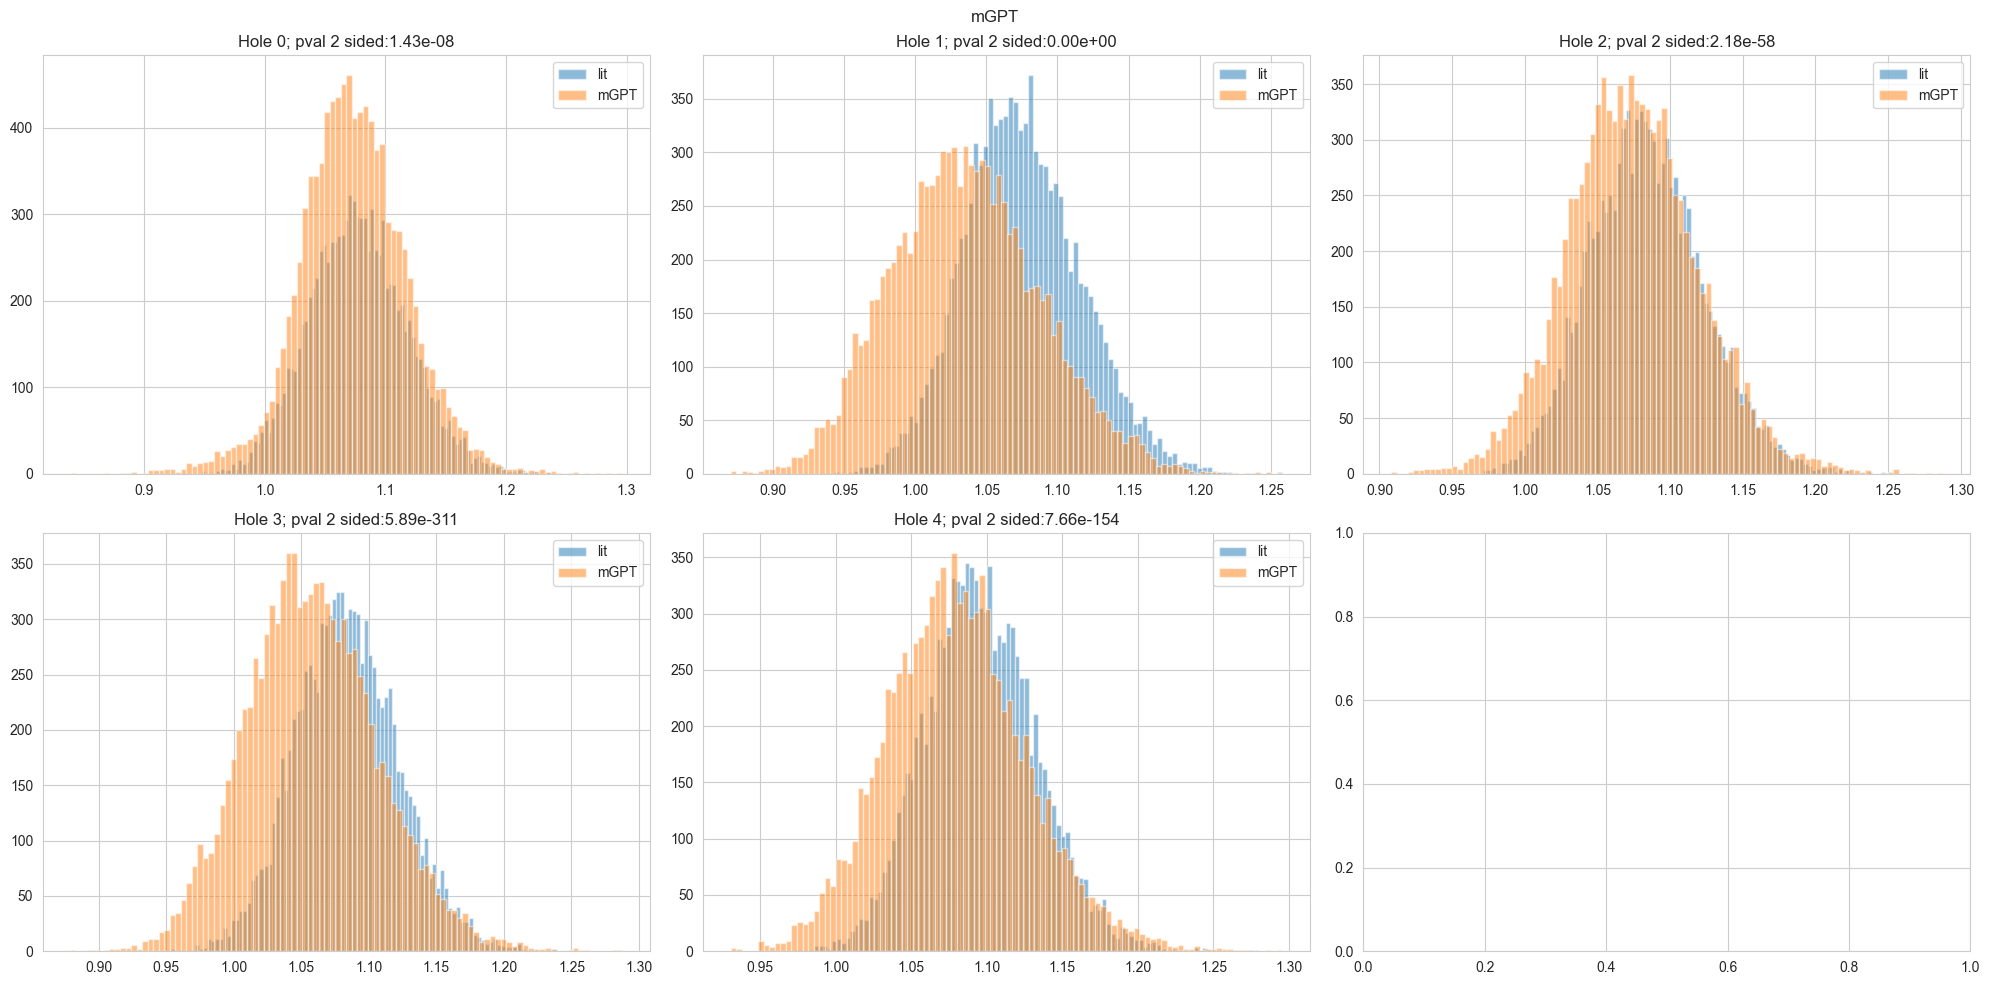

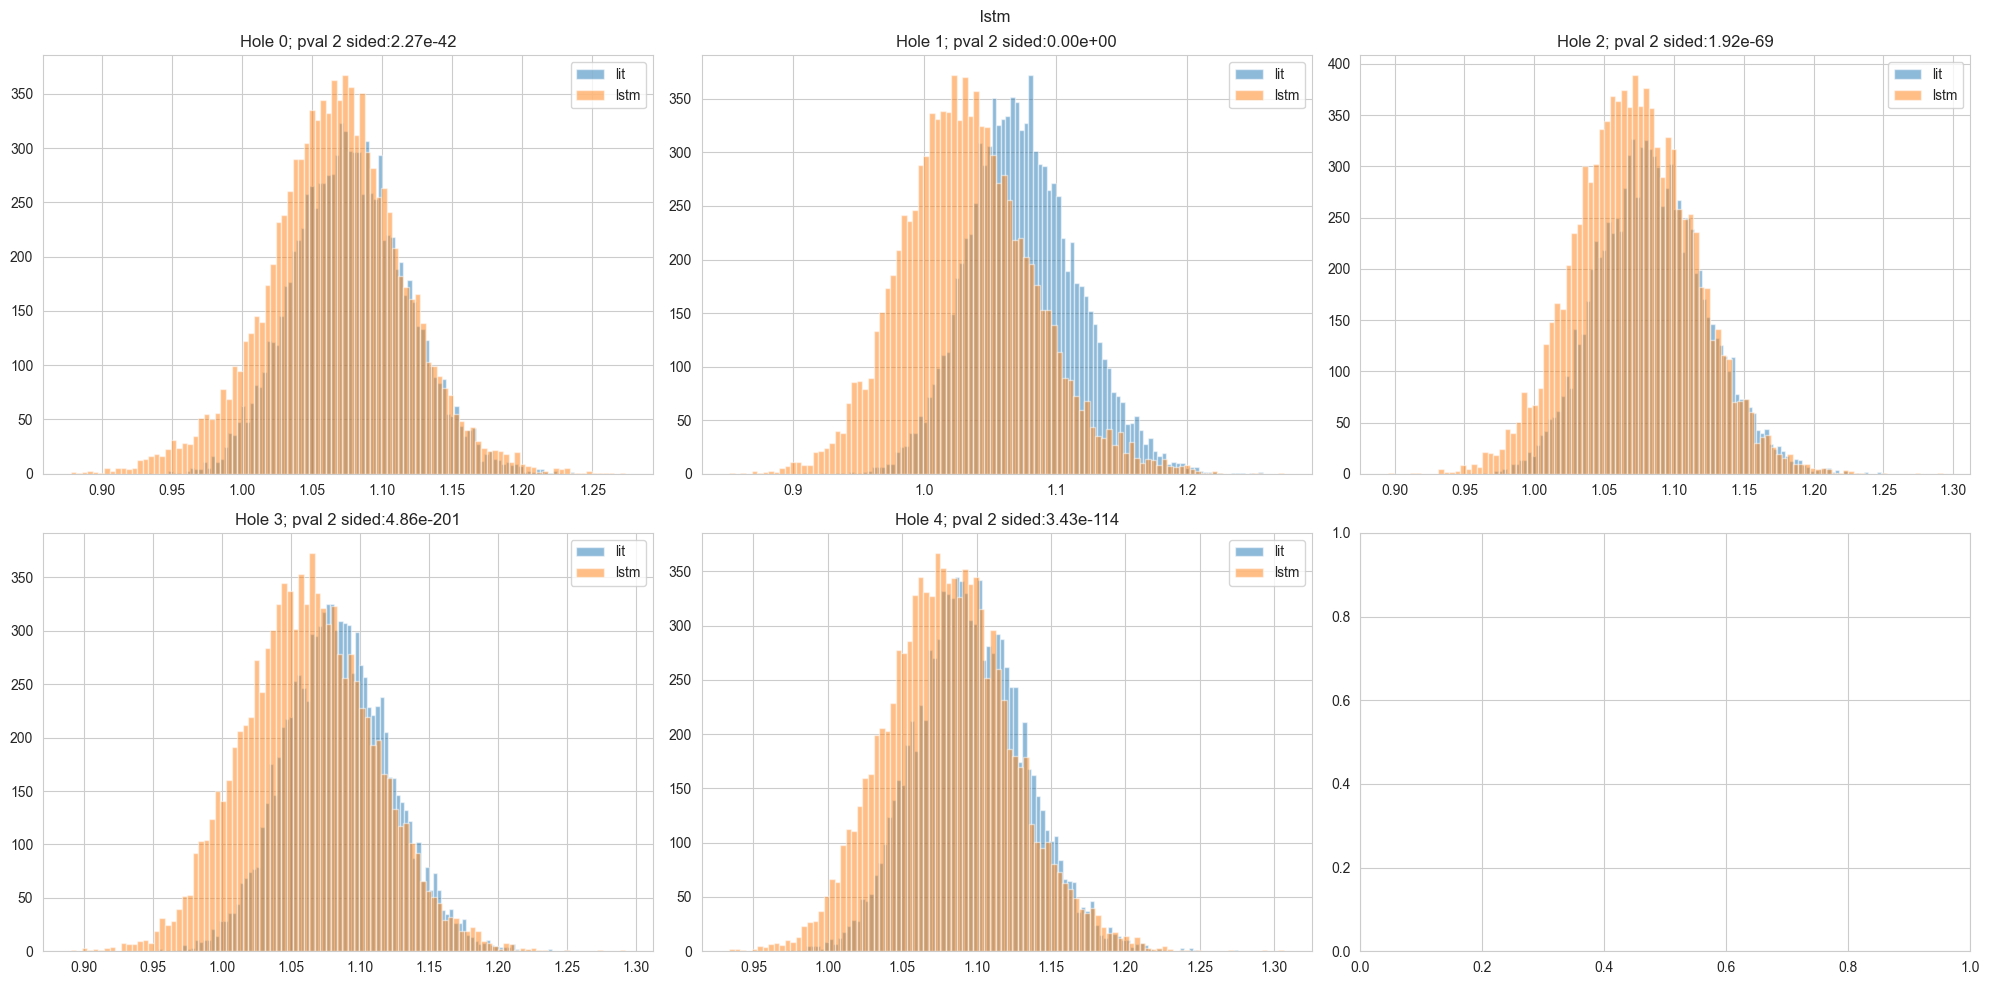

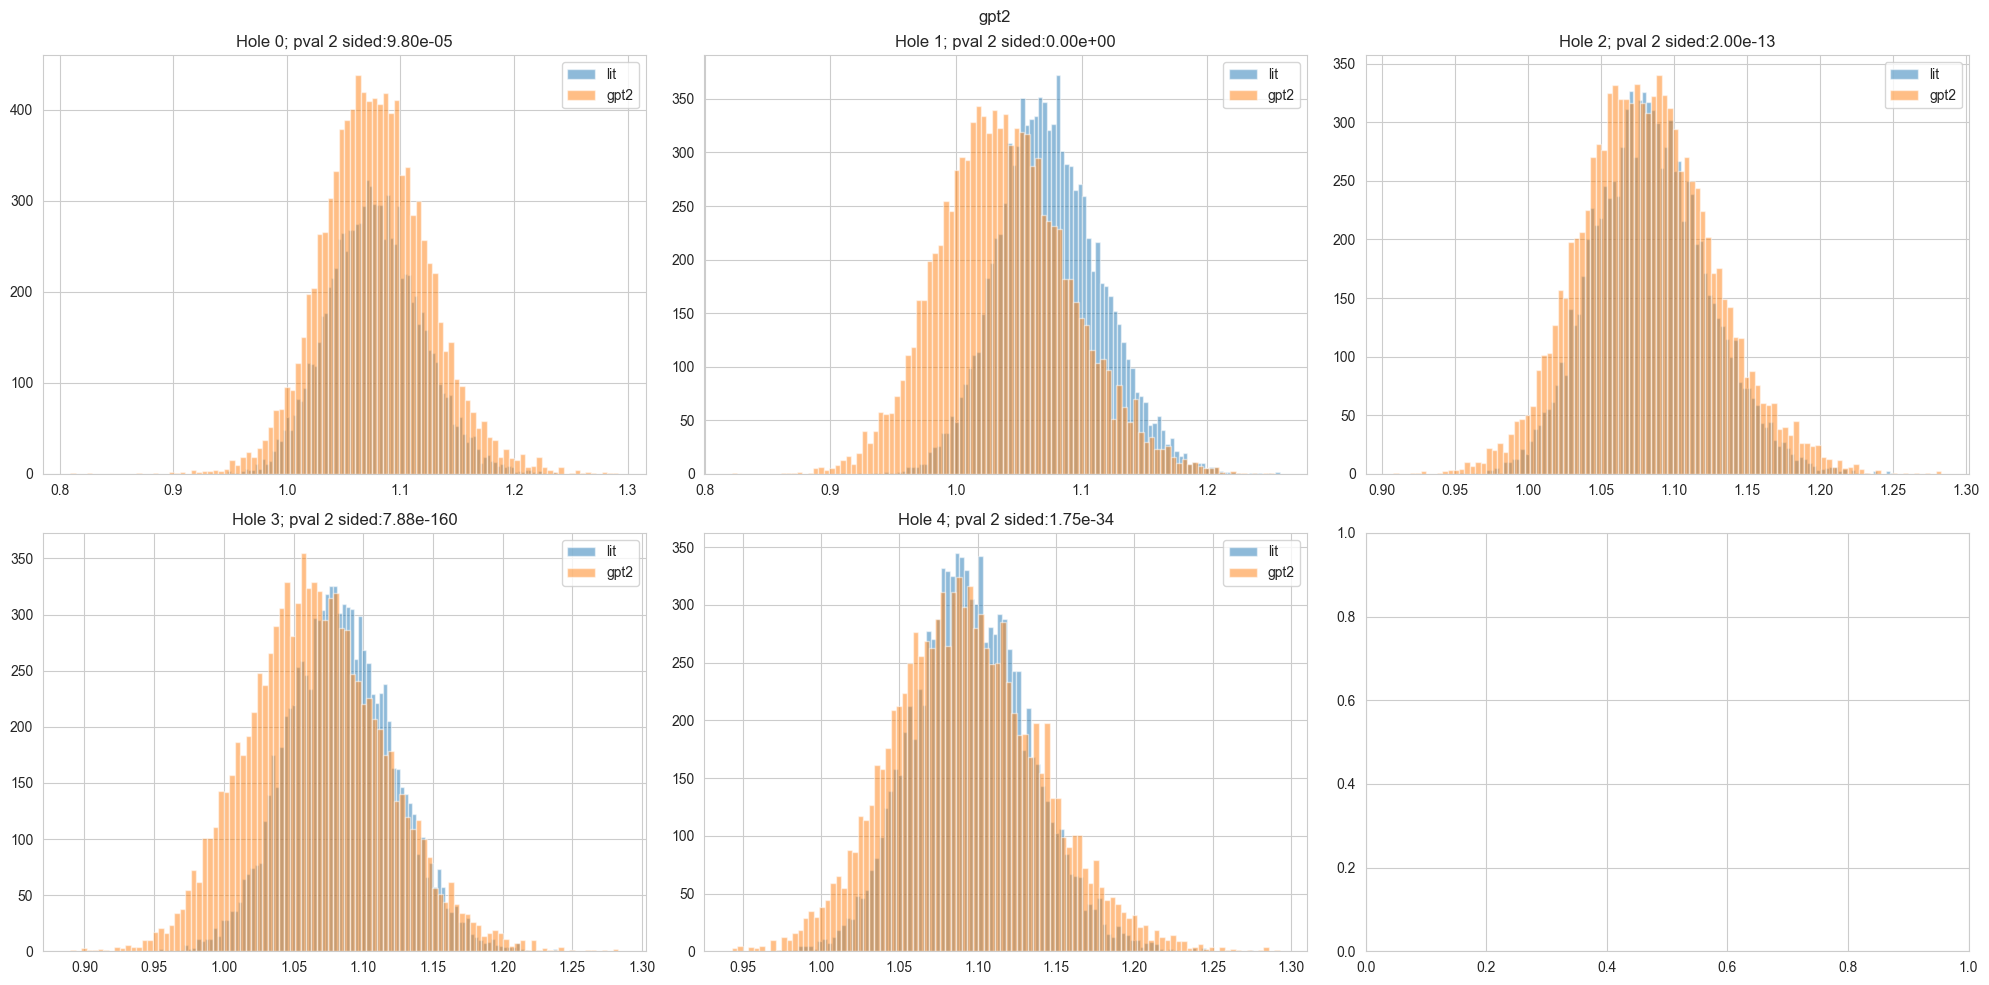

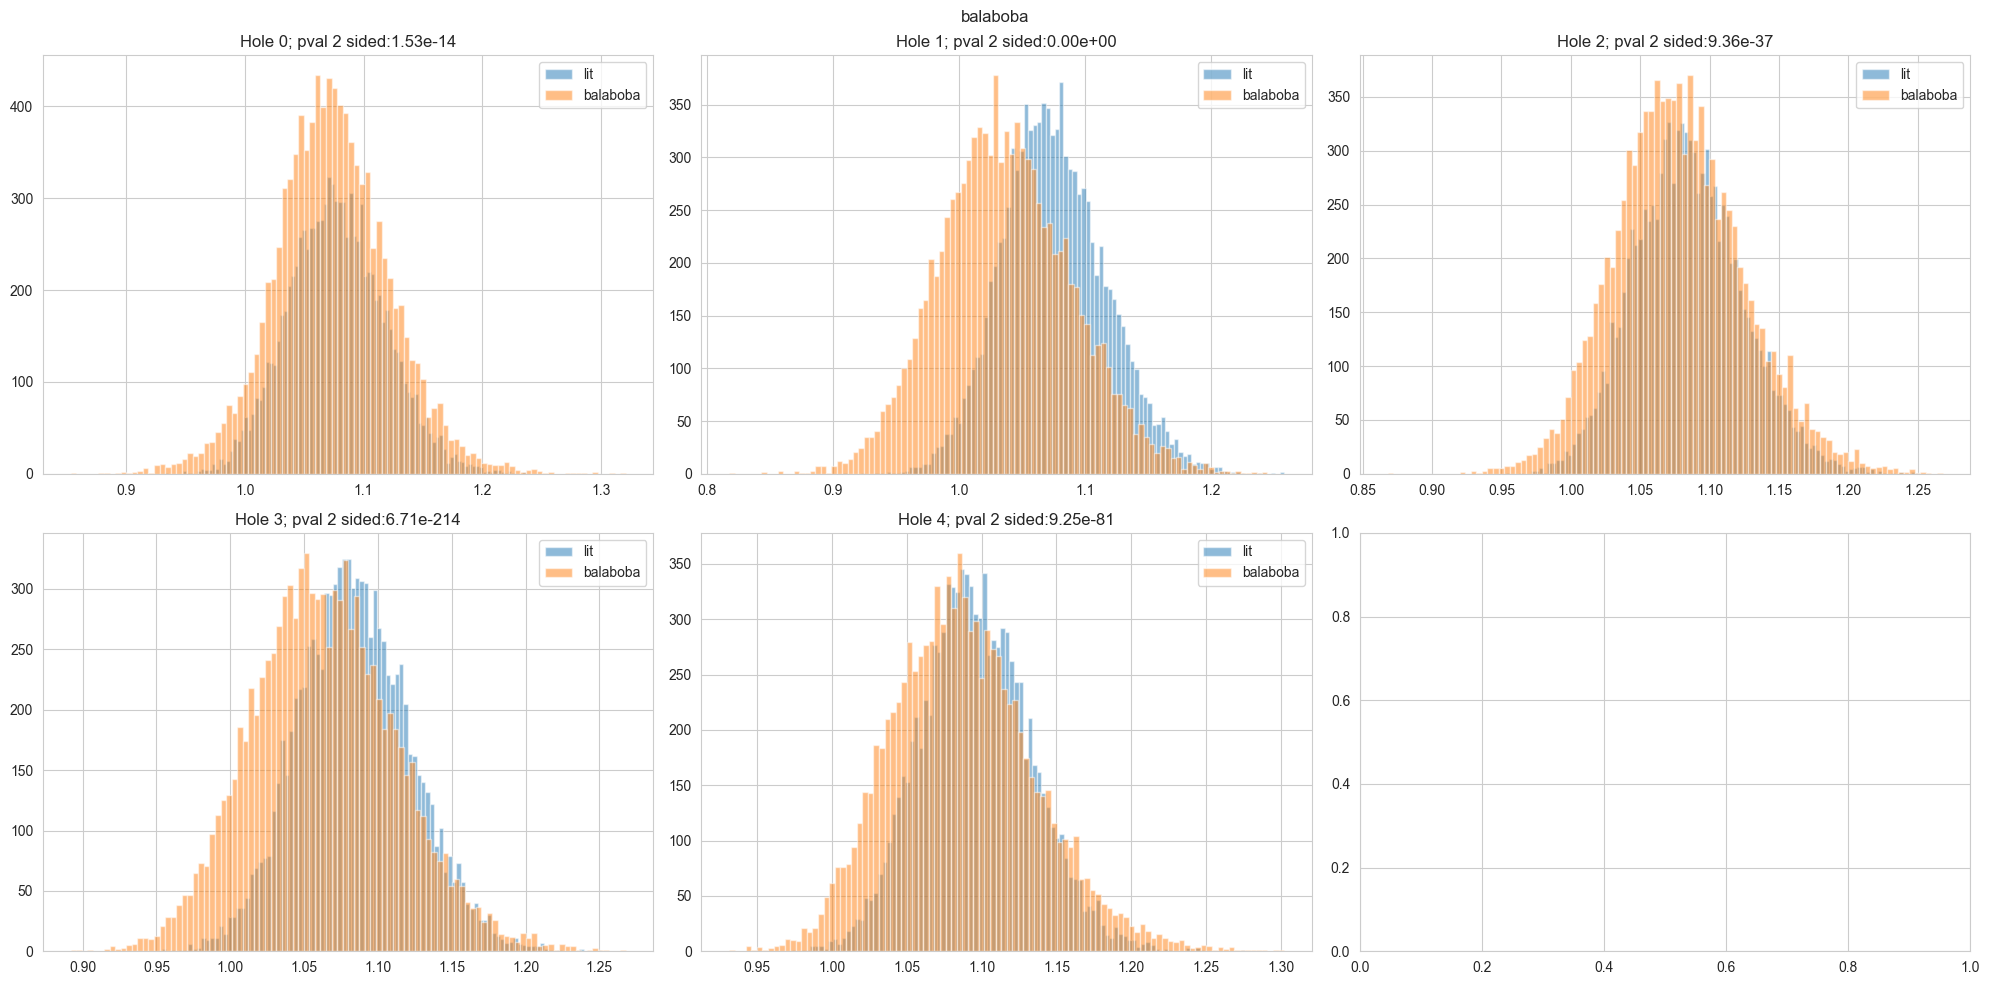

In [38]:
part = 'trigram'
for bot in bot_names:
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(bot)
    for i, ax in zip(range(5), axs.reshape(-1)):
        ax.hist(lit_ch[part][:,12 + i], label='lit', bins=100, alpha=.5)
        ax.hist(bot_ch[part][bot][:, 12 + i], label=bot, bins=100, alpha=.5)
        pval = kstest(lit_ch[part][:, 12 + i], bot_ch[part][bot][:, 12 + i]).pvalue
        ax.set_title(f"Hole {i}; pval 2 sided:{pval:.2e}")
        ax.legend()
    plt.tight_layout()
    plt.show()

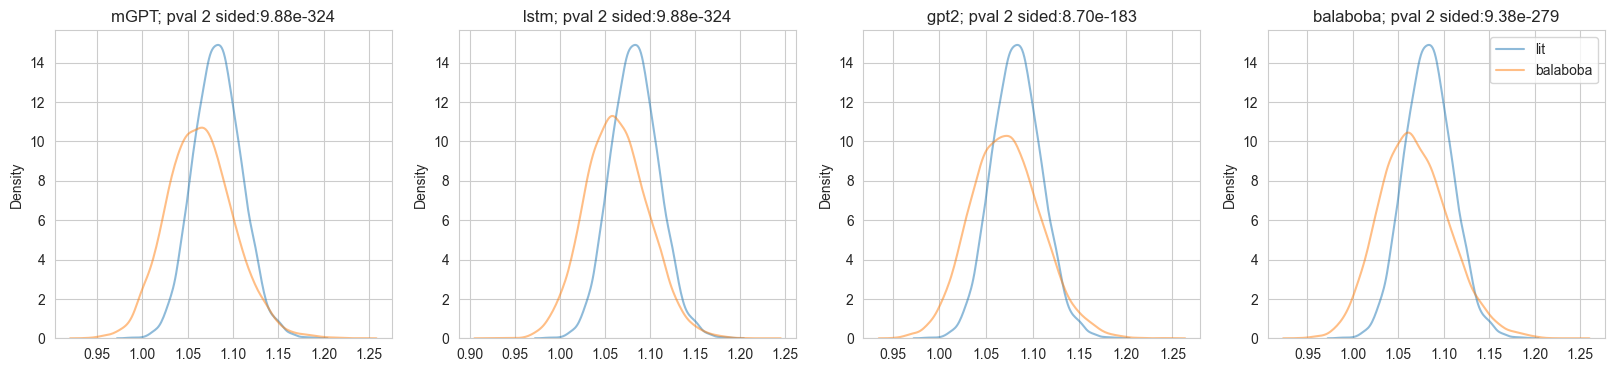

In [39]:
part = 'trigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_ch[part][:,17], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_ch[part][bot][:,17], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_ch[part][:,17], bot_ch[part][bot][:,17]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
plt.legend()
plt.show()

### Closest holes

In [40]:
from collections import Counter
part = 'trigram'

print("LIT:", Counter(np.array(lit_ch[part][:, -1], dtype=int)).most_common())
for bot in bot_names:
    print(bot, Counter(np.array(bot_ch[part][bot][:, -1], dtype=int)).most_common())

LIT: [(3, 2910), (4, 2444), (1, 2377), (2, 2269)]
mGPT [(2, 3988), (4, 2403), (3, 2191), (1, 1414), (0, 4)]
lstm [(2, 3178), (4, 2785), (1, 2253), (3, 1783), (0, 1)]
gpt2 [(2, 3986), (4, 2854), (3, 1824), (1, 1334), (0, 2)]
balaboba [(2, 3877), (4, 2703), (3, 2045), (1, 1375)]


In [43]:
part = 'trigram'
hole_names = list(hole_embeddings[part].keys())
print([(i, hn) for i, hn in enumerate(hole_names)])

[(0, '7_0$463'), (1, '7_0$465'), (2, '7_0$481'), (3, '7_0$494'), (4, '7_0$497')]


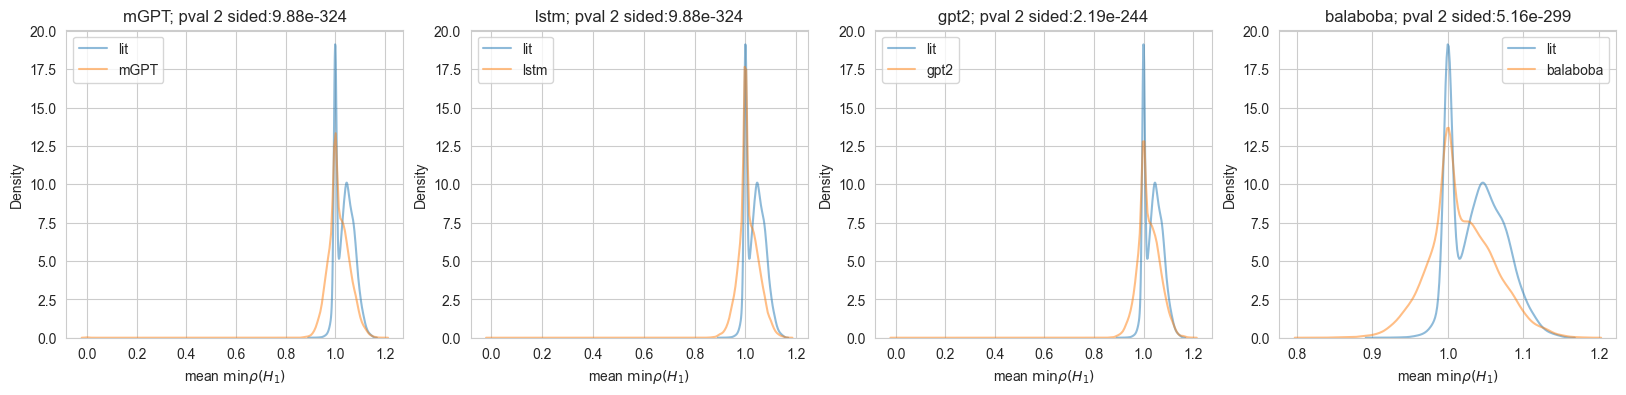

In [49]:
part = 'trigram'
fig, axs = plt.subplots(1, 4, figsize=(20,4))
for bot, ax in zip(bot_names, axs.reshape(-1)):
    sns.kdeplot(x=lit_min_dist[part], label='lit', alpha=.5, ax=ax)
    sns.kdeplot(x=bot_min_dist[part][bot], label=bot, alpha=.5, ax=ax)
    pval = kstest(lit_min_dist[part], bot_min_dist[part][bot]).pvalue
    ax.set_title(f"{bot}; pval 2 sided:{pval:.2e}")
    ax.legend()
    ax.set(xlabel=r'mean $\min\rho(H_1)$')
plt.show()